# Lorenz System - PySINDy Application & Neural Network Prediction

## COLSA Corporation 

### Raj Garkhedkar, DACS Lab Summer 2021 Intern

## Table Of Contents
#### Lorenz System Explained, Visualized, & Animated
#### Attractor w/ PySINDy Implementation - DDSE Book
#### My Implementation Using PySINDy & Analysis
#### Neural Network For System Evolution Prediction

The goal of this notebook is to demonstrate PySINDy for model discovery based on a captured time series evolution of the system, as well as implementing a neural network for parameter prediction. 

In [152]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import IPython.display as IPdisplay
import scipy.sparse as sparse
import os
import glob
import time
import warnings
import pandas as pd
import pylab as pl
import math
import itertools
import operator
import scipy.misc
import IPython.display as ipdisplay
import torch
import torch.nn.functional as F
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Activation
from keras.models import Sequential
from keras.utils.generic_utils import get_custom_objects
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
from tqdm import trange, tqdm
from collections import defaultdict
from numpy.fft import rfft,irfft,rfftfreq
from time import process_time
from sklearn.model_selection import train_test_split
from scipy.integrate import odeint, solve_ivp
from scipy.signal import argrelextrema
from scipy.fftpack import diff as diffy
from scipy.sparse import dia_matrix, csc_matrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rcParams
from PIL import Image as pil
from PIL import ImageDraw as draw
from subprocess import check_output
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from IPython.core.display import Image

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 2000
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
family = 'Times New Roman'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

###### Links

[UCSB MATLAB Paper](https://web.math.ucsb.edu/~jhateley/paper/lorenz.pdf)

[NASA Paper on SINDy & ML](https://ntrs.nasa.gov/api/citations/20200001544/downloads/20200001544.pdf) *big file, long loading time

[PySINDy Docs](https://pysindy.readthedocs.io/en/latest/index.html)

[PySINDy Examples (from docs)](https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html)

[PySINDy Publication - Official Paper](https://www.researchgate.net/publication/340806743_PySINDy_A_Python_package_for_the_Sparse_Identification_of_Nonlinear_Dynamics_from_Data)

[PySINDy GitHub Page](https://github.com/dynamicslab/pysindy)

[Lorenz NN](https://gist.github.com/raspstephan/8e9ecc9f2b74e528dff8056a0e76846c?short_path=e703112#file-lorenztorch-ipynb)

[PySINDy Syntax & API Docs](https://pysindy.readthedocs.io/en/latest/api/pysindy.html)

[Lorenz FNN GitHub](https://github.com/williamgilpin/fnn)

[Chaos & Attractors](https://blogs.rstudio.com/ai/posts/2020-06-24-deep-attractors/)

[Arxiv of Time Series Reconstruction of Attractors](https://arxiv.org/abs/2002.05909)

[Learning Chaotic Dynamics Arxiv](https://arxiv.org/pdf/1903.10335.pdf)

[Deep Representation Learning for Dynamical Systems Arxiv](https://arxiv.org/pdf/2002.05111.pdf)

[Nonlinear LSTM repo](https://github.com/srpraveen97/LSTM_nonlinear)

[Neural ODE Repo](https://github.com/msurtsukov/neural-ode)

[Properly Seeding](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)

[Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility)

[Torch DiffEq Repo](https://github.com/rtqichen/torchdiffeq/tree/master/assets)

[Differential NN Repo](https://github.com/hungngo97/differential-neural-network/blob/master/main.ipynb)

[Modeling Chaotic ODEs repo](https://github.com/vbjan/Chaos_NeuralODE/blob/master/FullStateObsNODE.py)
-- -- -- -- -- --

###### Foreword On Reproducibility:
So an issue I was occassionally running into was seeding for reproducibility. In the DDSE book and Brunton's work online, they've used `np.random.seed()` for seeding. It turns out that if not seeded, `RandomState` will read data from /dev/urandom or seed from the clock. They use 100 for their purposes to generate the same 100 but they use the command in that specific cell. My research on this topic led me to information that says Jupyter can't recognize the seed in the cells where it's not explicitly declared, so using numpy to set the seed once won't do. As mentioned in the [Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility) article, it seems that the Python kernel must be started up with `PYTHONHASHSEED=0` declared explicitly. However, for multithreading and efficiency reasons, since I'm dealing with modeling dynamical systems with large matrix transformations, speed is paramount & a careful cooperation between global reproducibility & efficiency must be formed... therefore I can't guarantee the results will be fully reproducible on any system, but, I will seed everytime in order to ensure either same or extremely similar results. I've tried to control & tame the 'randomness' as much as possible, in short. 

## Lorenz System

The Lorenz system is a system of ordinary differential equations (ODE's) which has very chaotic solutions based on initial conditions. The Lorenz Attractor is a set of specific chaotic solutions for the Lorenz system which, when plotted, resembles a butterfly. 

Mathematically, the system of equations are: 

$$\frac{dx}{dt} = \sigma(y-x)$$
<br>
$$\frac{dy}{dt} = x(\rho - z) - y$$
<br>
$$\frac{dz}{dt} = xy + \beta z$$

Below code is a regular NumPy implementation to demonstrate how it's supposed to look. 

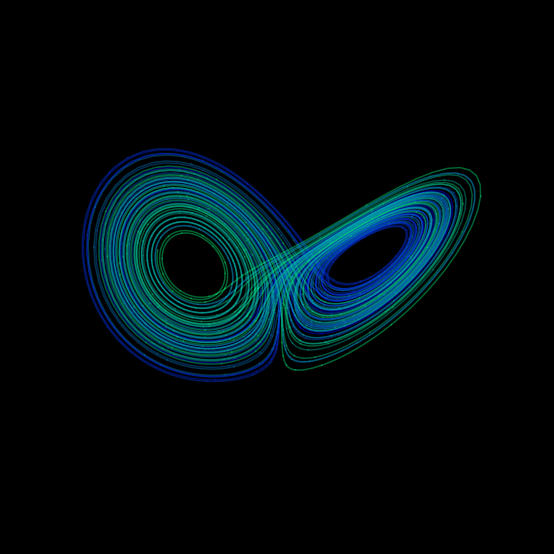

If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above


In [3]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

# Unhash below to play around with different values

# sigma = float(input("Enter A Number: "))
# beta = float(input("Enter A Number: "))
# rho = float(input("Enter A Number: "))

# u0 = float(input("Enter An Initial Condition Number: "))
# v0 = float(input("Enter An Initial Condition Number: "))
# w0 = float(input("Enter An Initial Condition Number: "))


# Lorenz paramters and initial conditions.
sigma = 10
beta = 2.66667
rho = 28
u0 = -8
v0 = 8
w0 = 27

# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx = - sigma * (x - y)
    dy = rho * x - y - x * z
    dz = - beta * z + x * y
    return dx, dy, dz

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in color across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)
ax.set_axis_off()
plt.show()

print('If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above')

So that's what it looks like with what the conditions/parameters I input... looks cool (or bad, yikes)

Hint (enter the following, in order, for a cool attractor):
`10`
`2.66667`
`28`
`-8`
`8`
`27`
OR
`20`
`6.7435`
`80`
`2`
`2`
`2`
<br>

Below, I'm animating the chaotic system to show how the particle changes trajectory depending on the initial conditions. 

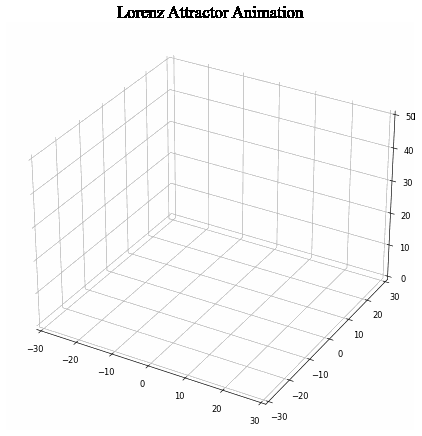

In [4]:
# Burner folder to temporary store images
folder = '/Users/rajgark/Desktop/PySINDy/AttractorImages' 

# Function for lorenz system
def lorenz_animated(current_state, t):
    x, y, z = current_state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

def plot_lorenz(xyz, n):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7)
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz Attractor Animation', fontproperties=title_font)
    
    plt.savefig('{}/{:03d}.png'.format(folder, n), dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    
def chunky(full_list, size):
    size = max(1,size)
    chunks = [full_list[0:i] for i in range(1,len(full_list) + 1, size)]
    return chunks

start = 0
end = 60
interval = 100
initial_state = [0.1,0,0]
timepoints = np.linspace(start, end, end*interval)
chunks = chunky(timepoints, size = 20)
points = [odeint(lorenz_animated, initial_state, chunk) for chunk in chunks ]
for n, point in enumerate(points):
    plot_lorenz(point, n)
    

fp_in = '/Users/rajgark/Desktop/PySINDy/AttractorImages/*.png'
fp_out = '/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif'

img, *imgs = [pil.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp = fp_out, format = 'gif', append_images = imgs, save_all = True, duration = 200, loop = 0)
IPdisplay.Image('/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif')

In [5]:
# Deletes all images captured to make gif. 
files = glob.glob('/Users/rajgark/Desktop/PySINDy/AttractorImages/*')
for f in files:
    os.remove(f)

## Lorenz  Attractor w/ PySINDy Implementation

This PySINDy implementation is guided by the original docs.

In [6]:
def sindylorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]
dt = 0.001
t_train = np.arange(0,100,dt)
print('t_train size: ',t_train.size)
x0_train = [-8, 8, 27] 
x_train = odeint(sindylorenz, x0_train, t_train)
x_dot_train_measured = np.array([sindylorenz(x_train[i], 0) for i in range(t_train.size)])

t_train size:  100000


This is their implementation based on the PySINDy docs

In [7]:
x_train

array([[-8.        ,  8.        , 27.        ],
       [-7.84087856,  7.98355342, 26.86488252],
       [-7.68350838,  7.96625052, 26.73151873],
       ...,
       [-5.31069055, -8.18331516, 16.83582711],
       [-5.33952879, -8.23455986, 16.83464659],
       [-5.36859135, -8.28608134, 16.83398129]])

In [8]:
t_train

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 9.9997e+01, 9.9998e+01,
       9.9999e+01])

In [9]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

optimize = ps.STLSQ(threshold = threshold)
featurelib = ps.PolynomialLibrary(degree = polynomial_order)

model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(size = x_train.shape), quiet = True)
#models = []
#tsim = np.arange(0,20,dt)
#xsim = []
#noises = [1e-3, 1e-3, 1e-2, 1e-1, 1.0]

# for eps in noises:
#     model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
#     model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(scale = eps, size = x_train.shape), quiet = True)
#     models.append(model)
#     xsim.append(model.simulate(x_train[0], tsim))

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ(threshold=0.05))

The hashed out code is from the docs, I had it to debug. The optimizer actually can choose random values so it's important to make sure the notebook is seeded for reproducibility.

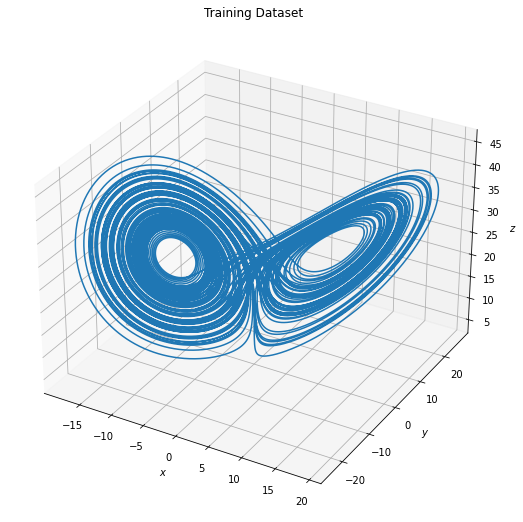

In [10]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_train.size, 0],
    x_train[: t_train.size, 1],
    x_train[: t_train.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

Above is how the attractor looks for the training dataset

In [11]:
model.print()

x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


`x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1`

These are the predictions of the model, or I should say, the coefficients predicted for the ODE.Those should be the outputs of the above cell, this is with an optimizer and feature library.

In [12]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([-8,7,15])
x_test = odeint(sindylorenz, x0_test, t_test)

Above I've done a test set on a trajectory guided through the discovery made in the train set. The initial conditions are different here, so an approximation made here, if accurate, means the model is behaving like a good guy

In [13]:
t_test.size

15000

In [14]:
x_test.size

45000

Ignore above output, done for my testing.

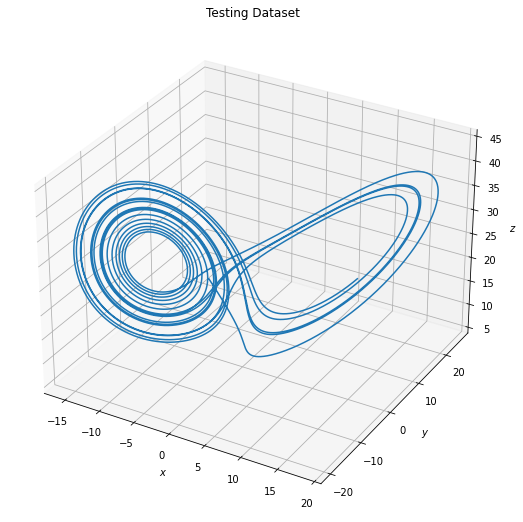

In [15]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_test[: t_test.size, 0],
    x_test[: t_test.size, 1],
    x_test[: t_test.size, 2],
)
plt.title("Testing Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

The goal now will be to leverage the training dataset and testing dataset to make a simulation which goes forward in time accurately projecting the trajectory of the chaotic particles.
<br> 
After doing so, a neural network can be implemented (as done in DDSE pg. 216 by Brunton & Kutz) to create a robust system for modeling the lorenz system of equations.

### My Implementation

I aim to play around with the variables and analyze how noisy simulations vs non-noisy simulations fare for the library

In [16]:
newdt = 0.002

t_trainset = np.arange(0, 100, newdt)
x0_trainset = [-8, 8, 27]
x_trainset = odeint(sindylorenz, x0_trainset, t_trainset)

newmodel = ps.SINDy()
newmodel.fit(x_trainset, t = newdt)
newmodel.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


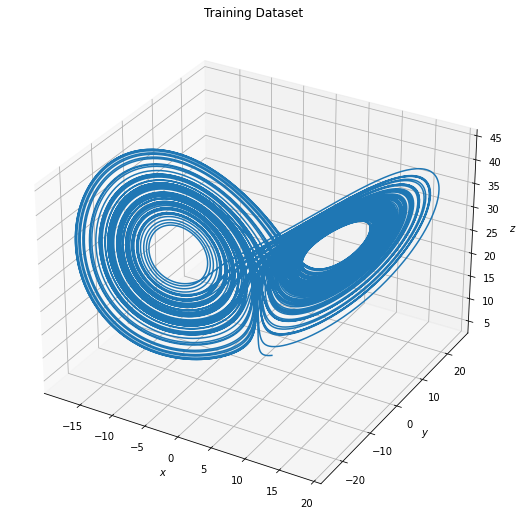

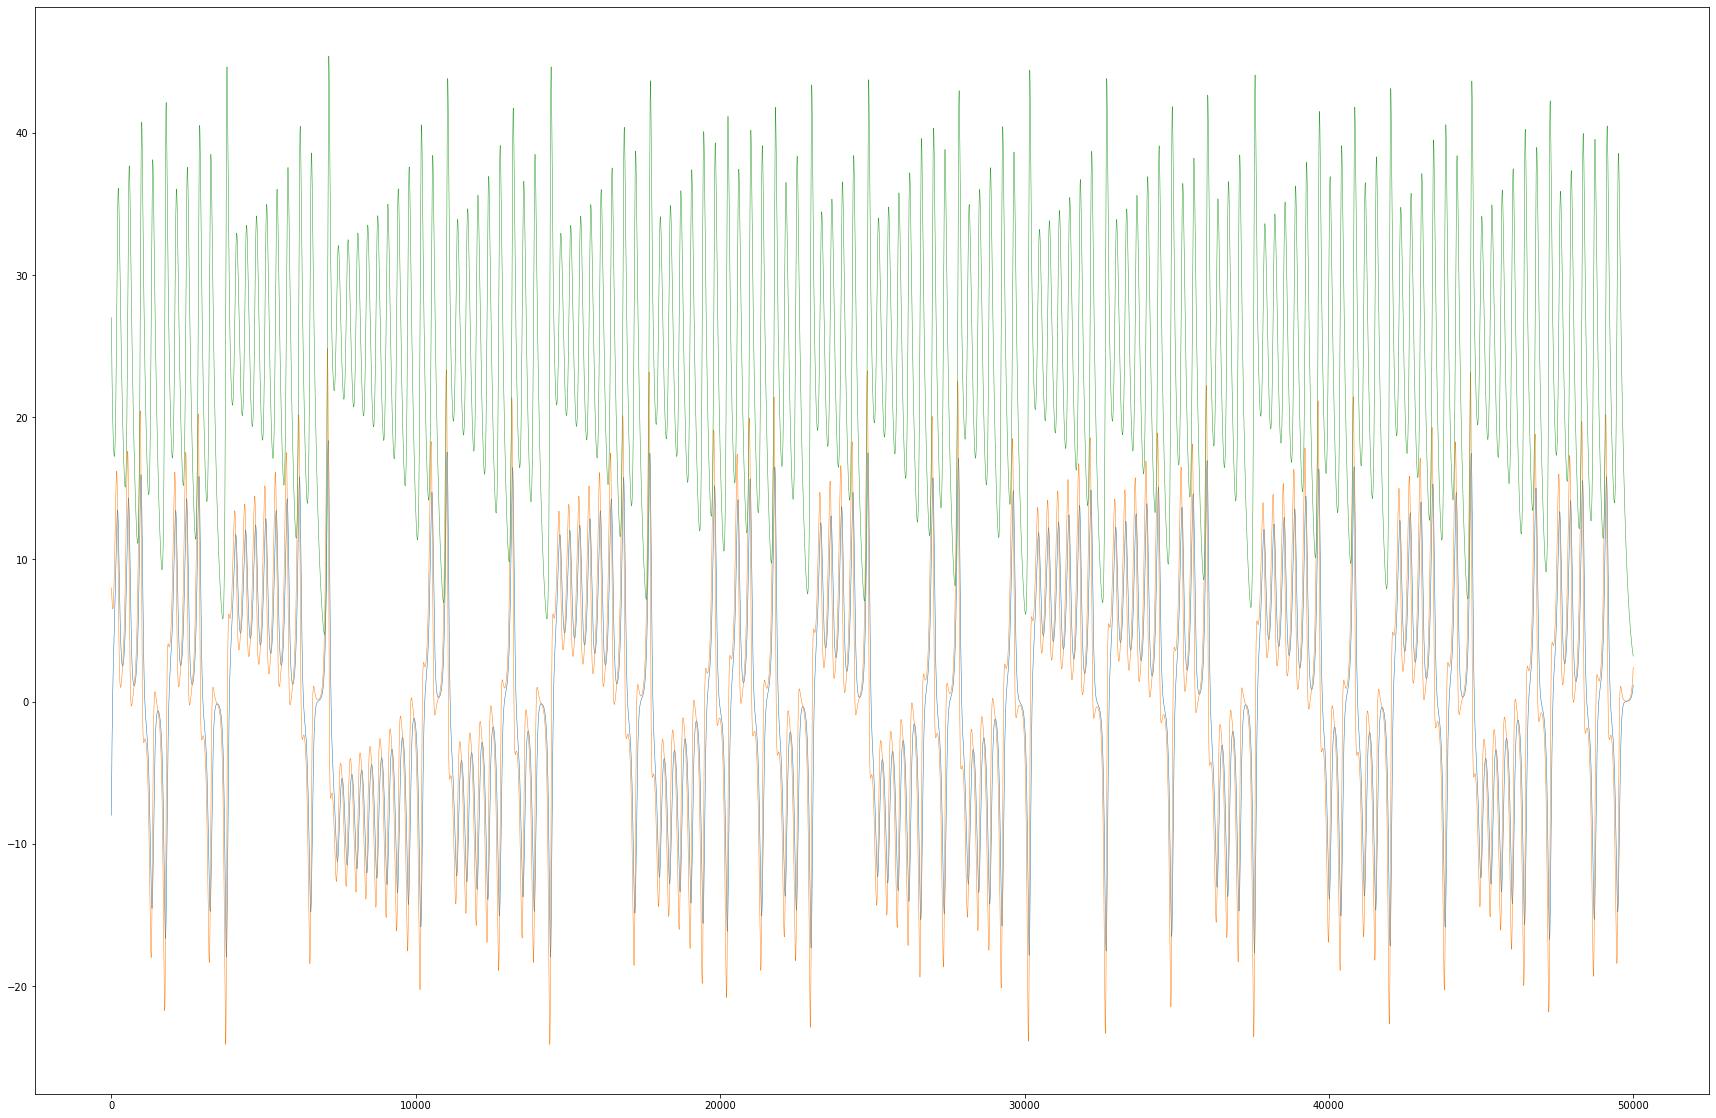

In [17]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_trainset[:t_trainset.size], linewidth = 0.5)
plt.show()

Above is a new model created and fit to the training data with a graph representing the trajectory. The green is the z-axis and orange/blue are x/y switches. 

In [18]:
t_testset = np.arange(0, 15, newdt)
x0_testset = np.array([8, 7, 15])
x_testset = odeint(sindylorenz, x0_testset, t_testset)

print('Model score: %f' % model.score(x_testset, t = newdt))

Model score: 1.000000


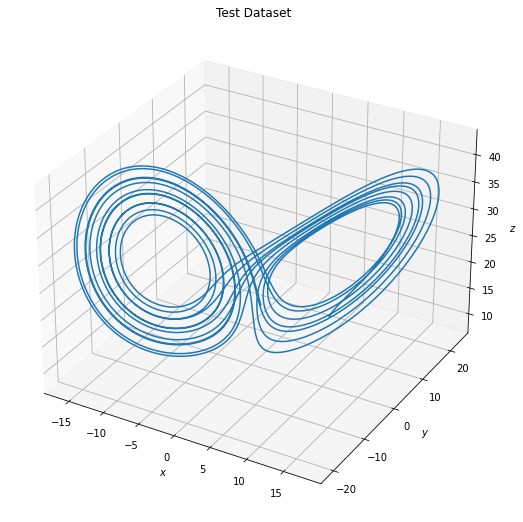

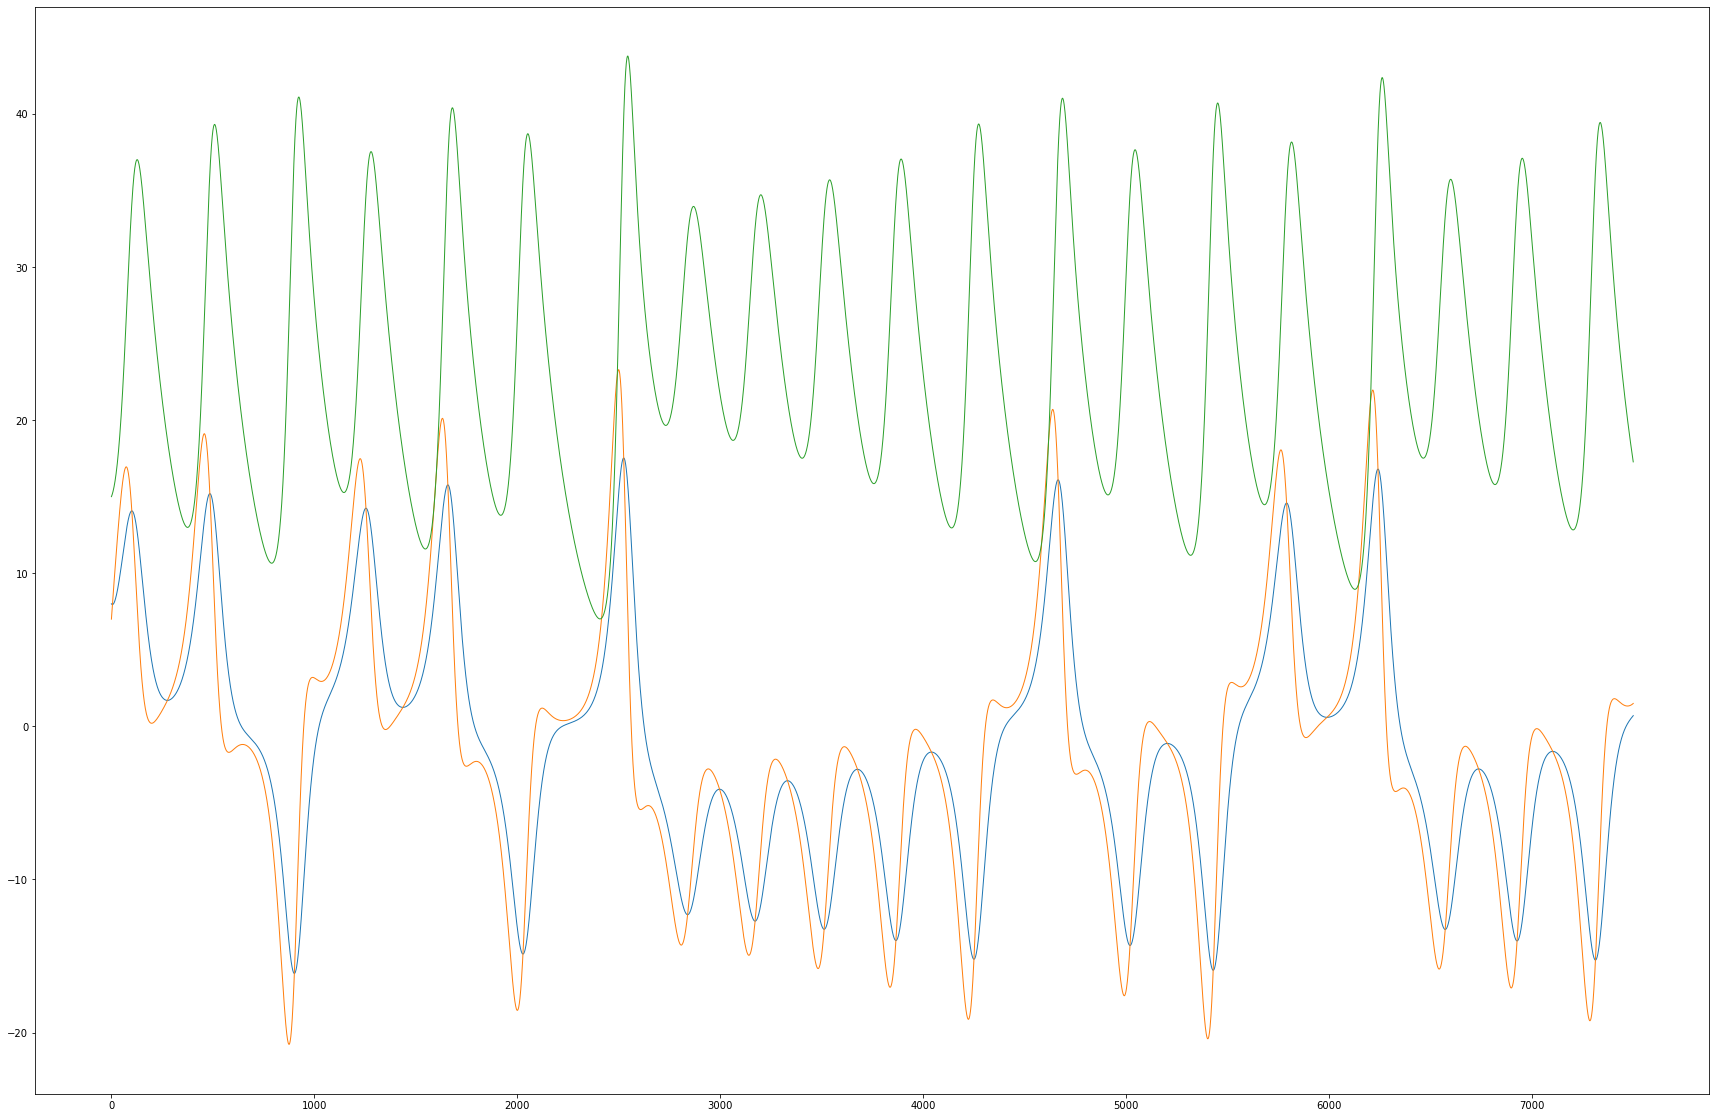

In [19]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
)
plt.title("Test Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_testset[:t_testset.size], linewidth = 1)
plt.show()

The test system above is with a smaller dataset and different initial conditions than the training dataset. Scoring the test dataset against the model trained w/ training data, we see a perfect fit, thus indicating it's able to predict the derivatives properly

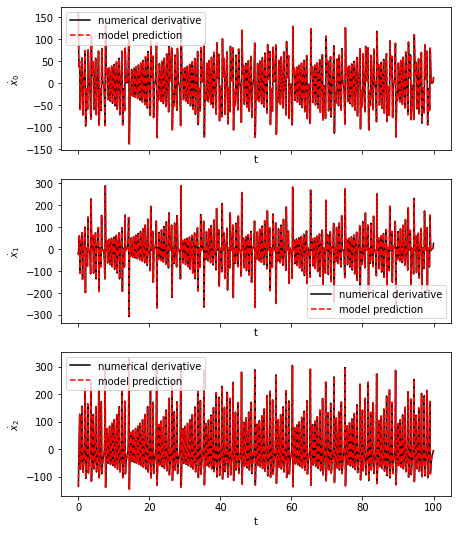

In [20]:
x_dot_train_pred = newmodel.predict(x_trainset)

x_dot_train_comp = newmodel.differentiate(x_trainset, t = newdt)

fig, axs = plt.subplots(x_trainset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_trainset.shape[1]):
    axs[i].plot(t_trainset, x_dot_train_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_trainset, x_dot_train_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

Predicting the derivative graphed against the true derivative shows that it matches up perfectly

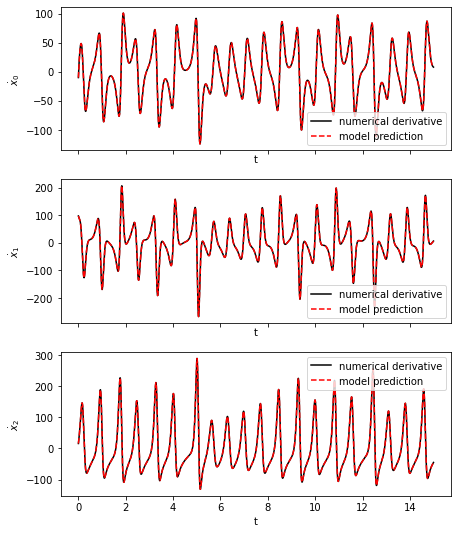

In [21]:
x_dot_test_pred = newmodel.predict(x_testset)

x_dot_test_comp = newmodel.differentiate(x_testset, t = newdt)

fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_dot_test_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_testset, x_dot_test_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

Same story here

In [22]:
x_test_sim = newmodel.simulate(x0_testset, t_testset)
x_test_sim.shape

(7500, 3)

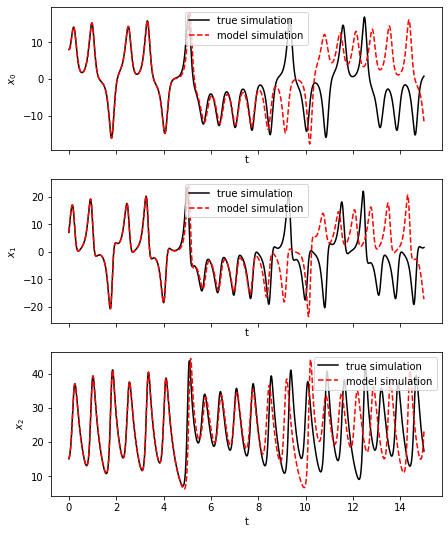

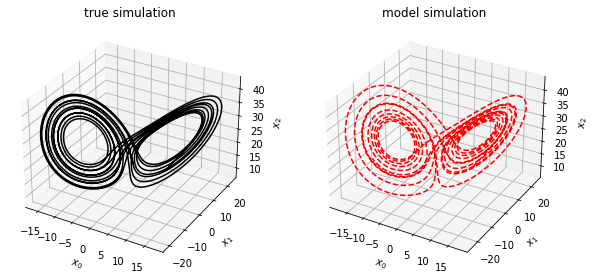

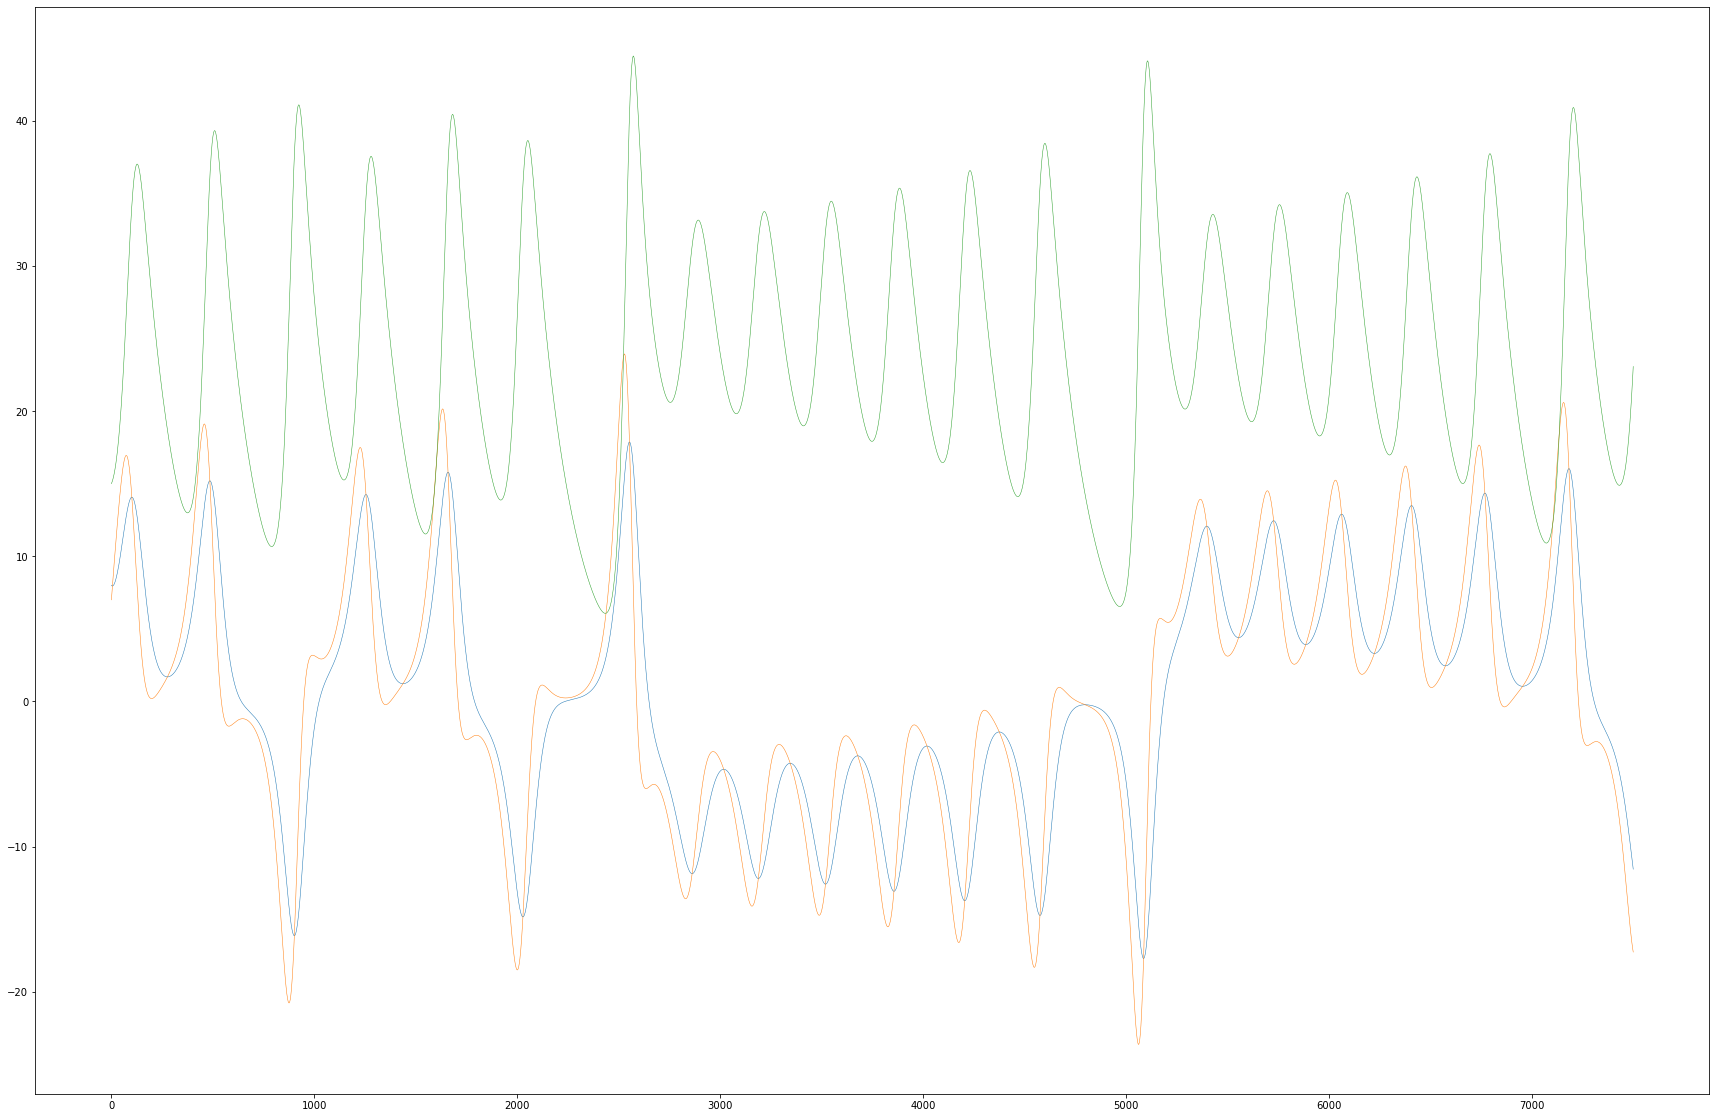

In [23]:
fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_testset[:, i], 'k', label='true simulation')
    axs[i].plot(t_testset, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_testset[:, 0], x_testset[:, 1], x_testset[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_test_sim[:t_testset.size], linewidth = 0.5)
plt.show()

Running the PySINDy simulation method shows that if kept going, the modeled sparse regression approach would eventually converge on the true simulation, meaning it would properly approximate the future state based on the derivatives & current state

### Measure only $x$ states & compute derivatives

In [24]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

t_sim = np.arange(0, 20, newdt)
garbmodel = ps.SINDy(optimizer = optimize, feature_library = featurelib)
garbmodel.fit(x_trainset + np.random.normal(size = x_trainset.shape), t = newdt, quiet = True)
x_sim_nod = garbmodel.simulate(x_trainset[0], t_sim)

x_dot_train_measured_new = np.array([sindylorenz(x_trainset[i], 0) for i in range(t_trainset.size)])

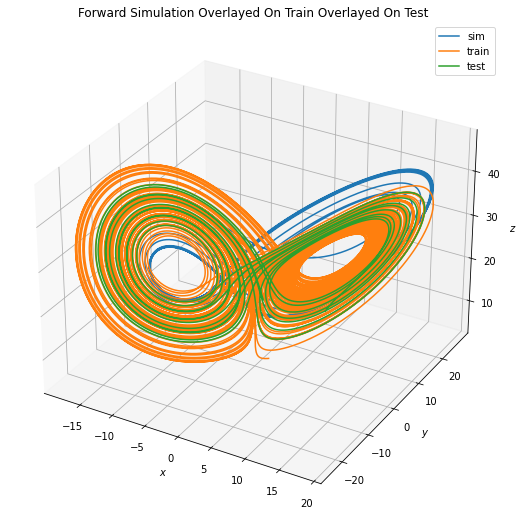

In [25]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
# Blue
pl1 = ax.plot(
    x_sim_nod[: t_sim.size, 0],
    x_sim_nod[: t_sim.size, 1],
    x_sim_nod[: t_sim.size, 2],
    label='sim'
)
# Orange
pl2 = ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
    label='train'
)
# Green
pl3 = ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
    label='test'
)
plt.title("Forward Simulation Overlayed On Train Overlayed On Test")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
#ax.legend([pl1, pl2, pl3], ['Sim','Train','Test'])
ax.legend()
fig.show()

The training and simulation show a semblance of similarity, meaning the algorithm is needs a bit of tuning. If you notice the forward simulation (blue), it can be noticed that the blue appearing on the top right area is what the training matrix will look like if the algorithm continues differentiating forward, thus 'completing' it. Essentially showing how the system will evolve. 

In [26]:
seed = 100
np.random.seed(seed)
noisedt = 0.001
noise_t_train = np.arange(0, 20, noisedt)
noise_x0_train = [-8,8,27]
noise_x_train = odeint(sindylorenz, noise_x0_train, noise_t_train)
noise_xdot_train_measured = np.array([sindylorenz(noise_x_train[i], 0) for i in range(noise_t_train.size)])

poly = 5
threshold = 0.5

optimize = ps.STLSQ(threshold = threshold)
flib = ps.PolynomialLibrary(degree = poly)

noises = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

noisemodels = []
noise_t_sim = np.arange(0, 20, noisedt)
noise_x_sim = []

for levels in noises:
    noisemodel = ps.SINDy(optimizer = optimize, feature_library = flib,)
    noisemodel.fit(noise_x_train, t = noisedt, x_dot = noise_xdot_train_measured + np.random.normal(scale = levels, size = noise_x_train.shape), quiet = True)
    noisemodels.append(noisemodel)
    noise_x_sim.append(noisemodel.simulate(noise_x_train[0], noise_t_sim))

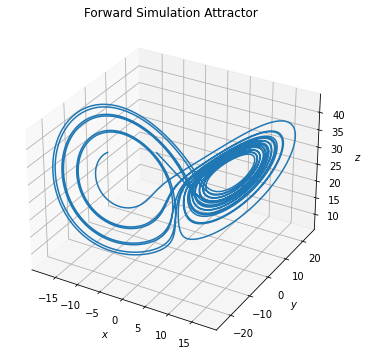

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection="3d")
model_idx = 2
ax.plot(
    noise_x_sim[model_idx][:, 0],
    noise_x_sim[model_idx][:, 1],
    noise_x_sim[model_idx][:, 2],
)
plt.title("Forward Simulation Attractor")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.show()

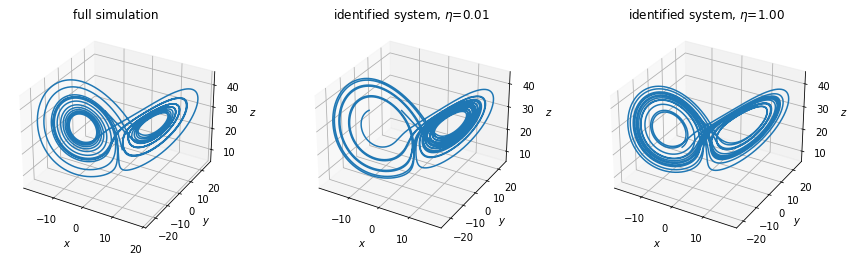

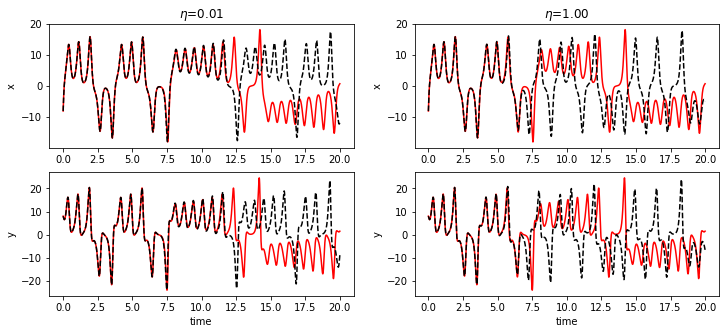

In [28]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    noise_x_train[: noise_t_sim.size, 0],
    noise_x_train[: noise_t_sim.size, 1],
    noise_x_train[: noise_t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

This is pretty much identical to the DDSE findings for the noisy simulation, like in the docs

### Multiple Trajectories w/ Different Time Measurements

This dataset generates 50 random trajectories measured across random time domains. 

In [29]:
seed = 100
np.random.seed(seed)
n_trajectories = 50

x0s = np.array([36, 48, 41]) * (np.random.rand(n_trajectories, 3) -0.5) + np.array([0,0,25])
x_train_multi = []
t_train_multi = []

for i in range(n_trajectories):
    n_samples = np.random.randint(250,3000)
    t = np.arange(0, n_samples * newdt, newdt)
    x_train_multi.append(odeint(sindylorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t = newdt, multiple_trajectories = True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [30]:
print('Multi-trajectory array shape: ',np.shape(x_train_multi))
#t_train_multi

Multi-trajectory array shape:  (50,)


In [140]:
def multi_traj_plot(particle_ID):
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(131, projection="3d")
    multi_idx = particle_ID
    ax.plot(
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 0],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 1],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 2],
    )
    plt.title("Randomized Attractor")
    ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
    fig.show()

The function above plots the randomized attractor w/ random temporal measurements

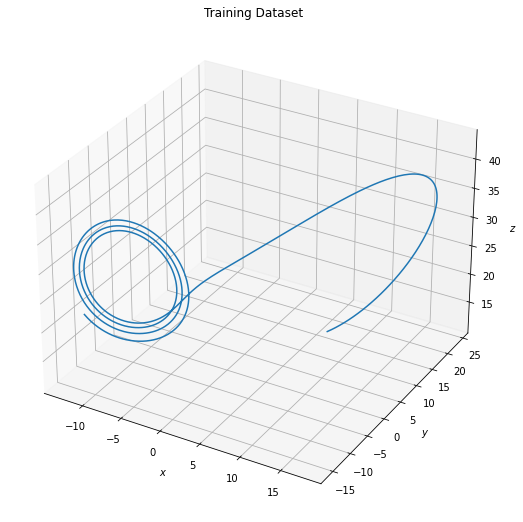

In [32]:
multi_traj_plot(2)

There are 50 (0-49) particles with random trajectories in the variable `x_train_multi` and to show the particle trajectory for any one of your choice, simply enter a number, 0-19, into the argument for the function `multi_traj_plot(enter#here)` 
<br>
The array consists of 20 particles with unique trajectories and times, so there is a very high likelihood of the selected pattern being obscure rather than a good looking attractor. This is due to the sampling rate being multiplied by `newdt` so regardless of the number, the infinitesimal increase dictates the shape of the array. Leaving it to the value it's set at is the best for reproducing valid data throughout the notebook, but newdt can be reassigned on the top of the cell right under the new multi-trajectory section if desired, being sure to hash it out while executing the notebook again.

## Lorenz System Neural Network

Since PySINDy has been implemented for model prediction & simulation, the next step is to create a neural network to predict the dynamical system's evolution spatially & temporally. The variable at hand is $x(t)$ where $x$ is the state of the system at time $t$, and the prediction (output) is $y(t+dt)$, or the state of the system after some infinitesimal time $dt$.

In DDSE pg. 216, Brunton & Kutz mention that the state of the system is given by the matrix $\textbf{x} = [x\ y\ z]^T$ and it'll require a nonlinear transfer function since the system itself is nonlinear.
<br>
<br>
The goal of the system is to produce an output matrix of the system at some arbitrary time after the measured state. 

### DDSE Prof. Brunton's Implementation

Their implementation, as done in their book & code, was outdated. They used an older Keras which is incompatible, so I redid their implementation.

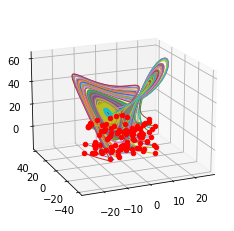

In [34]:
## Simulate the Lorenz System

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [36]:
## Neural Net
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = (3)))
model.add(layers.Dense(10,activation='sigmoid'))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(10,activation='linear'))
model.add(layers.Dense(3,None))
model.summary()
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(nn_input, nn_output, batch_size = 1, epochs = 30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________
80000/80000 [==============================] - 73s 914us/step - loss: -63734060.0000 - accuracy: 0.9818


Training for 30 epochs takes quite some time, but it's generally a good model

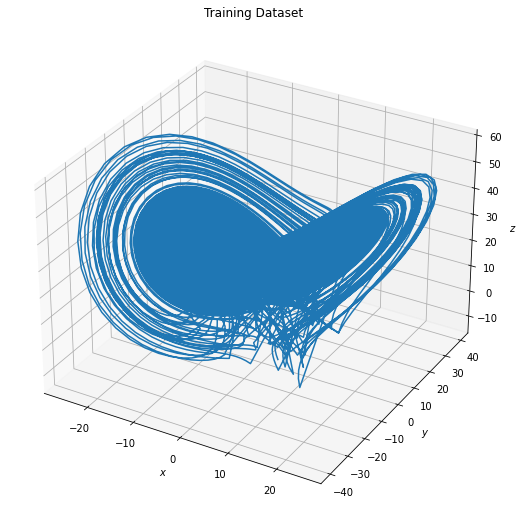

In [37]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    nn_input[: , 0],
    nn_input[: , 1],
    nn_input[: , 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

## My Implementation

My attempt with creating a neural network for parameter learning. Considering a 'true' system, one which is controlled, I've compared that with a perturbed system with parameters which are slightly greater or lower than their truth counterpart. The goal will be to figure out how to bring the perturbed parameters closer to the ground truth values.

### Parameter Learning

In [155]:
sigma = 10
rho = 28
beta = 8/3

class LorenzTorch():
    def __init__(self, sigma, rho, beta, init, dt, param_grads):
        self.sigma, self.rho, self.beta = [Converter(param, param_grads) for param in [sigma, rho, beta]]
        self.x, self.y, self.z = [Converter(i) for i in init]
        self.dt = Converter(dt)
        self.hist = []
        self.step_count = 0
    
    def step(self):
        self.x = self.x + (self.sigma * (self.y - self.x)) * self.dt
        self.y = self.y + (self.x * (self.rho - self.z)) * self.dt
        self.z = self.z + (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append(np.squeeze(np.array([np.copy(var.data.cpu().numpy()) for var in [self.x, self.y, self.z]])))
        self.step_count += 1
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

def Converter(x, requires_grad=False, gpu=False):
    t = torch.FloatTensor(np.atleast_1d(x).astype(np.float32))
    if gpu: t = t.cuda()
    return Variable(t, requires_grad=requires_grad)

def plot_attractor(hists):
    if np.array(hists).ndim == 2: hists = [hists]
    hists = [np.array(h) for h in hists]
    fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
    [ax.plot(h[:,0], h[:,1], h[:,2]) for h in hists]


def mse(true, pred):
    return ((true - pred) ** 2).mean()
    
def stack_state(l, sparse=None):
    s = torch.stack([l.x, l.y, l.z])
    if sparse is not None: s = s[sparse]
    return s    

def learning_loop(true_params, pert_params, lr, n_model_steps, n_learn_steps, sparse=None):
    hist = defaultdict(list)
    init = list(np.random.rand(3) * 10)
    for n_learn in tqdm(range(n_learn_steps)):
        ltrue = LorenzTorch(*true_params, init, 1e-2, False); ltrue.integrate(n_model_steps)
        lpert = LorenzTorch(*pert_params, init, 1e-2, True); lpert.integrate(n_model_steps)
        loss = mse(stack_state(ltrue, sparse), stack_state(lpert, sparse))
        loss.backward()
        grads = [lpert.sigma.grad.data.numpy(), lpert.rho.grad.data.numpy(), lpert.beta.grad.data.numpy()]
        pert_params = [pert_params[i] - lr*var.grad.data.numpy() for i, var in
                      enumerate([lpert.sigma, lpert.rho, lpert.beta])]
        hist['loss'].append(loss.data.numpy()); hist['pert_params'].append(pert_params)
        init = ltrue.hist[-1]
        print('Loss: ', loss)
    print('-- -- -- -- -- -- -- -- -- -- -- -- --')
    print(' ')
    print('Total Loss: ', loss)
    return hist
    
def plot_params(h):
    [plt.plot(np.array(h['pert_params'])[:, i] - true, label=l) 
     for l, (i, true) in zip(['sigma', 'rho', 'beta'], enumerate([sigma, rho, beta]))]
    plt.axhline(0, c='gray', zorder=0.1); plt.legend(); plt.title('Parameter error');

The above cell contains the class for creating an attractor object with appropriate `dt` steps and all the functions that aid with plotting & training

The below cell creates a control run where the system is untouched, pure, in a sense. 

In [156]:
ltrue = LorenzTorch(sigma, rho, beta, init=[-8, 8, 28], dt=1e-2, param_grads=False)

ltrue.integrate(3000)

sigma, beta, rho

(10, 2.6666666666666665, 28)

Below, the system is a bit perturbed, so the 3 parameters are slightly off. Same initial conditions, however. Plotting below shows how the perturbed system differs from the true system. 

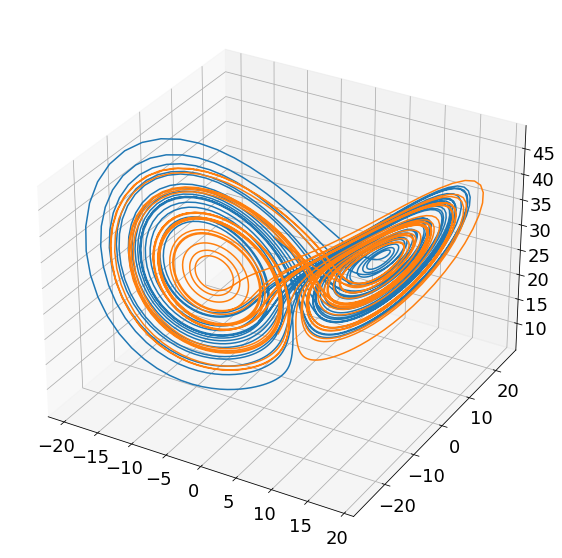

In [159]:
lpert =  LorenzTorch(sigma + 1, rho - 1, beta - 0.2, init=[-8, 8, 28], dt=1e-2, param_grads=True)

lpert.integrate(3000)

plot_attractor([ltrue.hist, lpert.hist])


In [160]:
loss = mse(stack_state(ltrue), stack_state(lpert))
loss

tensor(5.8959, grad_fn=<MeanBackward0>)

Above is the loss, using MeanSquaredError. 

In [161]:
loss.backward()

lpert.sigma.grad, lpert.rho.grad, lpert.beta.grad

(tensor([1.2501e+13]), tensor([-1.6889e+13]), tensor([3.7288e+11]))

Above the gradient is computed with respect to the parameters $\beta, \sigma, \rho$ and they've been computed back over the integration time which is 3000 in this case.

In [162]:
true_params = [sigma, rho, beta]
pert_params = [sigma + 1, rho - 2, beta - 0.5]

In [163]:
h = learning_loop(true_params, pert_params, 1e-2, 50, 300)

  2%|▏         | 7/300 [00:00<00:04, 62.71it/s]

Loss:  tensor(3.3329, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5612, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8218, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0987, grad_fn=<MeanBackward0>)
Loss:  tensor(21.0570, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8535, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3275, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1001, grad_fn=<MeanBackward0>)
Loss:  tensor(71.8584, grad_fn=<MeanBackward0>)
Loss:  tensor(63.3315, grad_fn=<MeanBackward0>)


  7%|▋         | 20/300 [00:00<00:05, 50.60it/s]

Loss:  tensor(0.1023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5160, grad_fn=<MeanBackward0>)
Loss:  tensor(12.1811, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0388, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3807, grad_fn=<MeanBackward0>)
Loss:  tensor(29.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9443, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4956, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0760, grad_fn=<MeanBackward0>)


 11%|█         | 33/300 [00:00<00:04, 56.18it/s]

Loss:  tensor(3.3217, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1859, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0702, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3870, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6576, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1248, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1112, grad_fn=<MeanBackward0>)


 15%|█▌        | 45/300 [00:00<00:04, 55.10it/s]

Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9842, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0593, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1477, grad_fn=<MeanBackward0>)


 17%|█▋        | 52/300 [00:00<00:04, 58.91it/s]

Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2891, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3367, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1429, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6708, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2641, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0503, grad_fn=<MeanBackward0>)
Loss:  

 21%|██▏       | 64/300 [00:01<00:04, 50.77it/s]

tensor(0.2032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2884, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0951, grad_fn=<MeanBackward0>)


 25%|██▌       | 75/300 [00:01<00:04, 47.66it/s]

Loss:  tensor(0.0480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0744, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4057, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7607, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1737, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0457, grad_fn=<MeanBackward0>)


 28%|██▊       | 85/300 [00:01<00:04, 45.38it/s]

Loss:  tensor(0.6821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)


 30%|███       | 90/300 [00:01<00:05, 41.57it/s]

Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0655, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0539, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0292, grad_fn=<MeanBackward0>)


 34%|███▍      | 103/300 [00:02<00:03, 51.57it/s]

Loss:  tensor(0.2407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0936, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0618, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2625, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0736, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0913, grad_fn=<MeanBackward0>)


 39%|███▊      | 116/300 [00:02<00:03, 48.95it/s]

Loss:  tensor(0.0433, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4448, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0762, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3342, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2055, grad_fn=<MeanBackward0>)


 41%|████▏     | 124/300 [00:02<00:03, 55.55it/s]

Loss:  tensor(0.2572, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1648, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)


 45%|████▌     | 135/300 [00:02<00:04, 41.22it/s]

Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)


 47%|████▋     | 140/300 [00:03<00:04, 33.26it/s]

Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 51%|█████▏    | 154/300 [00:03<00:03, 46.85it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1262, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0915e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/300 [00:03<00:02, 59.65it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)


 59%|█████▉    | 177/300 [00:03<00:02, 57.36it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8578e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 64%|██████▎   | 191/300 [00:03<00:01, 60.87it/s]

Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7045e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4644e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9482e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2964e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0852e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1845e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6230e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 69%|██████▉   | 207/300 [00:04<00:01, 65.51it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1453e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8897e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7686e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/300 [00:04<00:01, 71.17it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2995e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2748e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5476e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7914e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5247e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2651e-05, grad_fn=<MeanBackward0>)


 80%|████████  | 240/300 [00:04<00:00, 75.10it/s]

Loss:  tensor(5.8873e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5073e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7268e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8213e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5953e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9047e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2447e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2294e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4801e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7351e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)

 86%|████████▌ | 257/300 [00:04<00:00, 65.83it/s]


Loss:  tensor(4.6787e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4103e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3426e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1393e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7930e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0758e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0919e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 88%|████████▊ | 265/300 [00:04<00:00, 67.41it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0739e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3287e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1879e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3912e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3433e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0334e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1206e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0187e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5491e-05, grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/300 [00:05<00:00, 66.49it/s]

Loss:  tensor(7.4625e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7098e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0558e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1847e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2949e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3416e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9287e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2097e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7261e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0022e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4380e-06, grad_fn=<MeanBackward0>)


100%|██████████| 300/300 [00:05<00:00, 56.32it/s]

Loss:  tensor(1.3154e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1081e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2650e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5564e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7143e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5950e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1733e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6106e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8172e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0990e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1617e-05, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(3.1617e-05, grad_fn=<MeanBackward0>)


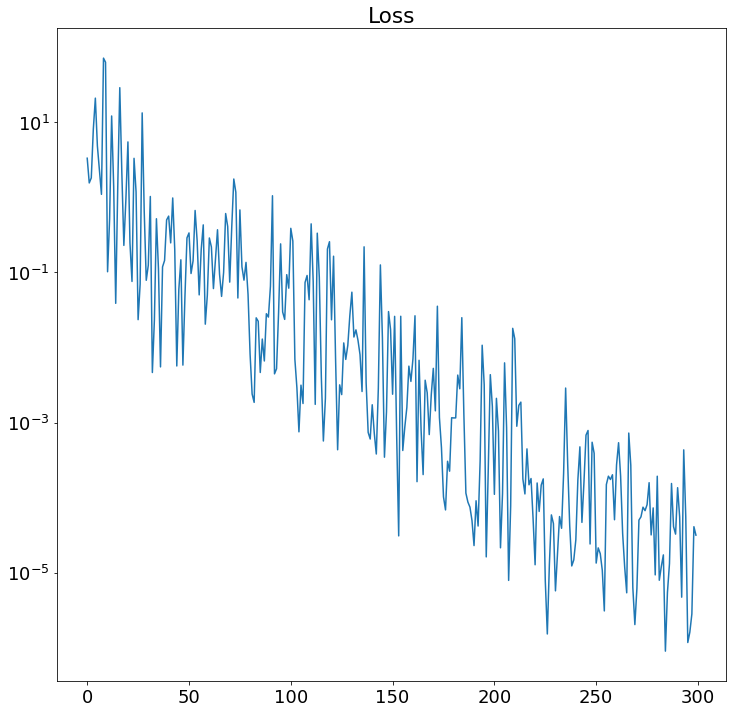

In [164]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

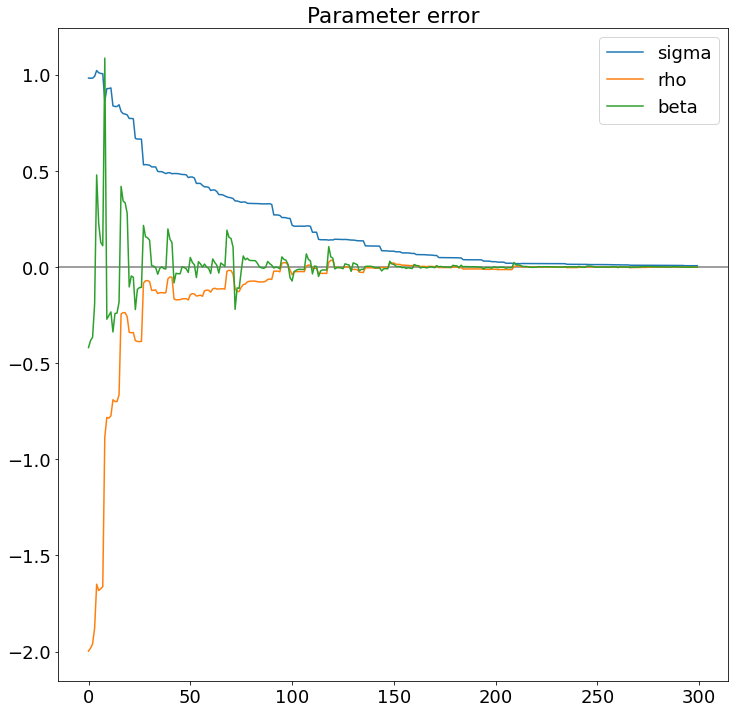

In [165]:
plot_params(h)

In [166]:
h = learning_loop(true_params, pert_params, 1e-2, 100, 300)

  1%|▏         | 4/300 [00:00<00:09, 30.71it/s]

Loss:  tensor(3.3627, grad_fn=<MeanBackward0>)
Loss:  tensor(23.7452, grad_fn=<MeanBackward0>)
Loss:  tensor(19.6128, grad_fn=<MeanBackward0>)
Loss:  tensor(62.3040, grad_fn=<MeanBackward0>)
Loss:  tensor(34.7489, grad_fn=<MeanBackward0>)


  3%|▎         | 8/300 [00:00<00:12, 22.85it/s]

Loss:  tensor(16.7376, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2337, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0530, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6887, grad_fn=<MeanBackward0>)
Loss:  tensor(72.5630, grad_fn=<MeanBackward0>)


  5%|▍         | 14/300 [00:00<00:11, 25.45it/s]

Loss:  tensor(0.1682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3334, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5200, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7659, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6935, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0502, grad_fn=<MeanBackward0>)
Loss:  tensor(31.9016, grad_fn=<MeanBackward0>)


  7%|▋         | 21/300 [00:00<00:11, 23.40it/s]

Loss:  tensor(95791.8984, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


  9%|▉         | 27/300 [00:01<00:10, 25.75it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 11%|█         | 33/300 [00:01<00:10, 24.38it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 13%|█▎        | 39/300 [00:01<00:10, 25.36it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 15%|█▌        | 45/300 [00:01<00:09, 25.65it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 16%|█▌        | 48/300 [00:01<00:09, 25.35it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 17%|█▋        | 51/300 [00:02<00:10, 23.56it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 19%|█▉        | 57/300 [00:02<00:13, 18.25it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 21%|██        | 62/300 [00:02<00:12, 18.84it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 23%|██▎       | 68/300 [00:02<00:10, 21.91it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 25%|██▍       | 74/300 [00:03<00:09, 25.01it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 26%|██▌       | 78/300 [00:03<00:08, 26.28it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 28%|██▊       | 85/300 [00:03<00:07, 27.58it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 30%|███       | 91/300 [00:03<00:07, 26.33it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 32%|███▏      | 97/300 [00:04<00:07, 27.07it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 35%|███▌      | 105/300 [00:04<00:06, 29.58it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 37%|███▋      | 112/300 [00:04<00:05, 31.68it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 40%|████      | 120/300 [00:04<00:05, 32.89it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 43%|████▎     | 128/300 [00:04<00:04, 34.43it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 45%|████▌     | 136/300 [00:05<00:04, 35.34it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 48%|████▊     | 144/300 [00:05<00:04, 35.49it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 51%|█████     | 152/300 [00:05<00:04, 35.77it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 52%|█████▏    | 156/300 [00:05<00:04, 35.37it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/300 [00:06<00:04, 33.73it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 57%|█████▋    | 172/300 [00:06<00:03, 32.76it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 60%|██████    | 180/300 [00:06<00:03, 34.13it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 63%|██████▎   | 188/300 [00:06<00:03, 35.20it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 65%|██████▌   | 196/300 [00:06<00:03, 32.81it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/300 [00:07<00:02, 35.61it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 69%|██████▉   | 208/300 [00:07<00:02, 35.87it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 71%|███████   | 212/300 [00:07<00:03, 29.15it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 73%|███████▎  | 219/300 [00:07<00:03, 26.24it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 75%|███████▌  | 226/300 [00:08<00:02, 25.66it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 76%|███████▋  | 229/300 [00:08<00:02, 24.26it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 78%|███████▊  | 235/300 [00:08<00:02, 22.83it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 80%|████████  | 241/300 [00:08<00:02, 22.77it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 83%|████████▎ | 248/300 [00:08<00:01, 27.34it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 84%|████████▎ | 251/300 [00:09<00:01, 27.75it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 86%|████████▌ | 257/300 [00:09<00:01, 24.15it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 88%|████████▊ | 264/300 [00:09<00:01, 27.44it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 91%|█████████ | 272/300 [00:09<00:00, 31.01it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 93%|█████████▎| 280/300 [00:10<00:00, 30.98it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/300 [00:10<00:00, 28.22it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/300 [00:10<00:00, 26.11it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 99%|█████████▉| 297/300 [00:10<00:00, 30.06it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


100%|██████████| 300/300 [00:10<00:00, 27.89it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(nan, grad_fn=<MeanBackward0>)


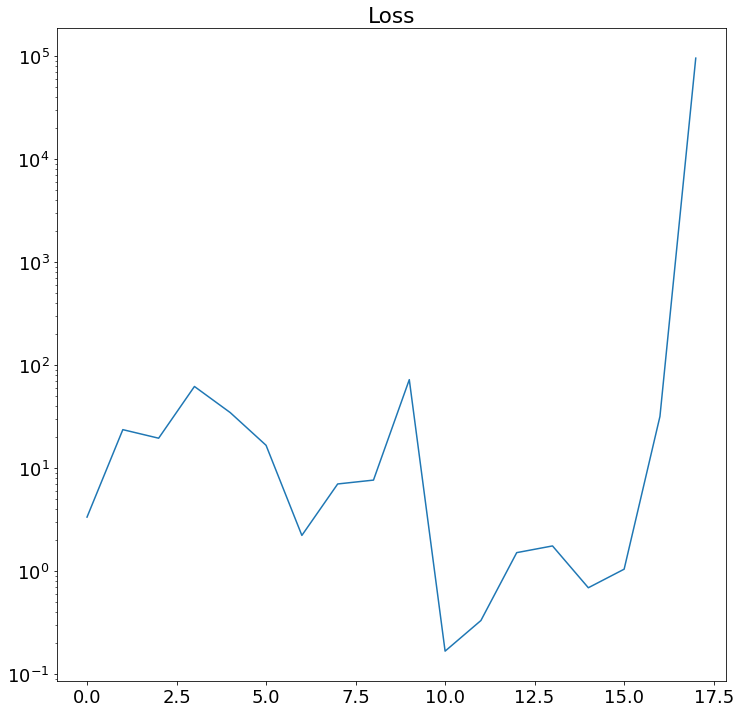

In [167]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

In [168]:
h = learning_loop(true_params, pert_params, 1e-4, 75, 5000)

  0%|          | 5/5000 [00:00<01:40, 49.46it/s]

Loss:  tensor(15.5410, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9308, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2554, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1935, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4732, grad_fn=<MeanBackward0>)
Loss:  tensor(83.3554, grad_fn=<MeanBackward0>)
Loss:  tensor(28.4622, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8240, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4251, grad_fn=<MeanBackward0>)


  0%|          | 15/5000 [00:00<02:04, 40.00it/s]

Loss:  tensor(3.4701, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4361, grad_fn=<MeanBackward0>)
Loss:  tensor(34.8923, grad_fn=<MeanBackward0>)
Loss:  tensor(444.3483, grad_fn=<MeanBackward0>)
Loss:  tensor(20.8261, grad_fn=<MeanBackward0>)
Loss:  tensor(235.8286, grad_fn=<MeanBackward0>)
Loss:  tensor(408.0915, grad_fn=<MeanBackward0>)
Loss:  tensor(11.3321, grad_fn=<MeanBackward0>)


  0%|          | 25/5000 [00:00<02:00, 41.22it/s]

Loss:  tensor(5.4294, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8388, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7834, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3773, grad_fn=<MeanBackward0>)
Loss:  tensor(42.6571, grad_fn=<MeanBackward0>)
Loss:  tensor(19.0652, grad_fn=<MeanBackward0>)
Loss:  tensor(136.5593, grad_fn=<MeanBackward0>)
Loss:  tensor(10.6239, grad_fn=<MeanBackward0>)
Loss:  tensor(56.4978, grad_fn=<MeanBackward0>)


  1%|          | 30/5000 [00:00<02:11, 37.75it/s]

Loss:  tensor(14.9257, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2339, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5989, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6265, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3839, grad_fn=<MeanBackward0>)
Loss:  tensor(29.9548, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0746, grad_fn=<MeanBackward0>)


  1%|          | 38/5000 [00:00<02:16, 36.29it/s]

Loss:  tensor(17.1749, grad_fn=<MeanBackward0>)
Loss:  tensor(386.5962, grad_fn=<MeanBackward0>)
Loss:  tensor(10.9915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2179, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0341, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5960, grad_fn=<MeanBackward0>)


  1%|          | 42/5000 [00:01<02:44, 30.08it/s]

Loss:  tensor(4.6722, grad_fn=<MeanBackward0>)
Loss:  tensor(107.0997, grad_fn=<MeanBackward0>)
Loss:  tensor(86.5914, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9554, grad_fn=<MeanBackward0>)
Loss:  tensor(127.2208, grad_fn=<MeanBackward0>)


  1%|          | 46/5000 [00:01<03:27, 23.89it/s]

Loss:  tensor(492.4839, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6664, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0052, grad_fn=<MeanBackward0>)


  1%|          | 53/5000 [00:01<03:08, 26.31it/s]

Loss:  tensor(3.6080, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6354, grad_fn=<MeanBackward0>)
Loss:  tensor(49.6959, grad_fn=<MeanBackward0>)
Loss:  tensor(53.4532, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7636, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2673, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0362, grad_fn=<MeanBackward0>)
Loss:  tensor(15.7398, grad_fn=<MeanBackward0>)
Loss:  tensor(16.3579, grad_fn=<MeanBackward0>)


  1%|          | 62/5000 [00:01<02:48, 29.24it/s]

Loss:  tensor(4.6929, grad_fn=<MeanBackward0>)
Loss:  tensor(521.7112, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5758, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5541, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2247, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6148, grad_fn=<MeanBackward0>)


  1%|▏         | 71/5000 [00:02<02:25, 33.90it/s]

Loss:  tensor(1.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2936, grad_fn=<MeanBackward0>)
Loss:  tensor(18.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(36.5758, grad_fn=<MeanBackward0>)
Loss:  tensor(24.6394, grad_fn=<MeanBackward0>)
Loss:  tensor(28.6294, grad_fn=<MeanBackward0>)
Loss:  tensor(283.8635, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6032, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6170, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8706, grad_fn=<MeanBackward0>)


  2%|▏         | 82/5000 [00:02<01:59, 41.25it/s]

Loss:  tensor(1.8974, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5022, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4711, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4392, grad_fn=<MeanBackward0>)
Loss:  tensor(441.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5625, grad_fn=<MeanBackward0>)
Loss:  tensor(64.1643, grad_fn=<MeanBackward0>)
Loss:  tensor(100.8328, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0467, grad_fn=<MeanBackward0>)


  2%|▏         | 93/5000 [00:02<01:52, 43.49it/s]

Loss:  tensor(5.8054, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9896, grad_fn=<MeanBackward0>)
Loss:  tensor(33.0693, grad_fn=<MeanBackward0>)
Loss:  tensor(31.9228, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5987, grad_fn=<MeanBackward0>)
Loss:  tensor(14.9165, grad_fn=<MeanBackward0>)
Loss:  tensor(11.7113, grad_fn=<MeanBackward0>)
Loss:  tensor(43.3783, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1615, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5983, grad_fn=<MeanBackward0>)


  2%|▏         | 104/5000 [00:02<01:40, 48.57it/s]

Loss:  tensor(2.4015, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3893, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4072, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9288, grad_fn=<MeanBackward0>)
Loss:  tensor(124.7455, grad_fn=<MeanBackward0>)
Loss:  tensor(18.8623, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3064, grad_fn=<MeanBackward0>)
Loss:  tensor(548.5799, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3376, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5826, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4444, grad_fn=<MeanBackward0>)


  2%|▏         | 110/5000 [00:02<01:38, 49.45it/s]

Loss:  tensor(2.9282, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5982, grad_fn=<MeanBackward0>)
Loss:  tensor(47.8485, grad_fn=<MeanBackward0>)
Loss:  tensor(16.6419, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4131, grad_fn=<MeanBackward0>)
Loss:  tensor(600.2093, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7519, grad_fn=<MeanBackward0>)
Loss:  tensor(69.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0971, grad_fn=<MeanBackward0>)


  2%|▏         | 121/5000 [00:03<01:40, 48.77it/s]

Loss:  tensor(2.9164, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8384, grad_fn=<MeanBackward0>)
Loss:  tensor(30.3586, grad_fn=<MeanBackward0>)
Loss:  tensor(109.2115, grad_fn=<MeanBackward0>)
Loss:  tensor(18.2415, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2173, grad_fn=<MeanBackward0>)
Loss:  tensor(679.3102, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(111.8210, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0483, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3435, grad_fn=<MeanBackward0>)


  3%|▎         | 132/5000 [00:03<01:42, 47.42it/s]

Loss:  tensor(1.7654, grad_fn=<MeanBackward0>)
Loss:  tensor(12.2888, grad_fn=<MeanBackward0>)
Loss:  tensor(37.9376, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1520, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6924, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0620, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8837, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6858, grad_fn=<MeanBackward0>)


  3%|▎         | 142/5000 [00:03<01:46, 45.66it/s]

Loss:  tensor(2.6468, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7245, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5004, grad_fn=<MeanBackward0>)
Loss:  tensor(19.2445, grad_fn=<MeanBackward0>)
Loss:  tensor(22.9738, grad_fn=<MeanBackward0>)
Loss:  tensor(10.9457, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4846, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5402, grad_fn=<MeanBackward0>)


  3%|▎         | 152/5000 [00:03<01:46, 45.32it/s]

Loss:  tensor(121.9682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2215, grad_fn=<MeanBackward0>)
Loss:  tensor(23.0930, grad_fn=<MeanBackward0>)
Loss:  tensor(53.6777, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5627, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2405, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2132, grad_fn=<MeanBackward0>)


  3%|▎         | 158/5000 [00:03<01:42, 47.36it/s]

Loss:  tensor(0.8989, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8671, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1165, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0459, grad_fn=<MeanBackward0>)
Loss:  tensor(53.9158, grad_fn=<MeanBackward0>)
Loss:  tensor(17.2639, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7904, grad_fn=<MeanBackward0>)
Loss:  tensor(906.5029, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3720, grad_fn=<MeanBackward0>)
Loss:  tensor(21.8555, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8812, grad_fn=<MeanBackward0>)


  3%|▎         | 169/5000 [00:04<01:38, 49.09it/s]

Loss:  tensor(0.9989, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9178, grad_fn=<MeanBackward0>)
Loss:  tensor(29.7285, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7543, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6047, grad_fn=<MeanBackward0>)
Loss:  tensor(299.4225, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9698, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9087, grad_fn=<MeanBackward0>)


  4%|▎         | 181/5000 [00:04<01:34, 51.12it/s]

Loss:  tensor(2.6798, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4504, grad_fn=<MeanBackward0>)
Loss:  tensor(28.1611, grad_fn=<MeanBackward0>)
Loss:  tensor(41.9664, grad_fn=<MeanBackward0>)
Loss:  tensor(149.0596, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6706, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9930, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5138, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3997, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0979, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2123, grad_fn=<MeanBackward0>)


  4%|▍         | 193/5000 [00:04<01:40, 48.00it/s]

Loss:  tensor(3.2896, grad_fn=<MeanBackward0>)
Loss:  tensor(750.1484, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6764, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0884, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2937, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9933, grad_fn=<MeanBackward0>)
Loss:  tensor(14.8543, grad_fn=<MeanBackward0>)


  4%|▍         | 198/5000 [00:04<01:43, 46.30it/s]

Loss:  tensor(7.7473, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8178, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7498, grad_fn=<MeanBackward0>)
Loss:  tensor(68.3955, grad_fn=<MeanBackward0>)
Loss:  tensor(34.3320, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3775, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0687, grad_fn=<MeanBackward0>)


  4%|▍         | 208/5000 [00:05<01:53, 42.16it/s]

Loss:  tensor(0.8030, grad_fn=<MeanBackward0>)
Loss:  tensor(29.7814, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9507, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1689, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5285, grad_fn=<MeanBackward0>)
Loss:  tensor(58.1994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9309, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5624, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1648, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6911, grad_fn=<MeanBackward0>)


  4%|▍         | 219/5000 [00:05<01:54, 41.75it/s]

Loss:  tensor(1.5127, grad_fn=<MeanBackward0>)
Loss:  tensor(25.7976, grad_fn=<MeanBackward0>)
Loss:  tensor(12.9347, grad_fn=<MeanBackward0>)
Loss:  tensor(118.2546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7074, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5159, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4018, grad_fn=<MeanBackward0>)


  4%|▍         | 224/5000 [00:05<02:31, 31.58it/s]

Loss:  tensor(0.7644, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9115, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5931, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2484, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9650, grad_fn=<MeanBackward0>)


  5%|▍         | 233/5000 [00:05<02:20, 33.96it/s]

Loss:  tensor(6.4557, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7498, grad_fn=<MeanBackward0>)
Loss:  tensor(42.8208, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(467.4612, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1567, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4591, grad_fn=<MeanBackward0>)
Loss:  tensor(18.4090, grad_fn=<MeanBackward0>)


  5%|▍         | 242/5000 [00:06<02:11, 36.27it/s]

Loss:  tensor(14.7763, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9775, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8981, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9214, grad_fn=<MeanBackward0>)
Loss:  tensor(527.5563, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0595, grad_fn=<MeanBackward0>)
Loss:  tensor(431.3518, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0034, grad_fn=<MeanBackward0>)


  5%|▌         | 252/5000 [00:06<01:53, 41.96it/s]

Loss:  tensor(0.2385, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1203, grad_fn=<MeanBackward0>)
Loss:  tensor(22.5838, grad_fn=<MeanBackward0>)
Loss:  tensor(65.2489, grad_fn=<MeanBackward0>)
Loss:  tensor(27.4683, grad_fn=<MeanBackward0>)
Loss:  tensor(165.9658, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4890, grad_fn=<MeanBackward0>)
Loss:  tensor(243.8824, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(341.8973, grad_fn=<MeanBackward0>)


  5%|▌         | 262/5000 [00:06<01:48, 43.52it/s]

Loss:  tensor(1.5516, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1105, grad_fn=<MeanBackward0>)
Loss:  tensor(32.3056, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4559, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6669, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0946, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0602, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7069, grad_fn=<MeanBackward0>)


  5%|▌         | 272/5000 [00:06<01:44, 45.45it/s]

Loss:  tensor(1.6993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3585, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4392, grad_fn=<MeanBackward0>)
Loss:  tensor(21.1587, grad_fn=<MeanBackward0>)
Loss:  tensor(133.5174, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2852, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5884, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6226, grad_fn=<MeanBackward0>)


  6%|▌         | 278/5000 [00:06<01:39, 47.60it/s]

Loss:  tensor(1.3040, grad_fn=<MeanBackward0>)
Loss:  tensor(38.3385, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1400, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2630, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2612, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6803, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3793, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3007, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8756, grad_fn=<MeanBackward0>)
Loss:  tensor(51.4986, grad_fn=<MeanBackward0>)
Loss:  

  6%|▌         | 290/5000 [00:07<01:33, 50.49it/s]

tensor(19.1009, grad_fn=<MeanBackward0>)
Loss:  tensor(38.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6566, grad_fn=<MeanBackward0>)
Loss:  tensor(199.6124, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0316, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9858, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0634, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2653, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2943, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2046, grad_fn=<MeanBackward0>)
Loss:  

  6%|▌         | 302/5000 [00:07<01:30, 52.08it/s]

tensor(6.4145, grad_fn=<MeanBackward0>)
Loss:  tensor(821.1870, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9128, grad_fn=<MeanBackward0>)
Loss:  tensor(64.8152, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1133, grad_fn=<MeanBackward0>)
Loss:  tensor(370.5893, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3815, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4383, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6260, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4378, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3271, grad_fn=<MeanBackward0>)


  6%|▋         | 314/5000 [00:07<01:34, 49.81it/s]

Loss:  tensor(0.3782, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9133, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2289, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7701, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4088, grad_fn=<MeanBackward0>)
Loss:  tensor(67.3621, grad_fn=<MeanBackward0>)
Loss:  tensor(21.7375, grad_fn=<MeanBackward0>)
Loss:  tensor(293.6694, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8786, grad_fn=<MeanBackward0>)
Loss: 

  7%|▋         | 326/5000 [00:07<01:28, 53.01it/s]

 tensor(2.4536, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3227, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4184, grad_fn=<MeanBackward0>)
Loss:  tensor(72.5753, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7482, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1151, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2093, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3527, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1211, grad_fn=<MeanBackward0>)


  7%|▋         | 332/5000 [00:07<01:28, 52.96it/s]

Loss:  tensor(3.3697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8350, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2794, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9738, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5482, grad_fn=<MeanBackward0>)
Loss:  tensor(482.5715, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0773, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0362, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0335, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2724, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3767, grad_fn=<MeanBackward0>)
Loss:  

  7%|▋         | 344/5000 [00:08<01:28, 52.79it/s]

tensor(18.7448, grad_fn=<MeanBackward0>)
Loss:  tensor(46.9414, grad_fn=<MeanBackward0>)
Loss:  tensor(73.7387, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1971, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8351, grad_fn=<MeanBackward0>)
Loss:  tensor(33.8774, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4051, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6869, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1429, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0247, grad_fn=<MeanBackward0>)
Loss:  tensor(16.2982, grad_fn=<MeanBackward0>)


  7%|▋         | 356/5000 [00:08<01:26, 53.99it/s]

Loss:  tensor(18.7958, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5488, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2095, grad_fn=<MeanBackward0>)
Loss:  tensor(299.5846, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1823, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1991, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9202, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(10.3628, grad_fn=<MeanBackward0>)


  7%|▋         | 368/5000 [00:08<01:33, 49.50it/s]

Loss:  tensor(6.2724, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1521, grad_fn=<MeanBackward0>)
Loss:  tensor(349.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3736, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6873, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6602, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8422, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3137, grad_fn=<MeanBackward0>)
Loss:  

  8%|▊         | 380/5000 [00:08<01:27, 53.08it/s]

tensor(1.3107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8635, grad_fn=<MeanBackward0>)
Loss:  tensor(144.7932, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6209, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4745, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2710, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5859, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3598, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2634, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7897, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2828, grad_fn=<MeanBackward0>)


  8%|▊         | 392/5000 [00:08<01:26, 53.47it/s]

Loss:  tensor(12.9333, grad_fn=<MeanBackward0>)
Loss:  tensor(330.6698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7962, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3509, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5399, grad_fn=<MeanBackward0>)
Loss:  tensor(38.5999, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4462, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6613, grad_fn=<MeanBackward0>)
Loss:  tensor(326.7231, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2913, grad_fn=<MeanBackward0>)


  8%|▊         | 404/5000 [00:09<01:24, 54.45it/s]

Loss:  tensor(0.5920, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2938, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0850, grad_fn=<MeanBackward0>)
Loss:  tensor(17.8709, grad_fn=<MeanBackward0>)
Loss:  tensor(45.5850, grad_fn=<MeanBackward0>)
Loss:  tensor(16.9029, grad_fn=<MeanBackward0>)
Loss:  tensor(312.9336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7661, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0953, grad_fn=<MeanBackward0>)
Loss:  tensor(667.9941, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1702, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1477, grad_fn=<MeanBackward0>)


  8%|▊         | 410/5000 [00:09<01:24, 54.01it/s]

Loss:  tensor(0.2009, grad_fn=<MeanBackward0>)
Loss:  tensor(15.4015, grad_fn=<MeanBackward0>)
Loss:  tensor(285.9804, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0683, grad_fn=<MeanBackward0>)
Loss:  tensor(27.4486, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2657, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1438, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5523, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2493, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5404, grad_fn=<MeanBackward0>)
Loss:  

  8%|▊         | 422/5000 [00:09<01:26, 53.00it/s]

tensor(0.2770, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3577, grad_fn=<MeanBackward0>)
Loss:  tensor(855.3882, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3694, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1617, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5971, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7468, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4673, grad_fn=<MeanBackward0>)
Loss:  tensor(20.2214, grad_fn=<MeanBackward0>)
Loss:  

  9%|▊         | 434/5000 [00:09<01:28, 51.82it/s]

tensor(25.0897, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1377, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0741, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4849, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9409, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9993, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3888, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1186, grad_fn=<MeanBackward0>)
Loss:  tensor(304.2271, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4645, grad_fn=<MeanBackward0>)


  9%|▉         | 445/5000 [00:10<01:34, 48.06it/s]

Loss:  tensor(0.9952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6067, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6359, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8162, grad_fn=<MeanBackward0>)
Loss:  tensor(12.9973, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6673, grad_fn=<MeanBackward0>)
Loss:  tensor(12.3817, grad_fn=<MeanBackward0>)
Loss:  tensor(669.4185, grad_fn=<MeanBackward0>)


  9%|▉         | 456/5000 [00:10<01:30, 50.33it/s]

Loss:  tensor(2.0547, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2705, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6094, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4566, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7105, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2058, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5306, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1053, grad_fn=<MeanBackward0>)
Loss:  tensor(71.7975, grad_fn=<MeanBackward0>)
Loss:  tensor(294.0776, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3399, grad_fn=<MeanBackward0>)


  9%|▉         | 462/5000 [00:10<01:33, 48.64it/s]

Loss:  tensor(1.0564, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5578, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7737, grad_fn=<MeanBackward0>)
Loss:  tensor(31.3873, grad_fn=<MeanBackward0>)
Loss:  tensor(13.8412, grad_fn=<MeanBackward0>)
Loss:  tensor(63.1445, grad_fn=<MeanBackward0>)
Loss:  tensor(43.7183, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7669, grad_fn=<MeanBackward0>)
Loss:  tensor(185.2787, grad_fn=<MeanBackward0>)


  9%|▉         | 472/5000 [00:10<01:43, 43.84it/s]

Loss:  tensor(0.7795, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7997, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9590, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8084, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8222, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5718, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5096, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7603, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3540, grad_fn=<MeanBackward0>)


 10%|▉         | 483/5000 [00:10<01:39, 45.44it/s]

Loss:  tensor(1.2981, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0590, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7609, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2265, grad_fn=<MeanBackward0>)
Loss:  tensor(72.3972, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8032, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(19.3647, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6688, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2569, grad_fn=<MeanBackward0>)


 10%|▉         | 494/5000 [00:11<01:33, 48.13it/s]

Loss:  tensor(2.5016, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0970, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8090, grad_fn=<MeanBackward0>)
Loss:  tensor(23.8709, grad_fn=<MeanBackward0>)
Loss:  tensor(204.1299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8907, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8651, grad_fn=<MeanBackward0>)
Loss:  tensor(12.4049, grad_fn=<MeanBackward0>)
Loss:  tensor(19.9004, grad_fn=<MeanBackward0>)


 10%|█         | 506/5000 [00:11<01:26, 52.12it/s]

Loss:  tensor(3.6584, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5286, grad_fn=<MeanBackward0>)
Loss:  tensor(106.8018, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5944, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1221, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7725, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6954, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3085, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7415, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5074, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1584, grad_fn=<MeanBackward0>)


 10%|█         | 518/5000 [00:11<01:25, 52.31it/s]

Loss:  tensor(0.4763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3447, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2578, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2781, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7129, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0465, grad_fn=<MeanBackward0>)
Loss:  tensor(375.1537, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5273, grad_fn=<MeanBackward0>)


 10%|█         | 524/5000 [00:11<01:25, 52.32it/s]

Loss:  tensor(4.7075, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5833, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3934, grad_fn=<MeanBackward0>)
Loss:  tensor(15.9322, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9910, grad_fn=<MeanBackward0>)
Loss:  tensor(38.7182, grad_fn=<MeanBackward0>)
Loss:  tensor(640.4753, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3764, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2529, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8544, grad_fn=<MeanBackward0>)
Loss:  

 11%|█         | 530/5000 [00:11<01:32, 48.53it/s]

tensor(9.6870, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1156, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8893, grad_fn=<MeanBackward0>)
Loss:  tensor(12.5071, grad_fn=<MeanBackward0>)


 11%|█         | 540/5000 [00:12<01:51, 40.13it/s]

Loss:  tensor(17.8220, grad_fn=<MeanBackward0>)
Loss:  tensor(144.6589, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1608, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9623, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4563, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6075, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1797, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4613, grad_fn=<MeanBackward0>)


 11%|█         | 550/5000 [00:12<01:47, 41.48it/s]

Loss:  tensor(85.3533, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4529, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1448, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7551, grad_fn=<MeanBackward0>)
Loss:  tensor(16.6409, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4930, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0314, grad_fn=<MeanBackward0>)


 11%|█         | 561/5000 [00:12<01:38, 45.09it/s]

Loss:  tensor(1.8191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2390, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8680, grad_fn=<MeanBackward0>)
Loss:  tensor(101.8532, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2433, grad_fn=<MeanBackward0>)
Loss:  tensor(14.3012, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2566, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0675, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1594, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5228, grad_fn=<MeanBackward0>)
Loss:  

 11%|█▏        | 573/5000 [00:12<01:27, 50.78it/s]

tensor(0.7335, grad_fn=<MeanBackward0>)
Loss:  tensor(20.1019, grad_fn=<MeanBackward0>)
Loss:  tensor(18.9199, grad_fn=<MeanBackward0>)
Loss:  tensor(42.7561, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4867, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1528, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8614, grad_fn=<MeanBackward0>)
Loss:  tensor(17.3370, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1813, grad_fn=<MeanBackward0>)


 12%|█▏        | 585/5000 [00:13<01:26, 50.97it/s]

Loss:  tensor(1.9807, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5616, grad_fn=<MeanBackward0>)
Loss:  tensor(545.4719, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2697, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5318, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1991, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6115, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6519, grad_fn=<MeanBackward0>)


 12%|█▏        | 597/5000 [00:13<01:22, 53.42it/s]

Loss:  tensor(18.2558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4482, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5354, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5139, grad_fn=<MeanBackward0>)
Loss:  tensor(28.4059, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1501, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1549, grad_fn=<MeanBackward0>)
Loss:  tensor(176.2095, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1787, grad_fn=<MeanBackward0>)
Loss:  tensor(10.4249, grad_fn=<MeanBackward0>)


 12%|█▏        | 603/5000 [00:13<01:24, 52.07it/s]

Loss:  tensor(0.6267, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9323, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5543, grad_fn=<MeanBackward0>)
Loss:  tensor(22.3474, grad_fn=<MeanBackward0>)
Loss:  tensor(34.4695, grad_fn=<MeanBackward0>)
Loss:  tensor(136.4260, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1055, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2020, grad_fn=<MeanBackward0>)
Loss:  tensor(17.6396, grad_fn=<MeanBackward0>)


 12%|█▏        | 609/5000 [00:13<01:36, 45.46it/s]

Loss:  tensor(1.0456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7836, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1767, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9531, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9158, grad_fn=<MeanBackward0>)
Loss:  tensor(13.4254, grad_fn=<MeanBackward0>)
Loss:  tensor(27.7318, grad_fn=<MeanBackward0>)


 12%|█▏        | 619/5000 [00:13<01:47, 40.74it/s]

Loss:  tensor(4.9425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2480, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7353, grad_fn=<MeanBackward0>)
Loss:  tensor(134.6373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5814, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4947, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2744, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2219, grad_fn=<MeanBackward0>)
Loss:  tensor(20.8781, grad_fn=<MeanBackward0>)


 13%|█▎        | 630/5000 [00:14<01:37, 44.73it/s]

Loss:  tensor(3.4957, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3376, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4259, grad_fn=<MeanBackward0>)
Loss:  tensor(38.8291, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2873, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0829, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5618, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7611, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9321, grad_fn=<MeanBackward0>)


 13%|█▎        | 642/5000 [00:14<01:26, 50.17it/s]

Loss:  tensor(0.3822, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3563, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2835, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3332, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6780, grad_fn=<MeanBackward0>)
Loss:  tensor(22.7012, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4571, grad_fn=<MeanBackward0>)
Loss:  tensor(61.1334, grad_fn=<MeanBackward0>)


 13%|█▎        | 654/5000 [00:14<01:23, 52.15it/s]

Loss:  tensor(0.8845, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3541, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3969, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3131, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9135, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9492, grad_fn=<MeanBackward0>)
Loss:  tensor(27.7088, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3555, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0583, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2494, grad_fn=<MeanBackward0>)


 13%|█▎        | 666/5000 [00:14<01:19, 54.40it/s]

Loss:  tensor(0.4409, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1550, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6635, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2374, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5937, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3401, grad_fn=<MeanBackward0>)
Loss:  tensor(22.5768, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5349, grad_fn=<MeanBackward0>)


 14%|█▎        | 678/5000 [00:14<01:18, 55.29it/s]

Loss:  tensor(0.2059, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8379, grad_fn=<MeanBackward0>)
Loss:  tensor(29.8244, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5332, grad_fn=<MeanBackward0>)
Loss:  tensor(23.8905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5753, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6272, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4654, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7036, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6920, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1462, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0536, grad_fn=<MeanBackward0>)


 14%|█▍        | 690/5000 [00:15<01:19, 54.14it/s]

Loss:  tensor(25.3348, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4085, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1145, grad_fn=<MeanBackward0>)
Loss:  tensor(23.5499, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9968, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1574, grad_fn=<MeanBackward0>)
Loss:  tensor(831.4068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6800, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7539, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5757, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2861, grad_fn=<MeanBackward0>)


 14%|█▍        | 702/5000 [00:15<01:18, 54.62it/s]

Loss:  tensor(0.4988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1980, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2199, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0410, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1790, grad_fn=<MeanBackward0>)
Loss:  tensor(14.1985, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4203, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1728, grad_fn=<MeanBackward0>)
Loss:  tensor(10.9725, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4384, grad_fn=<MeanBackward0>)
Loss:  tensor(14.4673, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7192, grad_fn=<MeanBackward0>)


 14%|█▍        | 708/5000 [00:15<01:20, 53.47it/s]

Loss:  tensor(0.9228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9314, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1667, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7152, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1889, grad_fn=<MeanBackward0>)
Loss:  tensor(12.2739, grad_fn=<MeanBackward0>)
Loss:  tensor(29.9894, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5665, grad_fn=<MeanBackward0>)
Loss:  tensor(51.6069, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1316, grad_fn=<MeanBackward0>)
Loss:  

 14%|█▍        | 714/5000 [00:15<01:21, 52.35it/s]

tensor(6.3048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6042, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5950, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6798, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2792, grad_fn=<MeanBackward0>)


 14%|█▍        | 725/5000 [00:15<01:36, 44.27it/s]

Loss:  tensor(1.0579, grad_fn=<MeanBackward0>)
Loss:  tensor(10.7074, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0861, grad_fn=<MeanBackward0>)
Loss:  tensor(12.8759, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2544, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1588, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7118, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7602, grad_fn=<MeanBackward0>)
Loss:  tensor(15.5372, grad_fn=<MeanBackward0>)
Loss:  tensor(22.5404, grad_fn=<MeanBackward0>)


 15%|█▍        | 736/5000 [00:16<01:29, 47.70it/s]

Loss:  tensor(2.8264, grad_fn=<MeanBackward0>)
Loss:  tensor(288.3500, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7500, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5579, grad_fn=<MeanBackward0>)
Loss:  tensor(10.6258, grad_fn=<MeanBackward0>)
Loss:  tensor(12.5245, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3695, grad_fn=<MeanBackward0>)


 15%|█▍        | 748/5000 [00:16<01:25, 49.95it/s]

Loss:  tensor(3.1594, grad_fn=<MeanBackward0>)
Loss:  tensor(66.6406, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7377, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0800, grad_fn=<MeanBackward0>)
Loss:  tensor(1011.0350, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4955, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5042, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1882, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6804, grad_fn=<MeanBackward0>)
Loss:  tensor(141.5955, grad_fn=<MeanBackward0>)


 15%|█▌        | 760/5000 [00:16<01:24, 50.14it/s]

Loss:  tensor(0.5713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3563, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1185, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4392, grad_fn=<MeanBackward0>)
Loss:  tensor(22.7716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7140, grad_fn=<MeanBackward0>)
Loss:  tensor(391.8985, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4901, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4356, grad_fn=<MeanBackward0>)
Loss:  

 15%|█▌        | 772/5000 [00:16<01:21, 52.09it/s]

tensor(1.0705, grad_fn=<MeanBackward0>)
Loss:  tensor(21.6419, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4884, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3013, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8816, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1689, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0492, grad_fn=<MeanBackward0>)


 16%|█▌        | 784/5000 [00:17<01:25, 49.48it/s]

Loss:  tensor(4.5837, grad_fn=<MeanBackward0>)
Loss:  tensor(33.1846, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4633, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1809, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0609, grad_fn=<MeanBackward0>)
Loss:  tensor(1111.4747, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1503, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3699, grad_fn=<MeanBackward0>)


 16%|█▌        | 795/5000 [00:17<01:22, 51.01it/s]

Loss:  tensor(31.2578, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9916, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7679, grad_fn=<MeanBackward0>)
Loss:  tensor(11.4546, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0345, grad_fn=<MeanBackward0>)
Loss:  tensor(305.8947, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0683, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9959, grad_fn=<MeanBackward0>)
Loss:  tensor(42.0651, grad_fn=<MeanBackward0>)


 16%|█▌        | 807/5000 [00:17<01:21, 51.66it/s]

Loss:  tensor(2.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3391, grad_fn=<MeanBackward0>)
Loss:  tensor(215.4942, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1699, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1292, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8748, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2375, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5947, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1944, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5150, grad_fn=<MeanBackward0>)
Loss:  tensor(327.0059, grad_fn=<MeanBackward0>)


 16%|█▋        | 819/5000 [00:17<01:16, 54.55it/s]

Loss:  tensor(1.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4199, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2844, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6382, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2724, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1593, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2796, grad_fn=<MeanBackward0>)


 17%|█▋        | 831/5000 [00:17<01:15, 55.13it/s]

Loss:  tensor(7.0291, grad_fn=<MeanBackward0>)
Loss:  tensor(65.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3356, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7269, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5580, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8820, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6569, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7666, grad_fn=<MeanBackward0>)


 17%|█▋        | 843/5000 [00:18<01:16, 54.41it/s]

Loss:  tensor(19.7814, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0919, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6484, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2534, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0492, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5143, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3496, grad_fn=<MeanBackward0>)


 17%|█▋        | 849/5000 [00:18<01:17, 53.24it/s]

Loss:  tensor(0.3184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5670, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0948, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3675, grad_fn=<MeanBackward0>)


 17%|█▋        | 860/5000 [00:18<01:41, 40.88it/s]

Loss:  tensor(0.1143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2407, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5886, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8859, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7617, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6301, grad_fn=<MeanBackward0>)


 17%|█▋        | 871/5000 [00:18<01:31, 45.36it/s]

Loss:  tensor(1.6159, grad_fn=<MeanBackward0>)
Loss:  tensor(297.8023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8563, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6719, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4000, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4854, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6563, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3485, grad_fn=<MeanBackward0>)
Loss:  tensor(21.5475, grad_fn=<MeanBackward0>)


 18%|█▊        | 877/5000 [00:18<01:26, 47.73it/s]

Loss:  tensor(0.3784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3751, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3373, grad_fn=<MeanBackward0>)
Loss:  tensor(60.1322, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2155, grad_fn=<MeanBackward0>)
Loss:  tensor(788.7925, grad_fn=<MeanBackward0>)


 18%|█▊        | 895/5000 [00:19<01:16, 53.80it/s]

Loss:  tensor(0.0695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1462, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6564, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6610, grad_fn=<MeanBackward0>)
Loss:  tensor(34.3007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2105, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6463, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5607, grad_fn=<MeanBackward0>)


 18%|█▊        | 901/5000 [00:19<01:15, 54.10it/s]

Loss:  tensor(1.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3582, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9697, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9949, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4144, grad_fn=<MeanBackward0>)


 18%|█▊        | 913/5000 [00:19<01:18, 51.99it/s]

Loss:  tensor(3.2747, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9506, grad_fn=<MeanBackward0>)
Loss:  tensor(17.9949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8594, grad_fn=<MeanBackward0>)
Loss:  tensor(13.0629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1493, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7882, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4779, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5947, grad_fn=<MeanBackward0>)


 18%|█▊        | 925/5000 [00:19<01:17, 52.79it/s]

Loss:  tensor(0.7314, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0561, grad_fn=<MeanBackward0>)
Loss:  tensor(67.3624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6153, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3549, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7643, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3076, grad_fn=<MeanBackward0>)


 19%|█▊        | 937/5000 [00:20<01:15, 53.81it/s]

Loss:  tensor(0.3986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1429, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3245, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4747, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2776, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3297, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2288, grad_fn=<MeanBackward0>)


 19%|█▉        | 949/5000 [00:20<01:14, 54.67it/s]

Loss:  tensor(1.8729, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2643, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0904, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2877, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5877, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5597, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7083, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6651, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2691, grad_fn=<MeanBackward0>)
Loss:  

 19%|█▉        | 961/5000 [00:20<01:14, 54.33it/s]

tensor(0.2602, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0842, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6566, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1761, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2050, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1107, grad_fn=<MeanBackward0>)
Loss:  tensor(66.7752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3856, grad_fn=<MeanBackward0>)


 19%|█▉        | 967/5000 [00:20<01:16, 52.97it/s]

Loss:  tensor(0.5253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0632, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3689, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(38.6193, grad_fn=<MeanBackward0>)


 20%|█▉        | 979/5000 [00:20<01:15, 53.52it/s]

Loss:  tensor(0.1500, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0335, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1533, grad_fn=<MeanBackward0>)
Loss:  tensor(19.8938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1400, grad_fn=<MeanBackward0>)
Loss:  tensor(80.4918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1465, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6036, grad_fn=<MeanBackward0>)


 20%|█▉        | 991/5000 [00:21<01:16, 52.46it/s]

Loss:  tensor(1.7192, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3556, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7623, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5649, grad_fn=<MeanBackward0>)
Loss:  tensor(846.8147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1876, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0359, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3080, grad_fn=<MeanBackward0>)


 20%|██        | 1003/5000 [00:21<01:13, 54.36it/s]

Loss:  tensor(1.1921, grad_fn=<MeanBackward0>)
Loss:  tensor(16.5534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2458, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4649, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0476, grad_fn=<MeanBackward0>)
Loss:  tensor(46.8734, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0328, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7111, grad_fn=<MeanBackward0>)
Loss:  tensor(12.5451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1203, grad_fn=<MeanBackward0>)
Loss:  tensor(156.1023, grad_fn=<MeanBackward0>)


 20%|██        | 1015/5000 [00:21<01:13, 54.20it/s]

Loss:  tensor(0.5842, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7635, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6234, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7941, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0987, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1990, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1721, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8477, grad_fn=<MeanBackward0>)


 21%|██        | 1027/5000 [00:21<01:13, 54.09it/s]

Loss:  tensor(0.7876, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7737, grad_fn=<MeanBackward0>)
Loss:  tensor(36.6096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8494, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8402, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3772, grad_fn=<MeanBackward0>)
Loss:  tensor(10.4994, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8785, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6905, grad_fn=<MeanBackward0>)


 21%|██        | 1039/5000 [00:21<01:12, 54.43it/s]

Loss:  tensor(0.7245, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7811, grad_fn=<MeanBackward0>)
Loss:  tensor(99.9056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6398, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2730, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6871, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7611, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4447, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8423, grad_fn=<MeanBackward0>)


 21%|██        | 1051/5000 [00:22<01:11, 55.28it/s]

Loss:  tensor(0.2228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2662, grad_fn=<MeanBackward0>)
Loss:  tensor(903.6802, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6637, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7162, grad_fn=<MeanBackward0>)
Loss:  tensor(11.7892, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3252, grad_fn=<MeanBackward0>)
Loss:  tensor(22.3784, grad_fn=<MeanBackward0>)
Loss:  tensor(642.1281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1834, grad_fn=<MeanBackward0>)


 21%|██▏       | 1063/5000 [00:22<01:10, 55.59it/s]

Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3664, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1382, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4718, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0926, grad_fn=<MeanBackward0>)
Loss:  tensor(141.3269, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3373, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6977, grad_fn=<MeanBackward0>)


 22%|██▏       | 1075/5000 [00:22<01:12, 53.89it/s]

Loss:  tensor(1.2819, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5422, grad_fn=<MeanBackward0>)
Loss:  tensor(28.6287, grad_fn=<MeanBackward0>)
Loss:  tensor(22.7421, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3443, grad_fn=<MeanBackward0>)
Loss:  tensor(33.9363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1682, grad_fn=<MeanBackward0>)
Loss:  tensor(34.2432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4852, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4738, grad_fn=<MeanBackward0>)


 22%|██▏       | 1081/5000 [00:22<01:14, 52.73it/s]

Loss:  tensor(0.3418, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9103, grad_fn=<MeanBackward0>)
Loss:  tensor(18.6189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2573, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6395, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9872, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2975, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2654, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5399, grad_fn=<MeanBackward0>)


 22%|██▏       | 1093/5000 [00:22<01:17, 50.36it/s]

Loss:  tensor(2.6299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2096, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0821, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4940, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0922, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1593, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5020, grad_fn=<MeanBackward0>)


 22%|██▏       | 1105/5000 [00:23<01:14, 52.43it/s]

Loss:  tensor(0.0703, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3610, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8740, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3579, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2895, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4628, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9948, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1797, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1470, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0438, grad_fn=<MeanBackward0>)


 22%|██▏       | 1117/5000 [00:23<01:11, 54.17it/s]

Loss:  tensor(1.2873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0549, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1429, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0853, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0584, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1182, grad_fn=<MeanBackward0>)
Loss:  

 23%|██▎       | 1129/5000 [00:23<01:11, 54.51it/s]

tensor(0.1548, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0927, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0946, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1915, grad_fn=<MeanBackward0>)


 23%|██▎       | 1141/5000 [00:23<01:09, 55.40it/s]

Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0608, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0593, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1478, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0904, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0892, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0836, grad_fn=<MeanBackward0>)


 23%|██▎       | 1147/5000 [00:23<01:23, 46.37it/s]

Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1792, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)


 23%|██▎       | 1158/5000 [00:24<01:18, 48.75it/s]

Loss:  tensor(0.2109, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8937, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0524, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0748, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5739, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4849, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1376, grad_fn=<MeanBackward0>)


 23%|██▎       | 1170/5000 [00:24<01:14, 51.73it/s]

Loss:  tensor(0.1307, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0762, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0796, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3894, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0812, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1983, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2411, grad_fn=<MeanBackward0>)


 24%|██▎       | 1182/5000 [00:24<01:19, 48.11it/s]

Loss:  tensor(10.3077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1208, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5813, grad_fn=<MeanBackward0>)


 24%|██▍       | 1194/5000 [00:24<01:14, 51.08it/s]

Loss:  tensor(0.0468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0661, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2528, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3529, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1894, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0942, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0887, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1811, grad_fn=<MeanBackward0>)


 24%|██▍       | 1206/5000 [00:25<01:15, 50.21it/s]

Loss:  tensor(0.0610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0367, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9899, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0394, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(55.9036, grad_fn=<MeanBackward0>)


 24%|██▍       | 1212/5000 [00:25<01:18, 48.30it/s]

Loss:  tensor(0.2888, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3907, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6377, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1494, grad_fn=<MeanBackward0>)


 24%|██▍       | 1217/5000 [00:25<01:36, 39.10it/s]

Loss:  tensor(0.0981, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2761, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)


 25%|██▍       | 1226/5000 [00:25<01:48, 34.82it/s]

Loss:  tensor(0.0239, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1818, grad_fn=<MeanBackward0>)
Loss:  

 25%|██▍       | 1235/5000 [00:26<01:38, 38.23it/s]

tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0914, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1415, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1379, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1572, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)


 25%|██▍       | 1243/5000 [00:26<01:43, 36.36it/s]

Loss:  tensor(0.0804, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4828, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0854, grad_fn=<MeanBackward0>)


 25%|██▍       | 1247/5000 [00:26<02:05, 29.83it/s]

Loss:  tensor(0.2055, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0799, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2825, grad_fn=<MeanBackward0>)


 25%|██▌       | 1255/5000 [00:26<02:01, 30.93it/s]

Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(19.9142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0737, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0945, grad_fn=<MeanBackward0>)


 25%|██▌       | 1260/5000 [00:26<01:49, 34.24it/s]

Loss:  tensor(0.0589, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0564, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5477, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1008, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0239, grad_fn=<MeanBackward0>)
Loss: 

 25%|██▌       | 1264/5000 [00:26<02:01, 30.66it/s]

 tensor(0.5993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)


 25%|██▌       | 1272/5000 [00:27<02:05, 29.72it/s]

Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7685, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1464, grad_fn=<MeanBackward0>)


 26%|██▌       | 1282/5000 [00:27<01:39, 37.21it/s]

Loss:  tensor(0.2791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0621, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)


 26%|██▌       | 1294/5000 [00:27<01:21, 45.67it/s]

Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3936, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0614, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0281, grad_fn=<MeanBackward0>)
Loss:  tensor(30.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2122, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9637, grad_fn=<MeanBackward0>)


 26%|██▌       | 1299/5000 [00:27<01:20, 46.26it/s]

Loss:  tensor(0.0533, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6117, grad_fn=<MeanBackward0>)


 26%|██▌       | 1308/5000 [00:28<01:47, 34.27it/s]

Loss:  tensor(0.3216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2868, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5216, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0571, grad_fn=<MeanBackward0>)


 26%|██▋       | 1318/5000 [00:28<01:38, 37.22it/s]

Loss:  tensor(0.2857, grad_fn=<MeanBackward0>)
Loss:  tensor(283.4120, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0681, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7985, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8014, grad_fn=<MeanBackward0>)
Loss:  tensor(26.0658, grad_fn=<MeanBackward0>)
Loss:  tensor(281.2966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1269, grad_fn=<MeanBackward0>)


 27%|██▋       | 1326/5000 [00:28<01:37, 37.83it/s]

Loss:  tensor(2.7836, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4631, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0576, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0584, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0703, grad_fn=<MeanBackward0>)


 27%|██▋       | 1335/5000 [00:28<01:35, 38.39it/s]

Loss:  tensor(0.4315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2381, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0489, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0587, grad_fn=<MeanBackward0>)


 27%|██▋       | 1340/5000 [00:28<01:29, 41.06it/s]

Loss:  tensor(3.6295, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5230, grad_fn=<MeanBackward0>)
Loss:  tensor(27.2369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7959, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1781, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1379, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3169, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0440, grad_fn=<MeanBackward0>)


 27%|██▋       | 1349/5000 [00:29<01:42, 35.50it/s]

Loss:  tensor(0.6189, grad_fn=<MeanBackward0>)
Loss:  tensor(11.5709, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)


 27%|██▋       | 1358/5000 [00:29<01:35, 38.17it/s]

Loss:  tensor(0.0889, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7287, grad_fn=<MeanBackward0>)
Loss:  tensor(14.7910, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7321, grad_fn=<MeanBackward0>)


 27%|██▋       | 1364/5000 [00:29<01:25, 42.37it/s]

Loss:  tensor(0.0488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0865, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4651, grad_fn=<MeanBackward0>)
Loss:  tensor(22.3623, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0600, grad_fn=<MeanBackward0>)


 27%|██▋       | 1373/5000 [00:29<01:34, 38.25it/s]

Loss:  tensor(0.1824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1738, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1109, grad_fn=<MeanBackward0>)


 28%|██▊       | 1383/5000 [00:30<01:40, 36.09it/s]

Loss:  tensor(0.1831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0863, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2140, grad_fn=<MeanBackward0>)


 28%|██▊       | 1387/5000 [00:30<01:56, 31.05it/s]

Loss:  tensor(0.1857, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0440, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2103, grad_fn=<MeanBackward0>)


 28%|██▊       | 1395/5000 [00:30<02:00, 29.86it/s]

Loss:  tensor(0.0924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0683, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0351, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6737, grad_fn=<MeanBackward0>)


 28%|██▊       | 1404/5000 [00:30<01:41, 35.52it/s]

Loss:  tensor(0.1019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2603, grad_fn=<MeanBackward0>)
Loss:  tensor(11.1886, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)


 28%|██▊       | 1409/5000 [00:30<01:37, 36.83it/s]

Loss:  tensor(10.3320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0831, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0678, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1977, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1135, grad_fn=<MeanBackward0>)


 28%|██▊       | 1419/5000 [00:31<01:27, 40.91it/s]

Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8887, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0776, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6351, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0527, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1092, grad_fn=<MeanBackward0>)
Loss:  

 29%|██▊       | 1430/5000 [00:31<01:19, 44.76it/s]

tensor(0.1281, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8295, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5565, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0792, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0549, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1140, grad_fn=<MeanBackward0>)


 29%|██▉       | 1440/5000 [00:31<01:26, 41.28it/s]

Loss:  tensor(0.4934, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5576, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8369, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0811, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2357, grad_fn=<MeanBackward0>)


 29%|██▉       | 1451/5000 [00:31<01:20, 44.16it/s]

Loss:  tensor(0.0484, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1651, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0552, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)


 29%|██▉       | 1461/5000 [00:32<01:16, 46.12it/s]

Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1894, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)


 29%|██▉       | 1466/5000 [00:32<01:29, 39.32it/s]

Loss:  tensor(0.1356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(10.4149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2401, grad_fn=<MeanBackward0>)


 29%|██▉       | 1472/5000 [00:32<01:22, 43.00it/s]

Loss:  tensor(0.1915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0647, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3992, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1118, grad_fn=<MeanBackward0>)


 30%|██▉       | 1483/5000 [00:32<01:32, 37.86it/s]

Loss:  tensor(1.2610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4795, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2075, grad_fn=<MeanBackward0>)


 30%|██▉       | 1494/5000 [00:32<01:24, 41.42it/s]

Loss:  tensor(0.0950, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(15.7778, grad_fn=<MeanBackward0>)


 30%|███       | 1505/5000 [00:33<01:19, 44.11it/s]

Loss:  tensor(0.4038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1955, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3123, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7934, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0320, grad_fn=<MeanBackward0>)


 30%|███       | 1516/5000 [00:33<01:12, 48.28it/s]

Loss:  tensor(0.1351, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0846, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0940, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0451, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5268, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1439, grad_fn=<MeanBackward0>)
Loss:  tensor(21.2516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1599, grad_fn=<MeanBackward0>)


 30%|███       | 1521/5000 [00:33<01:19, 43.83it/s]

Loss:  tensor(0.1695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0572, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2196, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3126, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2186, grad_fn=<MeanBackward0>)


 31%|███       | 1531/5000 [00:33<01:21, 42.42it/s]

Loss:  tensor(0.0998, grad_fn=<MeanBackward0>)
Loss:  tensor(144.1164, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2397, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5506, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0576, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9640, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5290, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7905, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2925, grad_fn=<MeanBackward0>)


 31%|███       | 1541/5000 [00:33<01:23, 41.27it/s]

Loss:  tensor(38.2631, grad_fn=<MeanBackward0>)
Loss:  tensor(665.4495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7159, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1897, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4495, grad_fn=<MeanBackward0>)


 31%|███       | 1546/5000 [00:34<01:29, 38.70it/s]

Loss:  tensor(0.4183, grad_fn=<MeanBackward0>)
Loss:  tensor(14.7824, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4483, grad_fn=<MeanBackward0>)
Loss:  tensor(11.2029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3589, grad_fn=<MeanBackward0>)
Loss:  tensor(23.9992, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2696, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0629, grad_fn=<MeanBackward0>)


 31%|███       | 1554/5000 [00:34<01:34, 36.62it/s]

Loss:  tensor(1.1457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1690, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9269, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6920, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0829, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0926, grad_fn=<MeanBackward0>)


 31%|███       | 1558/5000 [00:34<01:32, 37.05it/s]

Loss:  tensor(19.6366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0522, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  

 31%|███▏      | 1566/5000 [00:34<01:42, 33.65it/s]

tensor(0.0469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2402, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0543, grad_fn=<MeanBackward0>)
Loss:  tensor(24.7848, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1336, grad_fn=<MeanBackward0>)


 32%|███▏      | 1575/5000 [00:34<01:38, 34.73it/s]

Loss:  tensor(0.6026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6090, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5614, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9647, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5399, grad_fn=<MeanBackward0>)
Loss:  tensor(243.4016, grad_fn=<MeanBackward0>)


 32%|███▏      | 1583/5000 [00:35<01:34, 36.15it/s]

Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0759, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2226, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1990, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2895, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1193, grad_fn=<MeanBackward0>)


 32%|███▏      | 1593/5000 [00:35<01:27, 38.91it/s]

Loss:  tensor(0.7260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0562, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7967, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0273, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3519, grad_fn=<MeanBackward0>)


 32%|███▏      | 1603/5000 [00:35<01:21, 41.81it/s]

Loss:  tensor(0.4040, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9699, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0946, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1110, grad_fn=<MeanBackward0>)
Loss:  tensor(327.3293, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3726, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3314, grad_fn=<MeanBackward0>)
Loss:  

 32%|███▏      | 1608/5000 [00:35<01:21, 41.71it/s]

tensor(0.1603, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2268, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3709, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5477, grad_fn=<MeanBackward0>)
Loss:  tensor(12.3207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0736, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4300, grad_fn=<MeanBackward0>)


 32%|███▏      | 1620/5000 [00:35<01:10, 48.28it/s]

Loss:  tensor(0.3707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1516, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4323, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8865, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4569, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1827, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2733, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6339, grad_fn=<MeanBackward0>)


 33%|███▎      | 1632/5000 [00:36<01:05, 51.54it/s]

Loss:  tensor(0.7227, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1916, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1869, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0941, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4613, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3967, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2532, grad_fn=<MeanBackward0>)
Loss:  

 33%|███▎      | 1644/5000 [00:36<01:08, 49.30it/s]

tensor(0.2831, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5971, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6735, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2724, grad_fn=<MeanBackward0>)


 33%|███▎      | 1649/5000 [00:36<01:15, 44.34it/s]

Loss:  tensor(0.0690, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1799, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0364, grad_fn=<MeanBackward0>)


 33%|███▎      | 1659/5000 [00:36<01:21, 41.07it/s]

Loss:  tensor(1.4360, grad_fn=<MeanBackward0>)
Loss:  tensor(34.8181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1951, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0606, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0462, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1311, grad_fn=<MeanBackward0>)


 33%|███▎      | 1669/5000 [00:37<01:26, 38.59it/s]

Loss:  tensor(0.3265, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4901, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3740, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1398, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1527, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)


 34%|███▎      | 1679/5000 [00:37<01:20, 41.09it/s]

Loss:  tensor(0.0480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1220, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0344, grad_fn=<MeanBackward0>)
Loss:  tensor(23.0378, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3606, grad_fn=<MeanBackward0>)


 34%|███▎      | 1684/5000 [00:37<01:28, 37.57it/s]

Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3768, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2497, grad_fn=<MeanBackward0>)
Loss:  

 34%|███▍      | 1692/5000 [00:37<01:43, 32.09it/s]

tensor(4.0331, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0674, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0452, grad_fn=<MeanBackward0>)
Loss:  tensor(40.8240, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5813, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7746, grad_fn=<MeanBackward0>)


 34%|███▍      | 1702/5000 [00:38<01:24, 38.90it/s]

Loss:  tensor(0.3204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3587, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3702, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6730, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6798, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7803, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9207, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3752, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1974, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4545, grad_fn=<MeanBackward0>)
Loss:  

 34%|███▍      | 1713/5000 [00:38<01:14, 43.96it/s]

tensor(208.3604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7715, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9462, grad_fn=<MeanBackward0>)
Loss:  tensor(16.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2377, grad_fn=<MeanBackward0>)
Loss:  tensor(21.9419, grad_fn=<MeanBackward0>)


 34%|███▍      | 1723/5000 [00:38<01:13, 44.32it/s]

Loss:  tensor(0.3335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8484, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1891, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0842, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2080, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7484, grad_fn=<MeanBackward0>)


 35%|███▍      | 1734/5000 [00:38<01:09, 46.67it/s]

Loss:  tensor(4.7517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1916, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3535, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0928, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2602, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5465, grad_fn=<MeanBackward0>)


 35%|███▍      | 1739/5000 [00:38<01:14, 43.75it/s]

Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0450, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0910, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1307, grad_fn=<MeanBackward0>)


 35%|███▍      | 1749/5000 [00:39<01:18, 41.62it/s]

Loss:  tensor(0.0416, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7687, grad_fn=<MeanBackward0>)
Loss:  tensor(23.7395, grad_fn=<MeanBackward0>)


 35%|███▌      | 1759/5000 [00:39<01:16, 42.23it/s]

Loss:  tensor(0.6038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2928, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0469, grad_fn=<MeanBackward0>)
Loss:  tensor(64.1467, grad_fn=<MeanBackward0>)


 35%|███▌      | 1764/5000 [00:39<01:24, 38.26it/s]

Loss:  tensor(0.2153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2525, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7836, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8109, grad_fn=<MeanBackward0>)
Loss:  tensor(19.1568, grad_fn=<MeanBackward0>)


 35%|███▌      | 1772/5000 [00:39<01:34, 34.24it/s]

Loss:  tensor(0.4552, grad_fn=<MeanBackward0>)
Loss:  tensor(19.5881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2042, grad_fn=<MeanBackward0>)
Loss:  tensor(24.5528, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3360, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0262, grad_fn=<MeanBackward0>)


 36%|███▌      | 1782/5000 [00:39<01:19, 40.29it/s]

Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2909, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6750, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1599, grad_fn=<MeanBackward0>)
Loss:  

 36%|███▌      | 1793/5000 [00:40<01:13, 43.68it/s]

tensor(6.3993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1594, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)
Loss:  tensor(118.7594, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0741, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2577, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0795, grad_fn=<MeanBackward0>)


 36%|███▌      | 1798/5000 [00:40<01:18, 40.70it/s]

Loss:  tensor(8.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1891, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7360, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1361, grad_fn=<MeanBackward0>)
Loss:  tensor(10.2453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0901, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)


 36%|███▌      | 1808/5000 [00:40<01:11, 44.83it/s]

Loss:  tensor(0.7856, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0991, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2832, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1169, grad_fn=<MeanBackward0>)
Loss:  tensor(84.4132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0728, grad_fn=<MeanBackward0>)


 36%|███▋      | 1819/5000 [00:40<01:11, 44.45it/s]

Loss:  tensor(0.4292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3473, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0833, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1849, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3333, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0539, grad_fn=<MeanBackward0>)


 37%|███▋      | 1829/5000 [00:41<01:18, 40.18it/s]

Loss:  tensor(0.1739, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0826, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3392, grad_fn=<MeanBackward0>)


 37%|███▋      | 1839/5000 [00:41<01:13, 43.26it/s]

Loss:  tensor(2.2761, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0523, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1181, grad_fn=<MeanBackward0>)


 37%|███▋      | 1844/5000 [00:41<01:13, 42.82it/s]

Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(15.4254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1839, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)


 37%|███▋      | 1853/5000 [00:41<01:30, 34.65it/s]

Loss:  tensor(0.1612, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1345, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0449, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5316, grad_fn=<MeanBackward0>)
Loss:  

 37%|███▋      | 1857/5000 [00:41<01:37, 32.26it/s]

tensor(2.7081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0254, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9724, grad_fn=<MeanBackward0>)


 37%|███▋      | 1867/5000 [00:42<01:23, 37.30it/s]

Loss:  tensor(0.2436, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0474, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0618, grad_fn=<MeanBackward0>)


 38%|███▊      | 1877/5000 [00:42<01:15, 41.30it/s]

Loss:  tensor(1.0908, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0766, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4369, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7063, grad_fn=<MeanBackward0>)


 38%|███▊      | 1888/5000 [00:42<01:08, 45.71it/s]

Loss:  tensor(0.1446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2384, grad_fn=<MeanBackward0>)
Loss:  tensor(16.0754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0375, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2929, grad_fn=<MeanBackward0>)


 38%|███▊      | 1894/5000 [00:42<01:10, 43.77it/s]

Loss:  tensor(3.2497, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0961, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)


 38%|███▊      | 1904/5000 [00:42<01:18, 39.37it/s]

Loss:  tensor(0.1291, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1448, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1262, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0196, grad_fn=<MeanBackward0>)


 38%|███▊      | 1909/5000 [00:43<01:16, 40.17it/s]

Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0341, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0278, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0197, grad_fn=<MeanBackward0>)


 38%|███▊      | 1920/5000 [00:43<01:07, 45.35it/s]

Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0960, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0384, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0772, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0525, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0950, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2240, grad_fn=<MeanBackward0>)


 39%|███▊      | 1931/5000 [00:43<01:16, 40.21it/s]

Loss:  tensor(0.0851, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)


 39%|███▊      | 1936/5000 [00:43<01:23, 36.55it/s]

Loss:  tensor(0.0359, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0847, grad_fn=<MeanBackward0>)


 39%|███▉      | 1940/5000 [00:43<01:27, 35.07it/s]

Loss:  tensor(0.3908, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1416, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)
Loss:  

 39%|███▉      | 1948/5000 [00:44<01:43, 29.46it/s]

tensor(0.0658, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4529, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0673, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7748, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1659, grad_fn=<MeanBackward0>)


 39%|███▉      | 1958/5000 [00:44<01:23, 36.64it/s]

Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5133, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1013, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1457, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9162, grad_fn=<MeanBackward0>)
Loss:  

 39%|███▉      | 1964/5000 [00:44<01:14, 40.49it/s]

tensor(0.0934, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0483, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0737, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0803, grad_fn=<MeanBackward0>)


 40%|███▉      | 1975/5000 [00:44<01:24, 35.90it/s]

Loss:  tensor(0.1329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0609, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0277, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0667, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)


 40%|███▉      | 1983/5000 [00:45<01:27, 34.67it/s]

Loss:  tensor(0.7142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0305, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2631, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)


 40%|███▉      | 1991/5000 [00:45<01:25, 35.17it/s]

Loss:  tensor(0.1162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0822, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0529, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8576, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1333, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(14.6400, grad_fn=<MeanBackward0>)


 40%|███▉      | 1995/5000 [00:45<01:30, 33.14it/s]

Loss:  tensor(0.2150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0644, grad_fn=<MeanBackward0>)


 40%|███▉      | 1999/5000 [00:45<01:40, 29.80it/s]

Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)


 40%|████      | 2007/5000 [00:45<01:49, 27.25it/s]

Loss:  tensor(0.0426, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0694, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3333, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)


 40%|████      | 2017/5000 [00:46<01:23, 35.59it/s]

Loss:  tensor(0.1987, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2000, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5596, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0788, grad_fn=<MeanBackward0>)


 41%|████      | 2026/5000 [00:46<01:24, 35.35it/s]

Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7386, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)


 41%|████      | 2034/5000 [00:46<01:21, 36.53it/s]

Loss:  tensor(33.6103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9880, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6077, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1241, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8462, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3325, grad_fn=<MeanBackward0>)
Loss:  tensor(326.0966, grad_fn=<MeanBackward0>)


 41%|████      | 2044/5000 [00:46<01:23, 35.30it/s]

Loss:  tensor(0.1228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8827, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3677, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4360, grad_fn=<MeanBackward0>)


 41%|████      | 2053/5000 [00:47<01:17, 38.27it/s]

Loss:  tensor(0.1417, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3895, grad_fn=<MeanBackward0>)
Loss:  tensor(13.4695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2617, grad_fn=<MeanBackward0>)
Loss:  tensor(55.6182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3772, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1499, grad_fn=<MeanBackward0>)


 41%|████      | 2057/5000 [00:47<01:22, 35.75it/s]

Loss:  tensor(0.0787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1944, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0945, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2838, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3063, grad_fn=<MeanBackward0>)
Loss:  tensor(67.1073, grad_fn=<MeanBackward0>)
Loss:  

 41%|████▏     | 2065/5000 [00:47<01:26, 33.90it/s]

tensor(0.1968, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9174, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2555, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3885, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3667, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2566, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9206, grad_fn=<MeanBackward0>)


 42%|████▏     | 2076/5000 [00:47<01:12, 40.35it/s]

Loss:  tensor(53.3357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0582, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0552, grad_fn=<MeanBackward0>)


 42%|████▏     | 2086/5000 [00:48<01:09, 42.02it/s]

Loss:  tensor(0.6312, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3736, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0486, grad_fn=<MeanBackward0>)


 42%|████▏     | 2097/5000 [00:48<01:02, 46.56it/s]

Loss:  tensor(0.2209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5807, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0395, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0843, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0503, grad_fn=<MeanBackward0>)


 42%|████▏     | 2102/5000 [00:48<01:04, 45.11it/s]

Loss:  tensor(0.0349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0990, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0569, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)


 42%|████▏     | 2111/5000 [00:48<01:18, 37.01it/s]

Loss:  tensor(0.3075, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0246, grad_fn=<MeanBackward0>)


 42%|████▏     | 2120/5000 [00:48<01:14, 38.85it/s]

Loss:  tensor(0.1387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0870, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1617, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1722, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0403, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5990, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0491, grad_fn=<MeanBackward0>)


 43%|████▎     | 2130/5000 [00:49<01:18, 36.62it/s]

Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5726, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5124, grad_fn=<MeanBackward0>)


 43%|████▎     | 2135/5000 [00:49<01:12, 39.45it/s]

Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3005, grad_fn=<MeanBackward0>)


 43%|████▎     | 2145/5000 [00:49<01:19, 36.06it/s]

Loss:  tensor(1.0363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)


 43%|████▎     | 2154/5000 [00:49<01:12, 39.38it/s]

Loss:  tensor(0.0934, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0626, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0943, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1484, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3262, grad_fn=<MeanBackward0>)


 43%|████▎     | 2159/5000 [00:49<01:20, 35.51it/s]

Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0954, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0778, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4618, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0677, grad_fn=<MeanBackward0>)


 43%|████▎     | 2167/5000 [00:50<01:18, 36.06it/s]

Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0835, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0815, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)


 44%|████▎     | 2178/5000 [00:50<01:05, 42.76it/s]

Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6333, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1991, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0588, grad_fn=<MeanBackward0>)


 44%|████▍     | 2188/5000 [00:50<01:12, 38.76it/s]

Loss:  tensor(0.4528, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0333, grad_fn=<MeanBackward0>)


 44%|████▍     | 2193/5000 [00:50<01:17, 36.01it/s]

Loss:  tensor(0.9298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)


 44%|████▍     | 2201/5000 [00:51<01:21, 34.21it/s]

Loss:  tensor(0.0486, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0835, grad_fn=<MeanBackward0>)
Loss:  

 44%|████▍     | 2209/5000 [00:51<01:16, 36.32it/s]

tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0470, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)


 44%|████▍     | 2220/5000 [00:51<01:05, 42.56it/s]

Loss:  tensor(0.4704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1080, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5749, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0257, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0922, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1680, grad_fn=<MeanBackward0>)


 45%|████▍     | 2232/5000 [00:51<00:56, 49.20it/s]

Loss:  tensor(0.3445, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0871, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9923, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0660, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3506, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4773, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0365, grad_fn=<MeanBackward0>)


 45%|████▍     | 2244/5000 [00:51<00:53, 51.10it/s]

Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0482, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0740, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0416, grad_fn=<MeanBackward0>)


 45%|████▌     | 2256/5000 [00:52<00:52, 52.74it/s]

Loss:  tensor(0.3735, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0689, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0868, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3516, grad_fn=<MeanBackward0>)


 45%|████▌     | 2262/5000 [00:52<00:57, 47.91it/s]

Loss:  tensor(0.0551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1795, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)
Loss:  tensor(35.2554, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1615, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5830, grad_fn=<MeanBackward0>)


 45%|████▌     | 2273/5000 [00:52<01:05, 41.80it/s]

Loss:  tensor(0.5006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6900, grad_fn=<MeanBackward0>)
Loss:  tensor(43.2576, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2541, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3494, grad_fn=<MeanBackward0>)
Loss:  tensor(48.5611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)


 46%|████▌     | 2285/5000 [00:52<00:58, 46.73it/s]

Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8800, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0710, grad_fn=<MeanBackward0>)


 46%|████▌     | 2296/5000 [00:53<00:54, 49.44it/s]

Loss:  tensor(0.0574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6382, grad_fn=<MeanBackward0>)


 46%|████▌     | 2302/5000 [00:53<00:53, 49.97it/s]

Loss:  tensor(0.7587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)


 46%|████▋     | 2313/5000 [00:53<00:58, 45.80it/s]

Loss:  tensor(22.8785, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2935, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0676, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0477, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0638, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6775, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3578, grad_fn=<MeanBackward0>)
Loss:  

 46%|████▋     | 2324/5000 [00:53<00:59, 44.99it/s]

tensor(0.0600, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0430, grad_fn=<MeanBackward0>)
Loss:  tensor(63.7824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2516, grad_fn=<MeanBackward0>)
Loss:  tensor(18.2652, grad_fn=<MeanBackward0>)


 47%|████▋     | 2329/5000 [00:53<01:03, 41.89it/s]

Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2987, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2936, grad_fn=<MeanBackward0>)


 47%|████▋     | 2339/5000 [00:54<01:09, 38.03it/s]

Loss:  tensor(0.0527, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0772, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1659, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1394, grad_fn=<MeanBackward0>)


 47%|████▋     | 2347/5000 [00:54<01:12, 36.47it/s]

Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0909, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2198, grad_fn=<MeanBackward0>)


 47%|████▋     | 2355/5000 [00:54<01:12, 36.30it/s]

Loss:  tensor(0.0837, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0902, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2021, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)


 47%|████▋     | 2366/5000 [00:54<01:00, 43.89it/s]

Loss:  tensor(3.0462, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3782, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8568, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0365, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1109, grad_fn=<MeanBackward0>)


 48%|████▊     | 2377/5000 [00:55<00:54, 48.34it/s]

Loss:  tensor(0.0379, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0666, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0835, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6747, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0533, grad_fn=<MeanBackward0>)


 48%|████▊     | 2388/5000 [00:55<00:51, 50.79it/s]

Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0855, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2602, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5884, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)


 48%|████▊     | 2394/5000 [00:55<00:51, 50.95it/s]

Loss:  tensor(0.0256, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4960, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3663, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0897, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1455, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0312, grad_fn=<MeanBackward0>)
Loss:  

 48%|████▊     | 2406/5000 [00:55<00:53, 48.51it/s]

tensor(63.3391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1503, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4360, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3497, grad_fn=<MeanBackward0>)


 48%|████▊     | 2417/5000 [00:55<00:52, 49.30it/s]

Loss:  tensor(0.2986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8825, grad_fn=<MeanBackward0>)
Loss:  tensor(39.1272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0644, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1890, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0992, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0991, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1762, grad_fn=<MeanBackward0>)


 49%|████▊     | 2429/5000 [00:56<00:48, 52.62it/s]

Loss:  tensor(0.8285, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9285, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0633, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0788, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0591, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2545, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6579, grad_fn=<MeanBackward0>)


 49%|████▉     | 2441/5000 [00:56<00:48, 52.63it/s]

Loss:  tensor(37.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0482, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1659, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5436, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8863, grad_fn=<MeanBackward0>)
Loss:  tensor(19.4402, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2002, grad_fn=<MeanBackward0>)


 49%|████▉     | 2453/5000 [00:56<00:47, 53.18it/s]

Loss:  tensor(0.0567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1012, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1262, grad_fn=<MeanBackward0>)


 49%|████▉     | 2459/5000 [00:56<00:48, 52.30it/s]

Loss:  tensor(0.0829, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2894, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1689, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1701, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1703, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4682, grad_fn=<MeanBackward0>)


 49%|████▉     | 2471/5000 [00:56<00:48, 51.84it/s]

Loss:  tensor(0.2562, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1660, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1749, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0759, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1077, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8248, grad_fn=<MeanBackward0>)


 50%|████▉     | 2483/5000 [00:57<00:47, 52.78it/s]

Loss:  tensor(0.3519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1935, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0753, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3636, grad_fn=<MeanBackward0>)
Loss:  tensor(12.7417, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9913, grad_fn=<MeanBackward0>)


 50%|████▉     | 2495/5000 [00:57<00:48, 51.45it/s]

Loss:  tensor(0.9540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1162, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2755, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1226, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3920, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1679, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4372, grad_fn=<MeanBackward0>)
Loss:  

 50%|█████     | 2507/5000 [00:57<00:48, 51.78it/s]

tensor(8.7153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4535, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3359, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2500, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2106, grad_fn=<MeanBackward0>)


 50%|█████     | 2519/5000 [00:57<00:49, 49.87it/s]

Loss:  tensor(1.6040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1591, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6877, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1893, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0602, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)


 51%|█████     | 2531/5000 [00:58<00:47, 52.20it/s]

Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4785, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0871, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0812, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0885, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)


 51%|█████     | 2543/5000 [00:58<00:45, 53.52it/s]

Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1566, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3798, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4086, grad_fn=<MeanBackward0>)


 51%|█████     | 2549/5000 [00:58<00:46, 52.63it/s]

Loss:  tensor(0.6674, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0403, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0410, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0531, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1036, grad_fn=<MeanBackward0>)


 51%|█████     | 2561/5000 [00:58<00:47, 50.99it/s]

Loss:  tensor(0.1512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2682, grad_fn=<MeanBackward0>)
Loss:  tensor(26.0552, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0342, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0889, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1420, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4390, grad_fn=<MeanBackward0>)
Loss:  

 51%|█████▏    | 2567/5000 [00:58<00:48, 49.91it/s]

tensor(0.1724, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9162, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0520, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2578/5000 [00:59<00:52, 45.87it/s]

Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0869, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2122, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2588/5000 [00:59<00:55, 43.73it/s]

Loss:  tensor(3.8437, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3120, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0955, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0278, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2598/5000 [00:59<01:01, 39.36it/s]

Loss:  tensor(0.1894, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2755, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3674, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2414, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2603/5000 [00:59<01:01, 39.14it/s]

Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0319, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1349, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2611/5000 [00:59<01:07, 35.47it/s]

Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(10.7491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1340, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0379, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2621/5000 [01:00<01:00, 39.37it/s]

Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1116, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0317, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1305, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0738, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8040, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2632/5000 [01:00<00:54, 43.43it/s]

Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0804, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0645, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4718, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2637/5000 [01:00<00:59, 39.97it/s]

Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0450, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0591, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0660, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6849, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2648/5000 [01:00<00:57, 40.69it/s]

Loss:  tensor(0.0600, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0410, grad_fn=<MeanBackward0>)
Loss:  tensor(45.9773, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0705, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3045, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2658/5000 [01:01<00:58, 40.35it/s]

Loss:  tensor(6.6685, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2669/5000 [01:01<00:52, 44.48it/s]

Loss:  tensor(0.2076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4321, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2931, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0802, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2674/5000 [01:01<00:54, 42.68it/s]

Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0851, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0572, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4636, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0268, grad_fn=<MeanBackward0>)
Loss:  tensor(103.0611, grad_fn=<MeanBackward0>)


 54%|█████▎    | 2683/5000 [01:01<01:03, 36.57it/s]

Loss:  tensor(0.0280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2691/5000 [01:01<01:03, 36.17it/s]

Loss:  tensor(0.4341, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3428, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0601, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0718, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2702/5000 [01:02<00:53, 43.27it/s]

Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4426, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0815, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0835, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0422, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0228, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2712/5000 [01:02<00:52, 43.56it/s]

Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1000, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0625, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0991, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0969, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2722/5000 [01:02<00:51, 44.24it/s]

Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4650, grad_fn=<MeanBackward0>)
Loss:  tensor(83.1948, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8591, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4533, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2315, grad_fn=<MeanBackward0>)
Loss:  tensor(20.1559, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5876, grad_fn=<MeanBackward0>)
Loss:  tensor(24.5071, grad_fn=<MeanBackward0>)


 55%|█████▍    | 2727/5000 [01:02<00:52, 42.92it/s]

Loss:  tensor(32.5174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5203, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3661, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3054, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4280, grad_fn=<MeanBackward0>)


 55%|█████▍    | 2737/5000 [01:03<01:03, 35.51it/s]

Loss:  tensor(27.7434, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3664, grad_fn=<MeanBackward0>)
Loss:  tensor(11.5721, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1814, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3340, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0576, grad_fn=<MeanBackward0>)


 55%|█████▍    | 2748/5000 [01:03<00:51, 43.31it/s]

Loss:  tensor(0.0653, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0817, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1420, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2079, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5408, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0407, grad_fn=<MeanBackward0>)
Loss:  tensor(68.5689, grad_fn=<MeanBackward0>)


 55%|█████▌    | 2759/5000 [01:03<00:47, 47.34it/s]

Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2197, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1192, grad_fn=<MeanBackward0>)
Loss:  tensor(18.8775, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2462, grad_fn=<MeanBackward0>)


 55%|█████▌    | 2770/5000 [01:03<00:45, 49.08it/s]

Loss:  tensor(1.6240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0693, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0222, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0811, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0331, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2782/5000 [01:03<00:43, 51.46it/s]

Loss:  tensor(4.1098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0827, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0442, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2788/5000 [01:04<00:45, 48.90it/s]

Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0607, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0796, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2799/5000 [01:04<00:43, 50.04it/s]

Loss:  tensor(41.1488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5696, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6648, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3805, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4350, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8863, grad_fn=<MeanBackward0>)
Loss:  tensor(45.7369, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2810/5000 [01:04<00:50, 43.15it/s]

Loss:  tensor(0.3627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0862, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7608, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1102, grad_fn=<MeanBackward0>)
Loss:  

 56%|█████▋    | 2815/5000 [01:04<00:51, 42.07it/s]

tensor(0.4258, grad_fn=<MeanBackward0>)
Loss:  tensor(21.6418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1829, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)
Loss:  

 57%|█████▋    | 2826/5000 [01:04<00:47, 46.15it/s]

tensor(0.0572, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0962, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1545, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2837/5000 [01:05<00:47, 45.71it/s]

Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7581, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2847/5000 [01:05<00:49, 43.66it/s]

Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1669, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2533, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2852/5000 [01:05<00:57, 37.29it/s]

Loss:  tensor(0.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0864, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1065, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2862/5000 [01:05<00:52, 40.63it/s]

Loss:  tensor(5.4314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1745, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0945, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0609, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2872/5000 [01:06<00:52, 40.61it/s]

Loss:  tensor(0.2791, grad_fn=<MeanBackward0>)
Loss:  tensor(43.6123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9826, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9728, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1714, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4614, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2877/5000 [01:06<00:50, 41.64it/s]

Loss:  tensor(0.0458, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4734, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5972, grad_fn=<MeanBackward0>)
Loss:  tensor(22.7361, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0635, grad_fn=<MeanBackward0>)
Loss:  tensor(19.4162, grad_fn=<MeanBackward0>)
Loss:  

 58%|█████▊    | 2887/5000 [01:06<00:47, 44.31it/s]

tensor(26.5799, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4444, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1232, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6688, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4309, grad_fn=<MeanBackward0>)
Loss:  

 58%|█████▊    | 2897/5000 [01:06<00:51, 40.93it/s]

tensor(44.1186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0409, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7493, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2902/5000 [01:06<00:59, 35.18it/s]

Loss:  tensor(0.8354, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0688, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0462, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0316, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2911/5000 [01:07<00:58, 35.95it/s]

Loss:  tensor(0.0127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1084, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2920/5000 [01:07<00:54, 38.07it/s]

Loss:  tensor(0.0165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0530, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)


 59%|█████▊    | 2929/5000 [01:07<00:57, 36.07it/s]

Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)


 59%|█████▊    | 2933/5000 [01:07<00:55, 37.04it/s]

Loss:  tensor(0.2279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0436, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0486, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0792, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2645, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0661, grad_fn=<MeanBackward0>)

 59%|█████▉    | 2943/5000 [01:07<00:53, 38.67it/s]


Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(95.4247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3395, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2033, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2953/5000 [01:08<00:48, 41.83it/s]

Loss:  tensor(0.2333, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2678, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8843, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8590, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4983, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1816, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2963/5000 [01:08<00:50, 40.51it/s]

Loss:  tensor(2.2947, grad_fn=<MeanBackward0>)
Loss:  tensor(19.9870, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0798, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2701, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0797, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0722, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1137, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2972/5000 [01:08<00:55, 36.48it/s]

Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3006, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6304, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8618, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0564, grad_fn=<MeanBackward0>)


 60%|█████▉    | 2980/5000 [01:08<00:53, 37.81it/s]

Loss:  tensor(8.8019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1151, grad_fn=<MeanBackward0>)


 60%|█████▉    | 2984/5000 [01:09<00:58, 34.54it/s]

Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0522, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0928, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1248, grad_fn=<MeanBackward0>)


 60%|█████▉    | 2993/5000 [01:09<00:55, 36.27it/s]

Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3665, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5520, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0302, grad_fn=<MeanBackward0>)
Loss:  

 60%|██████    | 3001/5000 [01:09<01:02, 32.18it/s]

tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1758, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0513, grad_fn=<MeanBackward0>)


 60%|██████    | 3011/5000 [01:09<00:49, 40.32it/s]

Loss:  tensor(5.0946, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0359, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0490, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)


 60%|██████    | 3022/5000 [01:09<00:43, 45.16it/s]

Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0956, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5467, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6525, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1529, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)


 61%|██████    | 3033/5000 [01:10<00:41, 47.58it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4239, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)


 61%|██████    | 3045/5000 [01:10<00:37, 51.76it/s]

Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4437, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0741, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)


 61%|██████    | 3057/5000 [01:10<00:37, 51.84it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0386, grad_fn=<MeanBackward0>)
Loss:  tensor(20.4183, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2195, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0829, grad_fn=<MeanBackward0>)
Loss:  tensor(75.4247, grad_fn=<MeanBackward0>)


 61%|██████▏   | 3069/5000 [01:10<00:36, 53.42it/s]

Loss:  tensor(0.1964, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0390, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3975, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0897, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2137, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3081/5000 [01:11<00:36, 52.94it/s]

Loss:  tensor(0.3691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0860, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1514, grad_fn=<MeanBackward0>)
Loss:  tensor(15.1555, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0504, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3087/5000 [01:11<00:36, 52.44it/s]

Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0825, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2462, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4386, grad_fn=<MeanBackward0>)
Loss:  tensor(84.1412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8623, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8920, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3099/5000 [01:11<00:36, 51.95it/s]

Loss:  tensor(24.6366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7383, grad_fn=<MeanBackward0>)
Loss:  tensor(218.3807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5470, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3853, grad_fn=<MeanBackward0>)
Loss:  tensor(91.4698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4445, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0581, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3111/5000 [01:11<00:36, 51.87it/s]

Loss:  tensor(0.6365, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0375, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0490, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2861, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0506, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3123/5000 [01:11<00:37, 49.88it/s]

Loss:  tensor(1.9988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0981, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3129/5000 [01:12<00:37, 49.83it/s]

Loss:  tensor(0.0511, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2684, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6874, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3140/5000 [01:12<00:42, 44.08it/s]

Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0705, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3145/5000 [01:12<00:45, 41.07it/s]

Loss:  tensor(0.0438, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0392, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3155/5000 [01:12<00:44, 41.76it/s]

Loss:  tensor(0.2172, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3165/5000 [01:12<00:44, 41.35it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(74.6182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0940, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1413, grad_fn=<MeanBackward0>)


 64%|██████▎   | 3176/5000 [01:13<00:41, 44.45it/s]

Loss:  tensor(0.4136, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7833, grad_fn=<MeanBackward0>)
Loss:  tensor(55.9847, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0652, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0761, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0876, grad_fn=<MeanBackward0>)


 64%|██████▎   | 3187/5000 [01:13<00:38, 47.69it/s]

Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0465, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0980, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3197/5000 [01:13<00:40, 44.51it/s]

Loss:  tensor(3.8886, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3202/5000 [01:13<00:40, 43.95it/s]

Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0679, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  

 64%|██████▍   | 3212/5000 [01:13<00:44, 40.32it/s]

tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3222/5000 [01:14<00:41, 42.79it/s]

Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0725, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3973, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0689, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5356, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7114e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)


 65%|██████▍   | 3233/5000 [01:14<00:38, 45.33it/s]

Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0714, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)


 65%|██████▍   | 3245/5000 [01:14<00:34, 50.48it/s]

Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1235, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1452, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)


 65%|██████▌   | 3257/5000 [01:14<00:32, 52.99it/s]

Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0381, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0605, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)

 65%|██████▌   | 3263/5000 [01:15<00:34, 50.33it/s]


Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0202, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0595, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0377, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1003, grad_fn=<MeanBackward0>)


 65%|██████▌   | 3274/5000 [01:15<00:41, 41.38it/s]

Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0728, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0800, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0451, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3279/5000 [01:15<00:44, 38.70it/s]

Loss:  tensor(0.5423, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9904, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2174, grad_fn=<MeanBackward0>)
Loss:  tensor(62.5223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2880, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1277, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6101, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3287/5000 [01:15<00:51, 33.56it/s]

Loss:  tensor(0.2898, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1437, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0830, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3769, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3295/5000 [01:15<00:49, 34.54it/s]

Loss:  tensor(0.6444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2894, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3411, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9301, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1585, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1080, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3304/5000 [01:16<00:45, 37.41it/s]

Loss:  tensor(0.7514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4078, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1256, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3116, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3308/5000 [01:16<00:46, 36.06it/s]

Loss:  tensor(0.1819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1653, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0954, grad_fn=<MeanBackward0>)
Loss:  tensor(53.6555, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)


 66%|██████▋   | 3317/5000 [01:16<00:45, 36.80it/s]

Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8679, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0706, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1420, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3328/5000 [01:16<00:38, 43.90it/s]

Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0914, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6964, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3339/5000 [01:17<00:35, 46.23it/s]

Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3792, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3349/5000 [01:17<00:35, 46.47it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0477, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6973, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3359/5000 [01:17<00:39, 41.21it/s]

Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0511, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1187, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3370/5000 [01:17<00:35, 45.69it/s]

Loss:  tensor(0.1428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0351, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0850, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2904, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6956, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3375/5000 [01:17<00:37, 43.92it/s]

Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4136, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3386/5000 [01:18<00:35, 45.12it/s]

Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0319, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3397/5000 [01:18<00:33, 48.47it/s]

Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0323, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2714, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3637, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0381, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3402/5000 [01:18<00:34, 46.73it/s]

Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3412/5000 [01:18<00:40, 39.08it/s]

Loss:  tensor(0.0378, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3422/5000 [01:18<00:38, 41.20it/s]

Loss:  tensor(0.2440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)


 69%|██████▊   | 3434/5000 [01:19<00:33, 46.57it/s]

Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0888, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1919, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3444/5000 [01:19<00:35, 43.47it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0749, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3449/5000 [01:19<00:38, 40.47it/s]

Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1091, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3459/5000 [01:19<00:38, 39.92it/s]

Loss:  tensor(0.1220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1963, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0369, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3469/5000 [01:20<00:37, 41.38it/s]

Loss:  tensor(0.0924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3479/5000 [01:20<00:37, 40.67it/s]

Loss:  tensor(0.2873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3484/5000 [01:20<00:38, 39.05it/s]

Loss:  tensor(0.1713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4359, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3494/5000 [01:20<00:40, 37.07it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3498/5000 [01:20<00:41, 36.63it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)


 70%|███████   | 3507/5000 [01:21<00:39, 37.35it/s]

Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4946, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)


 70%|███████   | 3517/5000 [01:21<00:35, 41.55it/s]

Loss:  tensor(0.4866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)


 70%|███████   | 3523/5000 [01:21<00:36, 40.88it/s]

Loss:  tensor(0.0408, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)


 71%|███████   | 3532/5000 [01:21<00:40, 36.44it/s]

Loss:  tensor(0.3900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 71%|███████   | 3540/5000 [01:21<00:39, 36.72it/s]

Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9583, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0333, grad_fn=<MeanBackward0>)


 71%|███████   | 3549/5000 [01:22<00:37, 38.32it/s]

Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2985, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  

 71%|███████   | 3560/5000 [01:22<00:32, 44.88it/s]

tensor(0.0602, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 71%|███████▏  | 3571/5000 [01:22<00:29, 48.73it/s]

Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3577/5000 [01:22<00:28, 49.58it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6959e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0669, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3587/5000 [01:22<00:32, 43.59it/s]

Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3802, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3598/5000 [01:23<00:34, 40.37it/s]

Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0841, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3991, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1194, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6399, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3603/5000 [01:23<00:35, 39.33it/s]

Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1565, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1946e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3612/5000 [01:23<00:37, 36.95it/s]

Loss:  tensor(0.0809, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3616/5000 [01:23<00:38, 36.34it/s]

Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2821, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3624/5000 [01:24<00:41, 32.82it/s]

Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1182, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3632/5000 [01:24<00:38, 35.42it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2471, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5851, grad_fn=<MeanBackward0>)
Loss:  

 73%|███████▎  | 3643/5000 [01:24<00:37, 36.20it/s]

tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3648/5000 [01:24<00:34, 38.88it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0375, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4936e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3658/5000 [01:24<00:35, 37.29it/s]

Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0448, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0199, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3666/5000 [01:25<00:36, 36.93it/s]

Loss:  tensor(0.0607, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0897, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 74%|███████▎  | 3675/5000 [01:25<00:32, 40.51it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0701, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3465, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


 74%|███████▎  | 3680/5000 [01:25<00:33, 39.86it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1479, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3689/5000 [01:25<00:33, 39.44it/s]

Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0245, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3697/5000 [01:25<00:38, 34.16it/s]

Loss:  tensor(0.0575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3707/5000 [01:26<00:32, 39.22it/s]

Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0805, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3717/5000 [01:26<00:32, 39.40it/s]

Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0403, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)


 75%|███████▍  | 3726/5000 [01:26<00:30, 42.00it/s]

Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2239e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)


 75%|███████▍  | 3737/5000 [01:26<00:27, 46.13it/s]

Loss:  tensor(0.0746, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0285, grad_fn=<MeanBackward0>)


 75%|███████▍  | 3748/5000 [01:27<00:25, 48.68it/s]

Loss:  tensor(0.0668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2655, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2638, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0957, grad_fn=<MeanBackward0>)


 75%|███████▌  | 3759/5000 [01:27<00:26, 47.24it/s]

Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)


 75%|███████▌  | 3771/5000 [01:27<00:24, 51.15it/s]

Loss:  tensor(0.5264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2775, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3783/5000 [01:27<00:23, 52.87it/s]

Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(25.5045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3789/5000 [01:27<00:26, 45.73it/s]

Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0310, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2736, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2729, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3799/5000 [01:28<00:27, 43.95it/s]

Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0439, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0951, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1837, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3811/5000 [01:28<00:24, 49.29it/s]

Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)


 76%|███████▋  | 3817/5000 [01:28<00:25, 47.26it/s]

Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3827/5000 [01:28<00:27, 42.32it/s]

Loss:  tensor(0.3084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0289, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3837/5000 [01:29<00:28, 40.27it/s]

Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0729, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2876, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3849/5000 [01:29<00:24, 47.61it/s]

Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3854/5000 [01:29<00:24, 46.53it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0951, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  

 77%|███████▋  | 3864/5000 [01:29<00:24, 46.63it/s]

tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3875/5000 [01:29<00:24, 46.19it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3880/5000 [01:29<00:27, 41.36it/s]

Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5636, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3890/5000 [01:30<00:27, 39.71it/s]

Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0503, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3900/5000 [01:30<00:27, 39.80it/s]

Loss:  tensor(0.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2273, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3905/5000 [01:30<00:29, 36.78it/s]

Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0977, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4302, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3909/5000 [01:30<00:31, 34.16it/s]

Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3918/5000 [01:31<00:31, 33.97it/s]

Loss:  tensor(0.0239, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1053, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0982, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)


 79%|███████▊  | 3927/5000 [01:31<00:29, 36.84it/s]

Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3938/5000 [01:31<00:24, 42.94it/s]

Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3948/5000 [01:31<00:24, 42.50it/s]

Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0639, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3959/5000 [01:31<00:23, 43.79it/s]

Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8545, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3970/5000 [01:32<00:21, 48.68it/s]

Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0481, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0581, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3982/5000 [01:32<00:20, 48.50it/s]

Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0407, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3908, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1006, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3988/5000 [01:32<00:19, 51.27it/s]

Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0894, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0286, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0277, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3994/5000 [01:32<00:23, 43.56it/s]

Loss:  tensor(0.7790, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2716, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)


 80%|████████  | 4003/5000 [01:33<00:32, 31.00it/s]

Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)


 80%|████████  | 4007/5000 [01:33<00:32, 30.81it/s]

Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1285, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)


 80%|████████  | 4015/5000 [01:33<00:32, 30.34it/s]

Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0684, grad_fn=<MeanBackward0>)


 80%|████████  | 4023/5000 [01:33<00:33, 29.41it/s]

Loss:  tensor(0.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)


 81%|████████  | 4026/5000 [01:33<00:36, 26.36it/s]

Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)


 81%|████████  | 4032/5000 [01:34<00:42, 22.56it/s]

Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)


 81%|████████  | 4035/5000 [01:34<00:46, 20.83it/s]

Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0609, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)


 81%|████████  | 4042/5000 [01:34<00:37, 25.49it/s]

Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0286, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7273, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  

 81%|████████  | 4052/5000 [01:34<00:28, 32.87it/s]

tensor(0.1862, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 81%|████████  | 4057/5000 [01:35<00:26, 36.03it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0826, grad_fn=<MeanBackward0>)
Loss:  

 81%|████████▏ | 4065/5000 [01:35<00:29, 31.50it/s]

tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3465e-05, grad_fn=<MeanBackward0>)


 81%|████████▏ | 4074/5000 [01:35<00:27, 33.55it/s]

Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4079/5000 [01:35<00:26, 35.37it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0559, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4088/5000 [01:35<00:26, 34.58it/s]

Loss:  tensor(0.0364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1938, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8759e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4092/5000 [01:36<00:33, 26.94it/s]

Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4095/5000 [01:36<00:39, 22.89it/s]

Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4098/5000 [01:36<00:45, 19.83it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0573, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4104/5000 [01:36<00:47, 18.78it/s]

Loss:  tensor(0.0188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4111/5000 [01:37<00:37, 23.62it/s]

Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8148e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4114/5000 [01:37<00:44, 20.08it/s]

Loss:  tensor(0.1231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4069e-05, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4117/5000 [01:37<00:50, 17.49it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4121/5000 [01:37<00:49, 17.73it/s]

Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0437, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4128/5000 [01:38<00:38, 22.60it/s]

Loss:  tensor(0.0231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2958, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8433, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4134/5000 [01:38<00:35, 24.46it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4137/5000 [01:38<00:37, 22.91it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4146/5000 [01:38<00:29, 29.35it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5576e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4150/5000 [01:38<00:33, 25.51it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4157/5000 [01:39<00:31, 26.43it/s]

Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0673, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4162/5000 [01:39<00:26, 31.07it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4166/5000 [01:39<00:40, 20.36it/s]

Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4169/5000 [01:39<00:39, 20.78it/s]

Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4172/5000 [01:39<00:42, 19.57it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)


 84%|████████▎ | 4177/5000 [01:40<00:49, 16.73it/s]

Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 84%|████████▎ | 4181/5000 [01:40<00:56, 14.51it/s]

Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)


 84%|████████▎ | 4185/5000 [01:40<00:51, 15.97it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4191/5000 [01:41<00:40, 19.96it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4199/5000 [01:41<00:28, 27.88it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4202/5000 [01:41<00:32, 24.78it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4205/5000 [01:41<00:36, 21.83it/s]

Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4211/5000 [01:42<00:38, 20.65it/s]

Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3963e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4217/5000 [01:42<00:33, 23.43it/s]

Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0943, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4224/5000 [01:42<00:31, 24.33it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4232/5000 [01:42<00:25, 29.93it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4236/5000 [01:42<00:27, 27.80it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3178, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4242/5000 [01:43<00:33, 22.79it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4249/5000 [01:43<00:27, 27.34it/s]

Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 85%|████████▌ | 4257/5000 [01:43<00:24, 30.74it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 85%|████████▌ | 4261/5000 [01:43<00:23, 30.89it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3711e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1413, grad_fn=<MeanBackward0>)
Loss:  

 85%|████████▌ | 4269/5000 [01:44<00:25, 28.35it/s]

tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4275/5000 [01:44<00:26, 27.82it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4282/5000 [01:44<00:27, 26.50it/s]

Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4289/5000 [01:44<00:24, 29.53it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4293/5000 [01:44<00:22, 30.86it/s]

Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4301/5000 [01:45<00:25, 27.08it/s]

Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4306/5000 [01:45<00:22, 31.25it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4310/5000 [01:45<00:24, 28.17it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 86%|████████▋ | 4314/5000 [01:45<00:30, 22.41it/s]

Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 86%|████████▋ | 4317/5000 [01:45<00:30, 22.06it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 86%|████████▋ | 4323/5000 [01:46<00:31, 21.47it/s]

Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0505, grad_fn=<MeanBackward0>)
Loss:  

 87%|████████▋ | 4329/5000 [01:46<00:27, 24.28it/s]

tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4335/5000 [01:46<00:26, 24.71it/s]

Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4341/5000 [01:46<00:27, 23.54it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4344/5000 [01:47<00:27, 23.96it/s]

Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4350/5000 [01:47<00:27, 23.77it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4356/5000 [01:47<00:25, 24.99it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4363/5000 [01:47<00:22, 28.30it/s]

Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4369/5000 [01:48<00:22, 27.71it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7956, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0343, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4376/5000 [01:48<00:21, 29.00it/s]

Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1025, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4384/5000 [01:48<00:23, 26.78it/s]

Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4388/5000 [01:48<00:21, 28.22it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5875e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0561, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4394/5000 [01:48<00:24, 25.25it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4400/5000 [01:49<00:24, 24.56it/s]

Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0216, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1745, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4406/5000 [01:49<00:24, 24.45it/s]

Loss:  tensor(0.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6995, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4409/5000 [01:49<00:23, 25.23it/s]

Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0788, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4415/5000 [01:49<00:23, 24.69it/s]

Loss:  tensor(0.1165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0277, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4422/5000 [01:50<00:20, 28.06it/s]

Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1492, grad_fn=<MeanBackward0>)


 89%|████████▊ | 4428/5000 [01:50<00:21, 26.53it/s]

Loss:  tensor(0.4293, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1792, grad_fn=<MeanBackward0>)
Loss:  tensor(17.0858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2507, grad_fn=<MeanBackward0>)
Loss:  tensor(63.2862, grad_fn=<MeanBackward0>)


 89%|████████▊ | 4434/5000 [01:50<00:23, 24.38it/s]

Loss:  tensor(0.2935, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1627, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4441/5000 [01:50<00:20, 27.56it/s]

Loss:  tensor(0.8831, grad_fn=<MeanBackward0>)
Loss:  tensor(15.9823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2504, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4605, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0589, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1228, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4447/5000 [01:51<00:20, 26.40it/s]

Loss:  tensor(0.0664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0483, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0438, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1473, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0638, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5566, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4450/5000 [01:51<00:20, 26.64it/s]

Loss:  tensor(0.2274, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5741, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(15.1298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4456/5000 [01:51<00:23, 23.52it/s]

Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4187, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4460/5000 [01:51<00:22, 24.33it/s]

Loss:  tensor(0.0824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4634, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0621, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4467/5000 [01:51<00:21, 25.27it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2272, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4473/5000 [01:52<00:19, 26.70it/s]

Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0933, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4476/5000 [01:52<00:21, 24.24it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4482/5000 [01:52<00:27, 18.90it/s]

Loss:  tensor(0.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4489/5000 [01:52<00:21, 24.20it/s]

Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0995, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4492/5000 [01:52<00:21, 23.56it/s]

Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4498/5000 [01:53<00:23, 21.54it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)


 90%|█████████ | 4504/5000 [01:53<00:20, 24.62it/s]

Loss:  tensor(0.4347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 90%|█████████ | 4511/5000 [01:53<00:17, 28.06it/s]

Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 90%|█████████ | 4514/5000 [01:53<00:22, 21.17it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)


 90%|█████████ | 4517/5000 [01:54<00:24, 19.37it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5791, grad_fn=<MeanBackward0>)


 90%|█████████ | 4523/5000 [01:54<00:26, 18.19it/s]

Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)


 91%|█████████ | 4529/5000 [01:54<00:20, 22.63it/s]

Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3430, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)


 91%|█████████ | 4532/5000 [01:54<00:20, 23.05it/s]

Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)


 91%|█████████ | 4535/5000 [01:55<00:24, 18.95it/s]

Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0392, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3266, grad_fn=<MeanBackward0>)


 91%|█████████ | 4542/5000 [01:55<00:20, 22.23it/s]

Loss:  tensor(7.1023e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)


 91%|█████████ | 4549/5000 [01:55<00:19, 23.17it/s]

Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)


 91%|█████████ | 4557/5000 [01:55<00:15, 28.43it/s]

Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9822, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)


 91%|█████████▏| 4564/5000 [01:56<00:15, 28.39it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)


 91%|█████████▏| 4571/5000 [01:56<00:14, 30.38it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0312, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4578/5000 [01:56<00:20, 21.05it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4584/5000 [01:56<00:17, 24.25it/s]

Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9593, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4587/5000 [01:57<00:17, 23.22it/s]

Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0583, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4590/5000 [01:57<00:20, 20.01it/s]

Loss:  tensor(0.2730, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1927, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4596/5000 [01:57<00:21, 18.89it/s]

Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4599/5000 [01:57<00:18, 21.11it/s]

Loss:  tensor(0.0709, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0753, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4609/5000 [01:58<00:14, 26.75it/s]

Loss:  tensor(0.0297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0272, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8854, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4616/5000 [01:58<00:13, 29.09it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4620/5000 [01:58<00:14, 25.78it/s]

Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0799, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7581, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4627/5000 [01:58<00:13, 27.79it/s]

Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0285, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4636/5000 [01:58<00:10, 33.85it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0371, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  

 93%|█████████▎| 4647/5000 [01:59<00:09, 39.05it/s]

tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0311, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5672, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0351, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4651/5000 [01:59<00:09, 36.72it/s]

Loss:  tensor(1.1290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4659/5000 [01:59<00:09, 35.14it/s]

Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4670/5000 [01:59<00:07, 41.64it/s]

Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  

 94%|█████████▎| 4682/5000 [02:00<00:06, 46.84it/s]

tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4694/5000 [02:00<00:06, 50.14it/s]

Loss:  tensor(3.7641e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0660, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9003e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  

 94%|█████████▍| 4700/5000 [02:00<00:06, 46.34it/s]

tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8252e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4711/5000 [02:00<00:06, 47.27it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1829e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4723/5000 [02:00<00:05, 49.48it/s]

Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)


 95%|█████████▍| 4735/5000 [02:01<00:05, 50.10it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5424e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3325e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)


 95%|█████████▍| 4747/5000 [02:01<00:05, 48.09it/s]

Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 95%|█████████▌| 4757/5000 [02:01<00:05, 45.76it/s]

Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


 95%|█████████▌| 4766/5000 [02:01<00:06, 33.80it/s]

Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4775/5000 [02:02<00:06, 36.01it/s]

Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4784/5000 [02:02<00:05, 38.30it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4795/5000 [02:02<00:04, 42.78it/s]

Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7034e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0325e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4806/5000 [02:02<00:04, 46.37it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0300e-05, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4811/5000 [02:03<00:04, 42.80it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 96%|█████████▋| 4821/5000 [02:03<00:04, 44.45it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2451e-05, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4832/5000 [02:03<00:03, 46.27it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4842/5000 [02:03<00:03, 43.18it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1975e-05, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4852/5000 [02:03<00:03, 42.35it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8836e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4864/5000 [02:04<00:02, 49.00it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3561e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7650e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4876/5000 [02:04<00:02, 52.40it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0674, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4888/5000 [02:04<00:02, 52.67it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0543, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4900/5000 [02:04<00:01, 53.74it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0995, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7710e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3203e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4912/5000 [02:05<00:01, 54.02it/s]

Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0291, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4924/5000 [02:05<00:01, 55.30it/s]

Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8725e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0967, grad_fn=<MeanBackward0>)


 99%|█████████▊| 4930/5000 [02:05<00:01, 54.32it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4942/5000 [02:05<00:01, 50.73it/s]

Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9911, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4954/5000 [02:05<00:00, 50.49it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4966/5000 [02:06<00:00, 52.88it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)


100%|█████████▉| 4978/5000 [02:06<00:00, 54.13it/s]

Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0531, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4179, grad_fn=<MeanBackward0>)


100%|█████████▉| 4990/5000 [02:06<00:00, 54.14it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


100%|██████████| 5000/5000 [02:06<00:00, 39.45it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6129e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


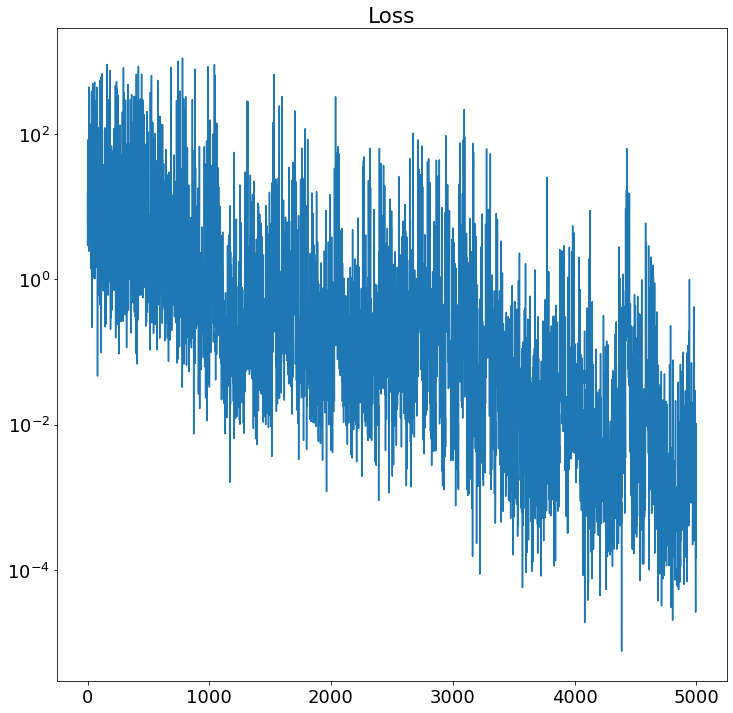

In [169]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

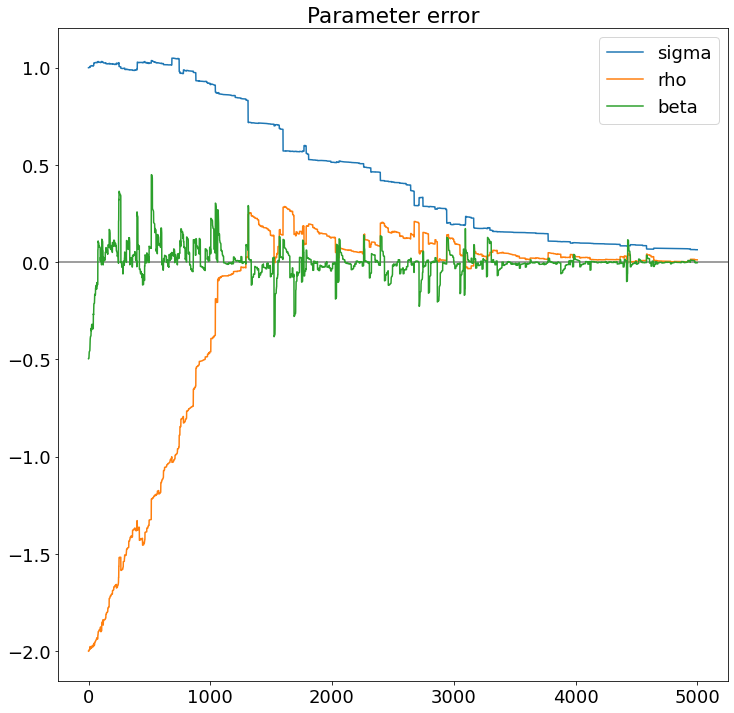

In [170]:
plot_params(h)

In [171]:
h = learning_loop(true_params, pert_params, 1e-3, 50, 2000, sparse=1)

  0%|          | 8/2000 [00:00<00:29, 67.59it/s]

Loss:  tensor(5.0997, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8451, grad_fn=<MeanBackward0>)
Loss:  tensor(39.5262, grad_fn=<MeanBackward0>)
Loss:  tensor(262.1996, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7536, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1970, grad_fn=<MeanBackward0>)
Loss:  tensor(19.8734, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3792, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7267, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5910, grad_fn=<MeanBackward0>)
Loss:  tensor(138.6645, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:00<00:38, 51.54it/s]

Loss:  tensor(5.3331, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7621, grad_fn=<MeanBackward0>)
Loss:  tensor(12.1320, grad_fn=<MeanBackward0>)
Loss:  tensor(117.4412, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4255, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2709, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0916, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5333, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1009, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4951, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:00<00:36, 54.30it/s]

Loss:  tensor(0.8623, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8642, grad_fn=<MeanBackward0>)
Loss:  tensor(19.6068, grad_fn=<MeanBackward0>)
Loss:  tensor(167.6422, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3566, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(16.0995, grad_fn=<MeanBackward0>)
Loss:  tensor(72.6229, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0634, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2399, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:00<00:35, 55.70it/s]

Loss:  tensor(0.2567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9736, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5540, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4053, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9058, grad_fn=<MeanBackward0>)
Loss:  tensor(16.6203, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7851, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0781, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3788, grad_fn=<MeanBackward0>)
Loss:  

  3%|▎         | 51/2000 [00:00<00:36, 53.76it/s]

tensor(3.5177, grad_fn=<MeanBackward0>)
Loss:  tensor(26.2441, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1742, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3922, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8946, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4462, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5743, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8259, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3552, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4084, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1910, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:01<00:32, 59.38it/s]

Loss:  tensor(0.1489, grad_fn=<MeanBackward0>)
Loss:  tensor(15.3010, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9473, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3345, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7577, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1591, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5498, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1203, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6682, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8464, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:01<00:38, 49.45it/s]

Loss:  tensor(0.6191, grad_fn=<MeanBackward0>)
Loss:  tensor(13.1192, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5502, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3163, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6387, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4312, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8733, grad_fn=<MeanBackward0>)
Loss:  tensor(85.6622, grad_fn=<MeanBackward0>)
Loss:  

  4%|▍         | 83/2000 [00:01<00:39, 48.23it/s]

tensor(2.4622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0999, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4594, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7632, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5682, grad_fn=<MeanBackward0>)
Loss:  tensor(25.8643, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6114, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2050, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4835, grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:01<00:37, 50.28it/s]

Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1556, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7478, grad_fn=<MeanBackward0>)
Loss:  tensor(37.1913, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5987, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4305, grad_fn=<MeanBackward0>)
Loss:  tensor(39.9117, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8519, grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:02<00:38, 48.60it/s]

Loss:  tensor(0.5155, grad_fn=<MeanBackward0>)
Loss:  tensor(12.6606, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7827, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7815, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7637, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9710, grad_fn=<MeanBackward0>)


  6%|▌         | 119/2000 [00:02<00:36, 51.17it/s]

Loss:  tensor(1.3289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0949, grad_fn=<MeanBackward0>)
Loss:  tensor(19.1968, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8576, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4814, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8638, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5966, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5459, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3447, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8046, grad_fn=<MeanBackward0>)


  7%|▋         | 135/2000 [00:02<00:29, 63.24it/s]

Loss:  tensor(0.5114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3293, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1270, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8738, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0485, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5047, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3390, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8850, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3855, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9901, grad_fn=<MeanBackward0>)
Loss:  tensor(28.2951, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5189, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3688, grad_fn=<MeanBackward0>)


  8%|▊         | 151/2000 [00:02<00:26, 70.23it/s]

Loss:  tensor(0.5555, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2238, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6646, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4296, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1844, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6202, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8681, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4634, grad_fn=<MeanBackward0>)
Loss:  tensor(40.4099, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5353, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3954, grad_fn=<MeanBackward0>)


  8%|▊         | 167/2000 [00:02<00:24, 73.96it/s]

Loss:  tensor(0.2533, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1224, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5599, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1816, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2020, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7340, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0661, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2228, grad_fn=<MeanBackward0>)


  9%|▉         | 175/2000 [00:03<00:25, 71.41it/s]

Loss:  tensor(0.4173, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0901, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1585, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0985, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6705, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3202, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4481, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6760, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9850, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9748, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3277, grad_fn=<MeanBackward0>)


 10%|▉         | 191/2000 [00:03<00:25, 69.71it/s]

Loss:  tensor(0.1120, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4942, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3406, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2663, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1606, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5021, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0822, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0816, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8497, grad_fn=<MeanBackward0>)


 10%|█         | 207/2000 [00:03<00:25, 70.75it/s]

Loss:  tensor(0.1919, grad_fn=<MeanBackward0>)
Loss:  tensor(14.5393, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7850, grad_fn=<MeanBackward0>)
Loss:  tensor(20.7645, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4862, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2270, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6326, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1941, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2669, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5833, grad_fn=<MeanBackward0>)


 11%|█         | 223/2000 [00:03<00:24, 73.26it/s]

Loss:  tensor(0.4744, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6842, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0390, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3476, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7262, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2755, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6471, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1598, grad_fn=<MeanBackward0>)
Loss:  

 12%|█▏        | 239/2000 [00:03<00:23, 73.86it/s]

tensor(0.8085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4690, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4282, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4569, grad_fn=<MeanBackward0>)
Loss:  tensor(13.1801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5862, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3231, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2951, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7556, grad_fn=<MeanBackward0>)


 13%|█▎        | 255/2000 [00:04<00:24, 72.58it/s]

Loss:  tensor(0.2423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5955, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7121, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6676, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3501, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4909, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0965, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7935, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2997, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5417, grad_fn=<MeanBackward0>)


 13%|█▎        | 263/2000 [00:04<00:23, 72.93it/s]

Loss:  tensor(0.0284, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4143, grad_fn=<MeanBackward0>)
Loss:  tensor(31.3671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2933, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4164, grad_fn=<MeanBackward0>)
Loss:  tensor(14.2797, grad_fn=<MeanBackward0>)


 14%|█▍        | 279/2000 [00:04<00:24, 69.82it/s]

Loss:  tensor(0.7269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0690, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0409, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1507, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5479, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1549, grad_fn=<MeanBackward0>)
Loss:  tensor(12.7043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)
Loss:  tensor(13.2209, grad_fn=<MeanBackward0>)


 15%|█▍        | 295/2000 [00:04<00:24, 70.73it/s]

Loss:  tensor(0.6643, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1342, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8340, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4835, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3602, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1669, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7950, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6282, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3329e-05, grad_fn=<MeanBackward0>)


 16%|█▌        | 311/2000 [00:04<00:23, 71.16it/s]

Loss:  tensor(2.9822, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5046, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5255, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2038, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8028, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0907, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 16%|█▋        | 327/2000 [00:05<00:23, 70.04it/s]

Loss:  tensor(3.9615, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2522, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9028, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1871, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0483, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2539, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6891, grad_fn=<MeanBackward0>)


 17%|█▋        | 335/2000 [00:05<00:31, 53.61it/s]

Loss:  tensor(0.0278, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3268, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2266, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1592, grad_fn=<MeanBackward0>)


 17%|█▋        | 347/2000 [00:05<00:30, 54.38it/s]

Loss:  tensor(0.1314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1685, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1285, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2162, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2555, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1925, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2031, grad_fn=<MeanBackward0>)


 18%|█▊        | 360/2000 [00:05<00:27, 58.92it/s]

Loss:  tensor(2.5085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4989, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2984, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4131, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3816, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1670, grad_fn=<MeanBackward0>)
Loss:  

 19%|█▉        | 375/2000 [00:06<00:25, 63.21it/s]

tensor(0.1547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0331, grad_fn=<MeanBackward0>)
Loss:  tensor(11.2546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4803, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1953, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1740, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0560, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3256, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1019, grad_fn=<MeanBackward0>)
Loss:  

 19%|█▉        | 389/2000 [00:06<00:26, 60.50it/s]

tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0596, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1666, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0581, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2669, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1494, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1462, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0768, grad_fn=<MeanBackward0>)


 20%|█▉        | 396/2000 [00:06<00:26, 60.93it/s]

Loss:  tensor(12.5024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0795, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0245, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1449, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1631, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0757, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0525, grad_fn=<MeanBackward0>)


 20%|██        | 409/2000 [00:06<00:31, 50.57it/s]

Loss:  tensor(0.1744, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1388, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0606, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1922, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1273, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1603, grad_fn=<MeanBackward0>)


 21%|██        | 415/2000 [00:06<00:32, 48.04it/s]

Loss:  tensor(0.1791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1330, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7917e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1743, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0719, grad_fn=<MeanBackward0>)


 21%|██▏       | 425/2000 [00:07<00:35, 43.77it/s]

Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5925, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1953, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1220, grad_fn=<MeanBackward0>)


 22%|██▏       | 438/2000 [00:07<00:30, 51.41it/s]

Loss:  tensor(0.1335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0988, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2956, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0226, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0717, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3749, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0332, grad_fn=<MeanBackward0>)


 23%|██▎       | 454/2000 [00:07<00:24, 61.92it/s]

Loss:  tensor(0.0252, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0623, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0675, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3953, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1822, grad_fn=<MeanBackward0>)


 23%|██▎       | 469/2000 [00:07<00:23, 65.28it/s]

Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0484, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1529, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)


 24%|██▍       | 485/2000 [00:07<00:21, 70.23it/s]

Loss:  tensor(0.3400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0612, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0556, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0286, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0584, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3434, grad_fn=<MeanBackward0>)


 25%|██▍       | 493/2000 [00:08<00:21, 70.65it/s]

Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1831e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0416, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1733, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)


 25%|██▌       | 509/2000 [00:08<00:21, 68.73it/s]

Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2434, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9686, grad_fn=<MeanBackward0>)


 26%|██▋       | 525/2000 [00:08<00:21, 69.53it/s]

Loss:  tensor(0.0361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0490, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1898, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0615, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3459, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0312, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1826, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1806, grad_fn=<MeanBackward0>)


 27%|██▋       | 541/2000 [00:08<00:20, 70.44it/s]

Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2721, grad_fn=<MeanBackward0>)


 28%|██▊       | 557/2000 [00:08<00:19, 74.19it/s]

Loss:  tensor(0.4420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0505, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0176e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0917, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6429, grad_fn=<MeanBackward0>)


 29%|██▊       | 574/2000 [00:09<00:18, 75.97it/s]

Loss:  tensor(0.0348, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0781, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0957, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0278, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0739, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0402, grad_fn=<MeanBackward0>)


 30%|██▉       | 591/2000 [00:09<00:18, 78.07it/s]

Loss:  tensor(0.2261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4740, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0813, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0319, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0391, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2521, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5567e-05, grad_fn=<MeanBackward0>)


 30%|███       | 608/2000 [00:09<00:17, 77.73it/s]

Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0515, grad_fn=<MeanBackward0>)


 31%|███       | 624/2000 [00:09<00:18, 75.69it/s]

Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6161e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0798, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  

 32%|███▏      | 640/2000 [00:10<00:18, 74.87it/s]

tensor(0.5819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9583, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2004e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1885, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)


 32%|███▏      | 649/2000 [00:10<00:17, 76.91it/s]

Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2892, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0284, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5516e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0785, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0915, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1112e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8640, grad_fn=<MeanBackward0>)


 33%|███▎      | 666/2000 [00:10<00:17, 75.88it/s]

Loss:  tensor(9.7847e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9442e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7981, grad_fn=<MeanBackward0>)


 34%|███▍      | 682/2000 [00:10<00:18, 71.80it/s]

Loss:  tensor(0.0477, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)


 35%|███▍      | 697/2000 [00:10<00:20, 65.04it/s]

Loss:  tensor(0.0570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1680, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  

 36%|███▌      | 712/2000 [00:11<00:19, 67.07it/s]

tensor(0.7787, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1423e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0815, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9749e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1960, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)


 36%|███▋      | 729/2000 [00:11<00:17, 72.93it/s]

Loss:  tensor(1.2575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7240e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7133e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 37%|███▋      | 737/2000 [00:11<00:17, 73.43it/s]

Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0904e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0305, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2975, grad_fn=<MeanBackward0>)


 38%|███▊      | 753/2000 [00:11<00:19, 62.76it/s]

Loss:  tensor(0.0700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)


 38%|███▊      | 769/2000 [00:11<00:18, 68.09it/s]

Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1822, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0720, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1397, grad_fn=<MeanBackward0>)


 39%|███▉      | 784/2000 [00:12<00:18, 66.85it/s]

Loss:  tensor(0.0853, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0868, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0531, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6144e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4767, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)


 40%|███▉      | 798/2000 [00:12<00:18, 64.45it/s]

Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3438, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)


 40%|████      | 805/2000 [00:12<00:19, 60.87it/s]

Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2098e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)


 41%|████      | 819/2000 [00:12<00:20, 57.14it/s]

Loss:  tensor(1.3819e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5909, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 42%|████▏     | 832/2000 [00:13<00:21, 53.81it/s]

Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0565, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7416e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)


 42%|████▏     | 838/2000 [00:13<00:23, 49.63it/s]

Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0812, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)


 43%|████▎     | 853/2000 [00:13<00:20, 57.33it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0745, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0857, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2936, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6639e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 43%|████▎     | 859/2000 [00:13<00:20, 56.01it/s]

Loss:  tensor(7.5699e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)


 43%|████▎     | 865/2000 [00:13<00:28, 39.69it/s]

Loss:  tensor(1.3531, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0188, grad_fn=<MeanBackward0>)


 44%|████▎     | 870/2000 [00:13<00:31, 35.43it/s]

Loss:  tensor(5.3226e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 44%|████▍     | 879/2000 [00:14<00:36, 30.39it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 45%|████▍     | 894/2000 [00:14<00:23, 47.10it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1446e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0649, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 46%|████▌     | 910/2000 [00:14<00:18, 60.20it/s]

Loss:  tensor(2.3968e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6877, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3526, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6229, grad_fn=<MeanBackward0>)


 46%|████▌     | 918/2000 [00:14<00:16, 63.69it/s]

Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9164e-10, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0955, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0074e-07, grad_fn=<MeanBackward0>)


 47%|████▋     | 935/2000 [00:15<00:16, 65.87it/s]

Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0950, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7022e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1734e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  

 48%|████▊     | 951/2000 [00:15<00:15, 68.08it/s]

tensor(0.0816, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)


 48%|████▊     | 967/2000 [00:15<00:14, 70.60it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1691e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1918, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4699e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0299e-05, grad_fn=<MeanBackward0>)


 49%|████▉     | 984/2000 [00:15<00:13, 74.96it/s]

Loss:  tensor(0.0608, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0955e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8460e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2479e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1524e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0372, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0333, grad_fn=<MeanBackward0>)
Loss:  

 50%|█████     | 1001/2000 [00:15<00:12, 77.02it/s]

tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3666e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1629e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3103e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)


 50%|█████     | 1009/2000 [00:16<00:13, 75.95it/s]

Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5670e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0779, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4460e-05, grad_fn=<MeanBackward0>)
Loss:  

 51%|█████▏    | 1026/2000 [00:16<00:12, 75.96it/s]

tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9576e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0285, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1742e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)


 52%|█████▏    | 1042/2000 [00:16<00:13, 72.75it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0595, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0019e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0696, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)


 53%|█████▎    | 1059/2000 [00:16<00:12, 75.44it/s]

Loss:  tensor(0.0148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0411, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7601, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9382e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)


 54%|█████▍    | 1075/2000 [00:16<00:12, 76.65it/s]

Loss:  tensor(4.1096e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6292e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4851, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7599e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 55%|█████▍    | 1091/2000 [00:17<00:11, 75.79it/s]

Loss:  tensor(0.0793, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0630, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4516e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7064e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0796e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2820e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5015e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0449, grad_fn=<MeanBackward0>)


 55%|█████▌    | 1108/2000 [00:17<00:11, 78.25it/s]

Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8059e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9553e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1933, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  

 56%|█████▋    | 1125/2000 [00:17<00:11, 74.57it/s]

tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2926, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3633e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0635, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)


 57%|█████▋    | 1133/2000 [00:17<00:11, 73.80it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2465e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7902e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0256, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4541e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0836, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5498e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)


 57%|█████▊    | 1150/2000 [00:17<00:11, 73.42it/s]

Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1393e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0694e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0356, grad_fn=<MeanBackward0>)


 58%|█████▊    | 1166/2000 [00:18<00:11, 72.57it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8746e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9895e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0658, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


 59%|█████▉    | 1182/2000 [00:18<00:11, 74.19it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0867, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8854e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)


 60%|█████▉    | 1198/2000 [00:18<00:11, 69.77it/s]

Loss:  tensor(4.9291e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3427e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4653e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0633, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 61%|██████    | 1215/2000 [00:18<00:10, 74.79it/s]

Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1310, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2172e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0899, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3172e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7200e-05, grad_fn=<MeanBackward0>)
Loss:  

 62%|██████▏   | 1231/2000 [00:19<00:10, 72.96it/s]

tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7474e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6754e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4595, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 62%|██████▏   | 1248/2000 [00:19<00:09, 76.05it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1739e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1605, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)


 63%|██████▎   | 1264/2000 [00:19<00:09, 76.20it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3250e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2556, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1474, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2485e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2996e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 64%|██████▍   | 1280/2000 [00:19<00:09, 72.24it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1379, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2859, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5751e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)


 64%|██████▍   | 1289/2000 [00:19<00:09, 75.14it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7463e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0450, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5214e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0231e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)


 65%|██████▌   | 1306/2000 [00:20<00:09, 69.82it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1501e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0942, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 66%|██████▌   | 1322/2000 [00:20<00:09, 71.63it/s]

Loss:  tensor(0.0663, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4653e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7147e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2074e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2576e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8422e-05, grad_fn=<MeanBackward0>)


 67%|██████▋   | 1339/2000 [00:20<00:08, 74.10it/s]

Loss:  tensor(5.5764e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0493e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0921, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0942, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5183e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0206e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 68%|██████▊   | 1355/2000 [00:20<00:08, 72.94it/s]

Loss:  tensor(0.1390, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0814, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5586e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  

 69%|██████▊   | 1372/2000 [00:20<00:08, 76.06it/s]

tensor(0.2108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2319e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9746e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2824e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 69%|██████▉   | 1380/2000 [00:21<00:08, 74.78it/s]

Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2485, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5547e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3006e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8222e-05, grad_fn=<MeanBackward0>)


 70%|██████▉   | 1397/2000 [00:21<00:08, 74.58it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9484e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3976e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  

 71%|███████   | 1414/2000 [00:21<00:07, 74.19it/s]

tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0259e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7620e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4774e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 72%|███████▏  | 1430/2000 [00:21<00:07, 72.71it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7183e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0883e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7492e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)


 72%|███████▏  | 1438/2000 [00:21<00:07, 73.49it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8165e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3535e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)


 73%|███████▎  | 1453/2000 [00:22<00:09, 58.35it/s]

Loss:  tensor(8.8331e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0786, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2020e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4598e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8172e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8620e-07, grad_fn=<MeanBackward0>)


 73%|███████▎  | 1466/2000 [00:22<00:09, 53.92it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0891, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1662e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4355e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0433, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)


 74%|███████▎  | 1472/2000 [00:22<00:09, 53.62it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0122e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0745e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)


 74%|███████▍  | 1485/2000 [00:22<00:09, 57.04it/s]

Loss:  tensor(6.9355e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6162e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2775e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 75%|███████▍  | 1497/2000 [00:23<00:09, 50.98it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5262e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9754e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 76%|███████▌  | 1513/2000 [00:23<00:07, 62.74it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6930e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0937, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9387e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0284, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1226e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4705e-05, grad_fn=<MeanBackward0>)


 76%|███████▋  | 1529/2000 [00:23<00:06, 70.15it/s]

Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6505e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7411e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)


 77%|███████▋  | 1545/2000 [00:23<00:06, 66.52it/s]

Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6081e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4045e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0455, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4705e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0849e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)


 78%|███████▊  | 1552/2000 [00:23<00:06, 66.36it/s]

Loss:  tensor(0.0165, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3563e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5972e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4705e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5879e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1901e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1955e-05, grad_fn=<MeanBackward0>)


 78%|███████▊  | 1566/2000 [00:24<00:07, 56.24it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0754e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4211e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8645e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 79%|███████▉  | 1580/2000 [00:24<00:06, 60.50it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3897e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8290e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 80%|███████▉  | 1595/2000 [00:24<00:06, 64.18it/s]

Loss:  tensor(9.7394e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7096e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3030e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3147e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1067e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2938e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0430, grad_fn=<MeanBackward0>)


 80%|████████  | 1610/2000 [00:24<00:06, 64.88it/s]

Loss:  tensor(8.3209e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2870e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2494e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8083e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5079e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4572e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0399, grad_fn=<MeanBackward0>)


 81%|████████  | 1617/2000 [00:24<00:06, 60.09it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7362e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6650e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 82%|████████▏ | 1630/2000 [00:25<00:06, 55.64it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6121e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2768e-05, grad_fn=<MeanBackward0>)


 82%|████████▏ | 1643/2000 [00:25<00:06, 55.98it/s]

Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5812e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7987e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3532e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4838e-07, grad_fn=<MeanBackward0>)


 83%|████████▎ | 1657/2000 [00:25<00:05, 60.03it/s]

Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9216e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1322e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9738e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 84%|████████▎ | 1671/2000 [00:25<00:05, 60.32it/s]

Loss:  tensor(8.8194e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1101e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9819e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8877e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0562, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0275, grad_fn=<MeanBackward0>)


 84%|████████▍ | 1678/2000 [00:26<00:06, 53.38it/s]

Loss:  tensor(1.9281e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3864e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3065e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0450, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9193e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6211e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 84%|████████▍ | 1684/2000 [00:26<00:07, 44.64it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0239, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1374e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5418e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0458, grad_fn=<MeanBackward0>)


 84%|████████▍ | 1689/2000 [00:26<00:08, 38.52it/s]

Loss:  tensor(0.0532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1735e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9566e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6723e-05, grad_fn=<MeanBackward0>)


 85%|████████▍ | 1699/2000 [00:26<00:07, 38.22it/s]

Loss:  tensor(4.8069e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2974e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 85%|████████▌ | 1704/2000 [00:26<00:08, 35.44it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6848e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7268e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5786e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3337e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 86%|████████▌ | 1713/2000 [00:27<00:07, 36.67it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6416e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 86%|████████▋ | 1725/2000 [00:27<00:06, 45.65it/s]

Loss:  tensor(1.1585e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2284e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5107e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1945e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 87%|████████▋ | 1736/2000 [00:27<00:05, 46.37it/s]

Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1924e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5847e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1430e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9008e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 87%|████████▋ | 1749/2000 [00:27<00:04, 51.84it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6934e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0252, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4623e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3492e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 88%|████████▊ | 1755/2000 [00:27<00:04, 53.20it/s]

Loss:  tensor(4.0338e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0871e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7917e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)


 88%|████████▊ | 1761/2000 [00:28<00:05, 41.81it/s]

Loss:  tensor(3.4726e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7408e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1408e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8827e-06, grad_fn=<MeanBackward0>)


 89%|████████▊ | 1771/2000 [00:28<00:06, 34.29it/s]

Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8946e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 89%|████████▉ | 1775/2000 [00:28<00:08, 28.12it/s]

Loss:  tensor(4.9630e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3456e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9722e-06, grad_fn=<MeanBackward0>)
Loss:  

 89%|████████▉ | 1784/2000 [00:28<00:06, 33.35it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1461e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0206e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2229e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0040e-05, grad_fn=<MeanBackward0>)


 90%|████████▉ | 1795/2000 [00:29<00:05, 40.49it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1185e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 90%|█████████ | 1805/2000 [00:29<00:05, 38.72it/s]

Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5983e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5635e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8312e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)


 91%|█████████ | 1818/2000 [00:29<00:03, 49.08it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6470e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5630e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7605e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1895e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3978e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0147e-06, grad_fn=<MeanBackward0>)


 91%|█████████ | 1824/2000 [00:29<00:03, 48.32it/s]

Loss:  tensor(4.4121e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3791e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6761e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2284e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6451e-05, grad_fn=<MeanBackward0>)


 92%|█████████▏| 1834/2000 [00:29<00:03, 44.70it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6416e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4216e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0271, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0745e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss: 

 92%|█████████▏| 1844/2000 [00:30<00:03, 39.85it/s]

 tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 92%|█████████▏| 1849/2000 [00:30<00:03, 39.46it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1952e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4324e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 93%|█████████▎| 1858/2000 [00:30<00:04, 29.32it/s]

Loss:  tensor(9.6880e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 93%|█████████▎| 1862/2000 [00:30<00:04, 29.34it/s]

Loss:  tensor(8.5257e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(9.8560e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4279e-06, grad_fn=<MeanBackward0>)


 94%|█████████▎| 1870/2000 [00:31<00:05, 25.74it/s]

Loss:  tensor(6.3198e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9868e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4122e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5693e-05, grad_fn=<MeanBackward0>)


 94%|█████████▍| 1883/2000 [00:31<00:02, 39.84it/s]

Loss:  tensor(5.0202e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8598e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3505e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4013e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9177e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9530e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7397e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 95%|█████████▍| 1898/2000 [00:31<00:01, 54.80it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9074e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4290e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8071e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4756e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0407e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6138e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4837e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4174e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3920e-05, grad_fn=<MeanBackward0>)


 96%|█████████▌| 1913/2000 [00:31<00:01, 62.14it/s]

Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5821e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2901e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5278e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5363e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5871e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2930e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)


 96%|█████████▌| 1920/2000 [00:32<00:01, 54.11it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0296e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4522e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0966e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7416e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7186e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)

 97%|█████████▋| 1932/2000 [00:32<00:01, 45.48it/s]


Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2927e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4537e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1916e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7139e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 97%|█████████▋| 1943/2000 [00:32<00:01, 45.15it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0769e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2944e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0895e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4038e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2605e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2828e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9528e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 1954/2000 [00:32<00:00, 47.88it/s]

Loss:  tensor(9.3715e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3571e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1415e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 98%|█████████▊| 1959/2000 [00:33<00:01, 39.72it/s]

Loss:  tensor(2.5002e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3481e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4911e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4667e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 98%|█████████▊| 1968/2000 [00:33<00:00, 37.90it/s]

Loss:  tensor(1.9835e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5023e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5581e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3903e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5055e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)


 99%|█████████▊| 1972/2000 [00:33<00:00, 34.70it/s]

Loss:  tensor(6.3869e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4681e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3874e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4604e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5135e-06, grad_fn=<MeanBackward0>)


 99%|█████████▉| 1980/2000 [00:33<00:00, 30.39it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9823e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4156e-05, grad_fn=<MeanBackward0>)


100%|█████████▉| 1991/2000 [00:33<00:00, 40.00it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7361e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9153e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5496e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1226e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2271e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5673e-05, grad_fn=<MeanBackward0>)


100%|██████████| 2000/2000 [00:34<00:00, 58.59it/s]

Loss:  tensor(3.1460e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5068e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6120e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0133e-05, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(3.0133e-05, grad_fn=<MeanBackward0>)


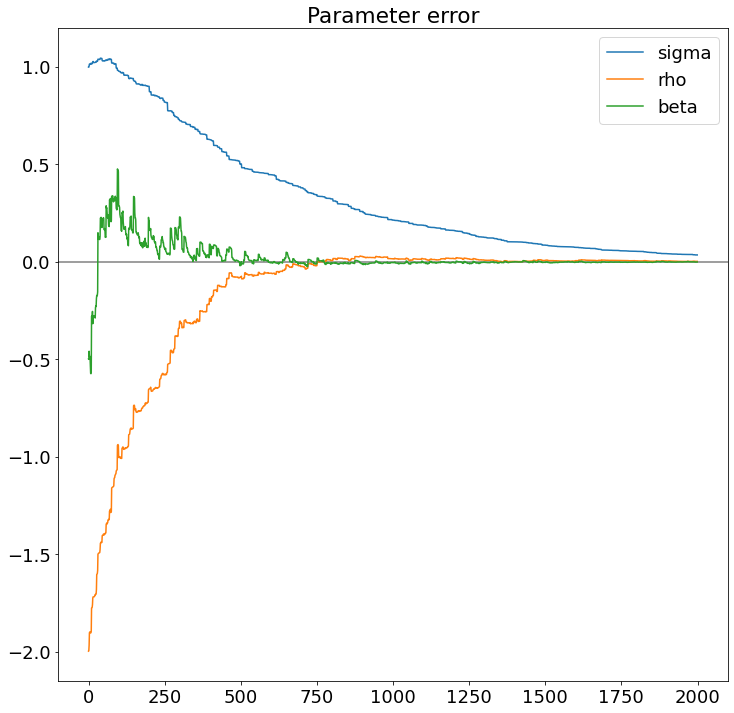

In [172]:
plot_params(h)

### PyTorch Sequential - in progress

In [92]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [93]:
class BobTheLorenzBuilder():
    def __init__(self, sigma, rho, beta, initparam1, initparam2, initparam3, dt, T):
        self.beta = beta
        self.rho = rho
        self.sigma = sigma
        self.initparam1 = initparam1
        self.initparam2 = initparam2
        self.initparam3 = initparam3
        self.dt = dt
        self.T = T
        print('sigma: ', self.sigma, 'rho: ', self.rho, 'beta: ', self.beta, 'init params: ', [self.initparam1, self.initparam2, self.initparam3], 'dt: ', self.dt)
        print('Chosen dt: ', self.dt)
        print('Chosen T: ', self.T)
  
    def InitializeAttractor(self, x, t):
        return [
            self.sigma * (x[1] - x[0]),
            x[0] * (self.rho - x[2]) - x[1],
            x[0] * x[1] - self.beta * x[2],
        ]

    def MakeAttractor(self):
        seed = 100
        np.random.seed(seed)
        t_range = np.arange(0, 100, self.dt)
        x0_params = [self.initparam1, self.initparam2, self.initparam3]
        print("x0 initialization parameters: ", x0_params)
        print("t_range: ", t_range)
        odesol = odeint(self.InitializeAttractor, x0_params, t_range)
        xdot_measured = np.array([self.InitializeAttractor(odesol[i], 0) for i in range(t_range.size)])
        self.odesol = odesol
        print('odesol matrix shape: ', odesol.shape)
        print('odesol matrix type: ', type(odesol))
        self.xdot_measured = xdot_measured
        self.t_range = t_range
        return odesol
    
    def VisualizeIt(self):
        fig = plt.figure(figsize=(30, 15))
        ax = fig.add_subplot(131, projection="3d")
        ax.plot(
            self.odesol[: self.t_range.size, 0],
            self.odesol[: self.t_range.size, 1],
            self.odesol[: self.t_range.size, 2],
        )
        plt.title("Attractor Visualized")
        ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
        fig.show()
        plt.figure(figsize = (30,20))
        plt.plot(self.odesol[:self.t_range.size], linewidth = 1)
        plt.show()
        
    def MysteryLorenz(self, x_y_z, t0):
        x, y, z = x_y_z
        return [self.sigma * (y - x), x * (self.rho - z) - y, x * y - self.beta * z]
    
    def NeuralLorenzMaker(self):
        t = np.arange(0, self.T + self.dt, self.dt)
        nn_input = np.zeros((100 * (len(t) - 1),3))
        nn_output = np.zeros_like(nn_input)
        fig, ax = plt.subplots(1, 1, subplot_kw = {'projection':'3d'})
        np.random.seed(123)
        x0 = -15 + 30 * np.random.random((100, 3))
        x_t = np.asarray([odeint(self.MysteryLorenz, x0_j, t) for x0_j in x0])
        for j in range(100):
            nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
            nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
            x, y, z = x_t[j,:,:].T
            ax.plot(x, y, z,linewidth=1)
            ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
        ax.view_init(18, -113)
        plt.show()
        self.nn_input = nn_input
        self.nn_output = nn_output

    def MakeInputTensor(self):
        xpretens = self.nn_input
        nn_input = torch.tensor(xpretens)
        return nn_input
    
    def MakeOutputTensor(self):
        ypretens = self.nn_output
        nn_output = torch.tensor(ypretens)
        return nn_output

sigma:  10 rho:  28 beta:  2.66667 init params:  [-8, 8, 27] dt:  0.002
Chosen dt:  0.002
Chosen T:  8
x0 initialization parameters:  [-8, 8, 27]
t_range:  [0.0000e+00 2.0000e-03 4.0000e-03 ... 9.9994e+01 9.9996e+01 9.9998e+01]
odesol matrix shape:  (50000, 3)
odesol matrix type:  <class 'numpy.ndarray'>


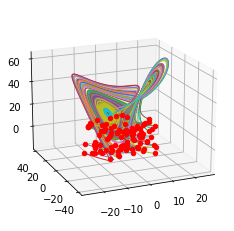

In [94]:
attractor = BobTheLorenzBuilder(10, 28, 2.66667, -8, 8, 27, 0.002, 8)
attractor.MakeAttractor()
attractor.NeuralLorenzMaker()
input_tensor = attractor.MakeInputTensor()
output_tensor = attractor.MakeOutputTensor()

In [95]:
print(f"Shape of tensor: {input_tensor.shape}")
print(f"Tensor dtype: {input_tensor.dtype}")
print(f"Tensor location: {input_tensor.device}")
print('-- -- -- -- -- -- -- --')
print(f"Shape of tensor: {output_tensor.shape}")
print(f"Tensor dtype: {output_tensor.dtype}")
print(f"Tensor location: {output_tensor.device}")

Shape of tensor: torch.Size([400100, 3])
Tensor dtype: torch.float64
Tensor location: cpu
-- -- -- -- -- -- -- --
Shape of tensor: torch.Size([400100, 3])
Tensor dtype: torch.float64
Tensor location: cpu
